# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> Data Science 2: Advanced Topics in Data Science
## Final Project Milestone 2: Crypto Price Prediction


**Harvard University**<br/>
**Spring 2024**<br/>
**Authors**: Brenda Lin, Cyrus Asgari, Darius Mardaru, Sunny Tang


<hr style="height:2pt">

### Code Dependencies
This notebook can be run in the cs109b virtual environment with no additional package installations.
<hr style="height:2.4pt">

# Notebook Contents <a id="contents"></a>

1. [**Problem Statement**](#problem)
2. [**Exploring Data & Potential Issues**](#eda)
3. [**Preprocessing Steps**](#data-cleaning)
4. [**Baseline Model**](#baseline)
<hr style="height:2.4pt">

### Problem Statement <a id="problem"></a>

Quantitative stock and bond trading strategies center on exploiting inefficiencies and thrive off volatility. Crypto markets provide a compelling trading opportunity because they appear to be both inefficient and very volatile. Additionally, there are far fewer institutional firms trading them and they are open 24/7. Our project seeks to predict cryptocurrency trading prices across various timescales (ranging from 1 hour to 1 month) to inform quantitative trading strategies.

[**Return to Contents**](#contents)
<hr style="height:2.4pt">

### Exploring Data & Potential Issues <a id="eda"></a>


[**Return to Contents**](#contents)
<hr style="height:2.4pt">

# TODO

## Time Series Prices
Improve on existing plots. Also plot the different prices, open, close, high, low, and differences between them.

look at covariance between pairs, check outliers as well

## Trading Volume
Look at trading volume of different pairings, compare trading volume to missingness, trading volume to spread (close-open)

## Bucketized Data/Histograms
Bucketize volume, other data

## Preprocessing
Dropping (missing data & outliers), imputation, normalization

Dataset description:

Our dataset was downloaded from Kaggle (https://www.kaggle.com/datasets/tencars/392-crypto-currency-pairs-at-minute-resolution). The data had been previously compiled from Bitfinex, a cryptocurrency exchange platform, and, according to the Kaggle description, contains historical trading data of 400+ cryptocurrency trading pairs from as far back as 2013. The data is available in the form of 984 csv files, each file representing trading data for a specific trading pair.


#### Reading the data

Upon loading the dataset into our notebook, we can see that each csv file contains at least 6 columns: timestamp, open, close, high, low, and volume values. The name of the csv file identifies the specific trading pair, for example, “1inchusd,” which represents the exchange between 1inch coin and USD coin. Each entry has an associated timestamp and provides an opening and closing price, along with a high and low price over the given period. The information provided on Kaggle suggests that the data is at 1 minute resolution; however, this is something that we will need to check to see if any timepoints are missing and, further, decide how to address the missing data. Each entry also has a “volume” value, which represents the total number of shares traded within the time interval. Some of the files contain an “Unnamed” column that provides no useful information - this column will be ignored moving forward.

We also discovered that some of the file names contain the same crypto currency pairs, but with an extra mark in between the two currency symbols, such as "_" or "-".

From analyzing the timestamp columns for these trading pair repeats, we determined that the presence of "_", "-", or no mark represents datasets from different time periods.

In [1]:
import pandas as pd
import numpy as np
import glob
import re
import datetime
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
## load all 984 csv files into dataframes with a 'cur' column designating the name of the file

folder_path = '/Users/lyt/Desktop/MIT/Course/data science/hw/project/crypto/data/*.csv'

csv_files = glob.glob(folder_path)

dataframes = []
for file in csv_files:
    df = pd.read_csv(file)
    match = re.search(r'/([^/]+)\.csv$', file)
    if match:
        file_name = match.group(1)
        # print(file_name)
    df['cur'] = file_name
    dataframes.append(df)

In [3]:
## view first csv file

dataframes[0]

time    open   close    high     low     volume  Unnamed: 0  \
0     1680862500000  2.6000  2.6000  2.6000  2.6000   1.000000         NaN   
1     1680863340000  2.0700  2.6000  2.6000  2.0700  45.000000         NaN   
2     1680863460000  2.5900  2.5900  2.5900  2.5900  14.317636         NaN   
3     1680864120000  2.2000  2.2000  2.2000  2.2000  22.669164         NaN   
4     1680864360000  2.3000  2.3000  2.3000  2.3000  28.167131         NaN   
...             ...     ...     ...     ...     ...        ...         ...   
4215  1696712700000  2.0113  2.0113  2.0113  2.0113   1.160785         NaN   
4216  1696712880000  2.0730  2.0733  2.0733  2.0730   2.359975         NaN   
4217  1696713360000  2.0376  2.0376  2.0376  2.0376   2.033822         NaN   
4218  1696713780000  2.0726  2.0726  2.0726  2.0726   1.155972         NaN   
4219  1696715700000  2.0730  2.0730  2.0730  2.0730   0.005987         NaN   

         cur  
0     tonusd  
1     tonusd  
2     tonusd  
3     tonusd  
4     tonusd  
...      ...  
4215  tonusd  
4216  tonusd  
4217  tonusd  
4218  tonusd  
4219  tonusd  

[4220 rows x 8 columns]

In [4]:
## retain time, open, close, high, low, volume, and cur columns

col = ['time','open','close','high','low','volume','cur']
dataframes_after = []
for i in dataframes:
    df = i[col]
    dataframes_after.append(df)

In [5]:
## add column that indicates the "marker" found between the trading pair names, as well as a "normalized_currency" column that indicates the trading pair

def mark_special_char(s):
    if '_' in s:
        return '_'
    elif '-' in s:
        return '-'
    else:
        return 'non'

final_data = []
for i in dataframes_after:

    i['normalized_currency'] = i['cur'].str.replace('_|-', '', regex=True)

    i['marker'] = i['cur'].apply(mark_special_char)
    final_data.append(i)
    # print(i)

In [6]:
# Step 1: Merge DataFrames by 'normalized_currency'
merged_data = {}
for df in final_data:
    if not df.empty:  # Check if the DataFrame is not empty
        currency = df['normalized_currency'].iloc[0]  # Assuming each df has only one unique currency pair
        if currency in merged_data:
            merged_data[currency] = pd.concat([merged_data[currency], df])
        else:
            merged_data[currency] = df

# Convert the dictionary back to a list of DataFrames
merged_data_list = list(merged_data.values())


In [7]:
relevant_pairs = ['btcusd', 'ethusd', 'avaxusd', 'algusd', 'dogeusd', 'dotusd', 'galausd', 'linkusd', 'ltcusd', 'maticusd', 'nearusd', 'oceanusd', 'seiusd', 'shibusd', 'solusd', 'thetausd']
filtered_dfs = [df for df in merged_data_list if df['normalized_currency'].iloc[0] in relevant_pairs]

In [8]:
filtered_dfs

[               time      open     close      high       low         volume  \
 0     1682761860000  0.038993  0.038993  0.038993  0.038993      34.531142   
 1     1682762520000  0.038989  0.038981  0.038989  0.038981    3358.639688   
 2     1682763720000  0.038940  0.038940  0.038940  0.038940    1926.038083   
 3     1682765160000  0.038995  0.038995  0.038995  0.038995      38.928288   
 4     1682765280000  0.038995  0.038995  0.038995  0.038995    1756.189300   
 ...             ...       ...       ...       ...       ...            ...   
 1419  1686485400000  0.021332  0.021336  0.021336  0.021332   24566.193578   
 1420  1686485580000  0.021346  0.021346  0.021346  0.021346      32.000000   
 1421  1686485700000  0.021368  0.021368  0.021368  0.021368    3275.932752   
 1422  1686487320000  0.021404  0.021468  0.021472  0.021404  103129.324382   
 1423  1686488400000  0.021266  0.021266  0.021266  0.021266    5000.000000   
 
            cur normalized_currency marker  
 0   

In [9]:
len(relevant_pairs)

16

#### Check if the dataset has NaN values

After examining the dataset, we found that the dataset doesn't contain any NaN values in the time, open, close, high, low, and volume columns, which are the important quantities for building our model going forward.

In [10]:
for i in final_data:
    rows_with_nan = i.isna().any(axis=1)
    if(len(i[rows_with_nan])>0):
        print(i[rows_with_nan])

#### Check if the price is reasonable

The prices (open, close, high, low) are reasonable for all currencies. We screened for any price errors by evaluating whether the high price was greater than the low price and whether the open and close prices fell in between the high and low price range for each time interval.

In [11]:
for i in final_data:
    wrong_price = i[(i['high']<i['open'])|(i['high']<i['close'])|(i['high']<i['low'])|(i['low']>i['close'])|(i['low']>i['open'])]
    if(len(wrong_price)>0):
        display(wrong_price)

#### Check if the time is continuous

We chose to look at some of the trading pairs more closely to check if the price data is continuous over the entire time range provided by the Kaggle dataset. However, we found that most of the data for these trading pairs is not continuous.

For example, the "1inchusd" and "aave_usd" trading pairs are missing data from May 2023. We note that the files with marker "-" provide data from 2021.8.10 to 2021.8.29, and that the files with marker "_" provide data from 2023.6.3 to 2023.6.11. File with no marker in the file name have data that range from *FILL THIS IN*.

In [12]:
## add column that has timestamp converted to date

final_data_time = []
print(filtered_dfs)
for i in filtered_dfs:
    i['datetime'] = pd.to_datetime(i['time']/1000, unit='s')
    final_data_time.append(i)
all_time = pd.concat(final_data_time, axis=0)

[               time      open     close      high       low         volume  \
0     1682761860000  0.038993  0.038993  0.038993  0.038993      34.531142   
1     1682762520000  0.038989  0.038981  0.038989  0.038981    3358.639688   
2     1682763720000  0.038940  0.038940  0.038940  0.038940    1926.038083   
3     1682765160000  0.038995  0.038995  0.038995  0.038995      38.928288   
4     1682765280000  0.038995  0.038995  0.038995  0.038995    1756.189300   
...             ...       ...       ...       ...       ...            ...   
1419  1686485400000  0.021332  0.021336  0.021336  0.021332   24566.193578   
1420  1686485580000  0.021346  0.021346  0.021346  0.021346      32.000000   
1421  1686485700000  0.021368  0.021368  0.021368  0.021368    3275.932752   
1422  1686487320000  0.021404  0.021468  0.021472  0.021404  103129.324382   
1423  1686488400000  0.021266  0.021266  0.021266  0.021266    5000.000000   

           cur normalized_currency marker  
0      galausd    

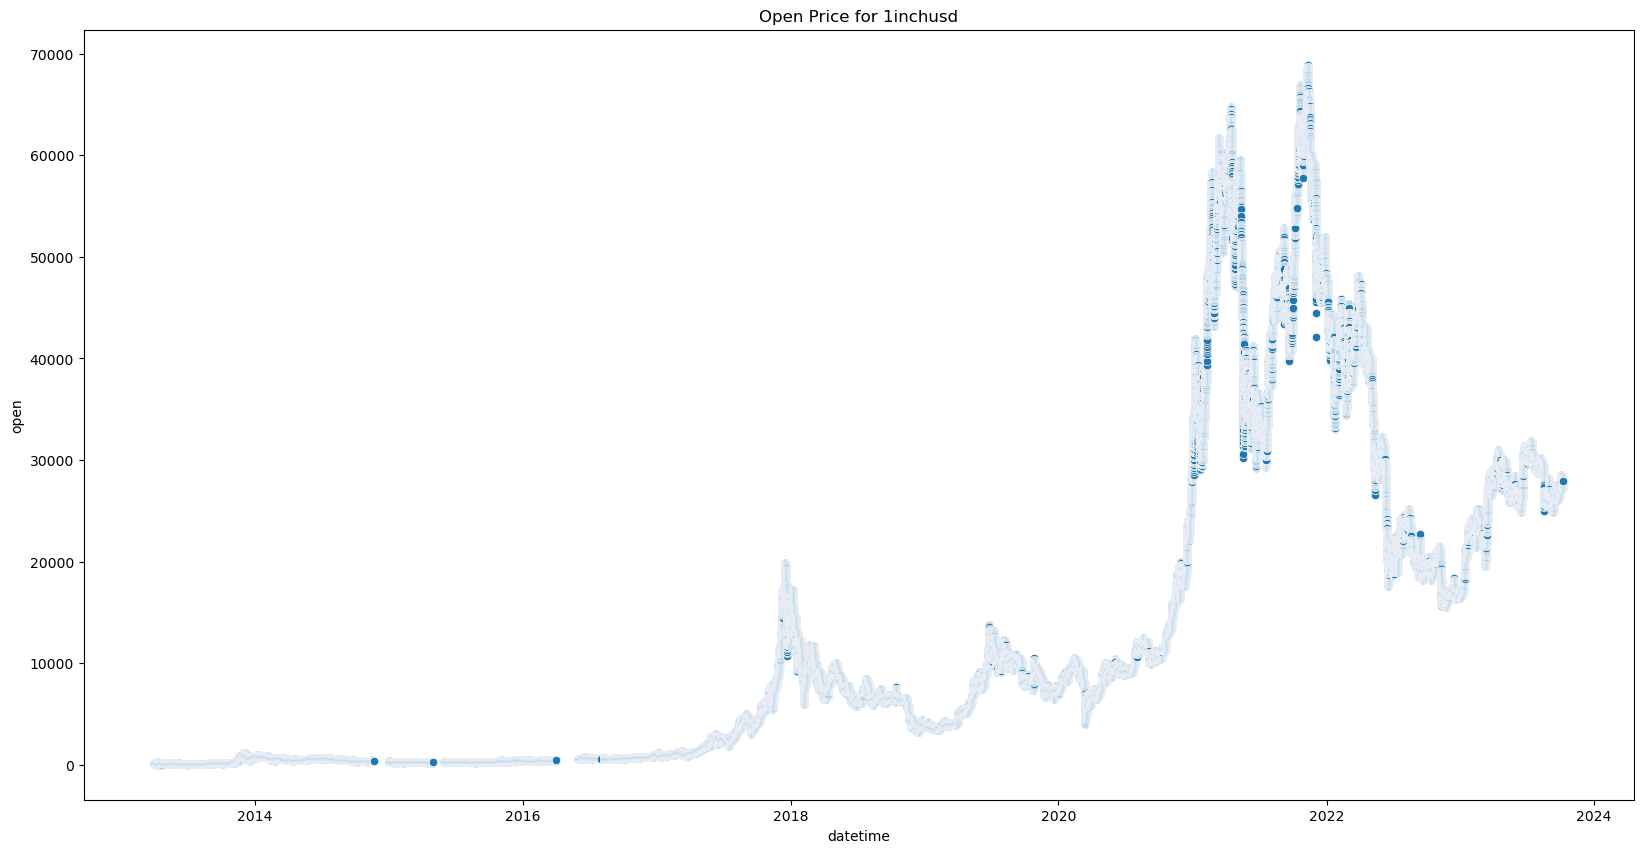

In [19]:
## plot 1inchusd open price data

btcusd = all_time[all_time['normalized_currency'] == 'btcusd']
plt.figure(figsize = (20,10))
plt.title('Open Price for 1inchusd')
sns.scatterplot(data=btcusd,x = 'datetime', y = 'open')
plt.show()

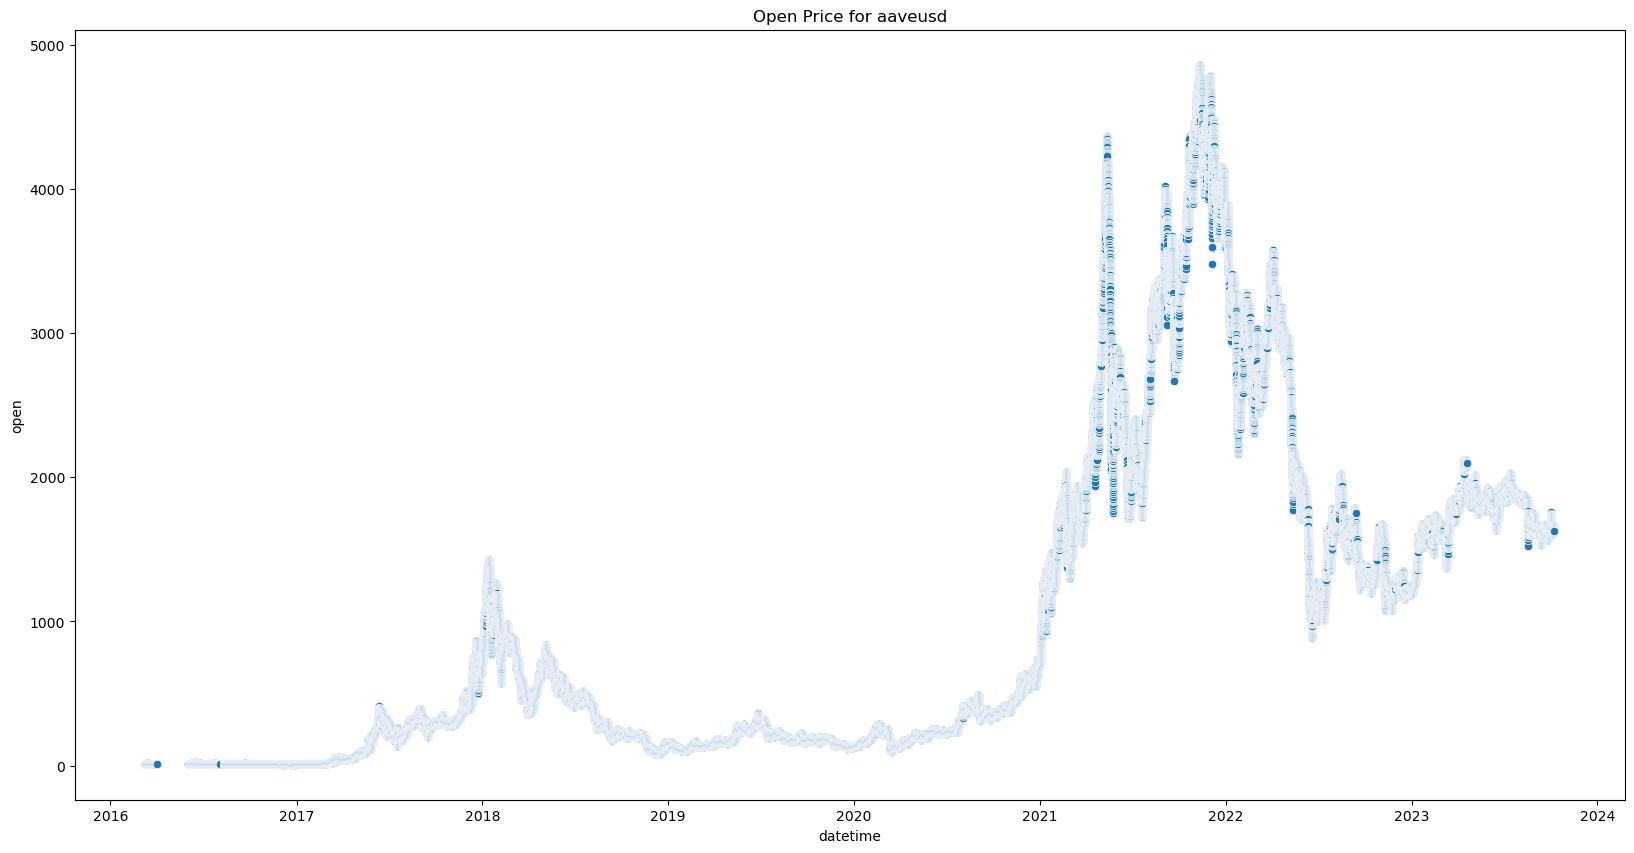

In [20]:
## plot aaveusd open price data

ethusd = all_time[all_time['normalized_currency'] == 'ethusd']
plt.figure(figsize = (20,10))
plt.title('Open Price for aaveusd')
sns.scatterplot(data=ethusd,x = 'datetime',y = 'open')
plt.show()

The begin of the time in datasets with _ is 2023-06-03 06:59:00
The end of the time in datasets with _ is 2023-06-11 13:04:00


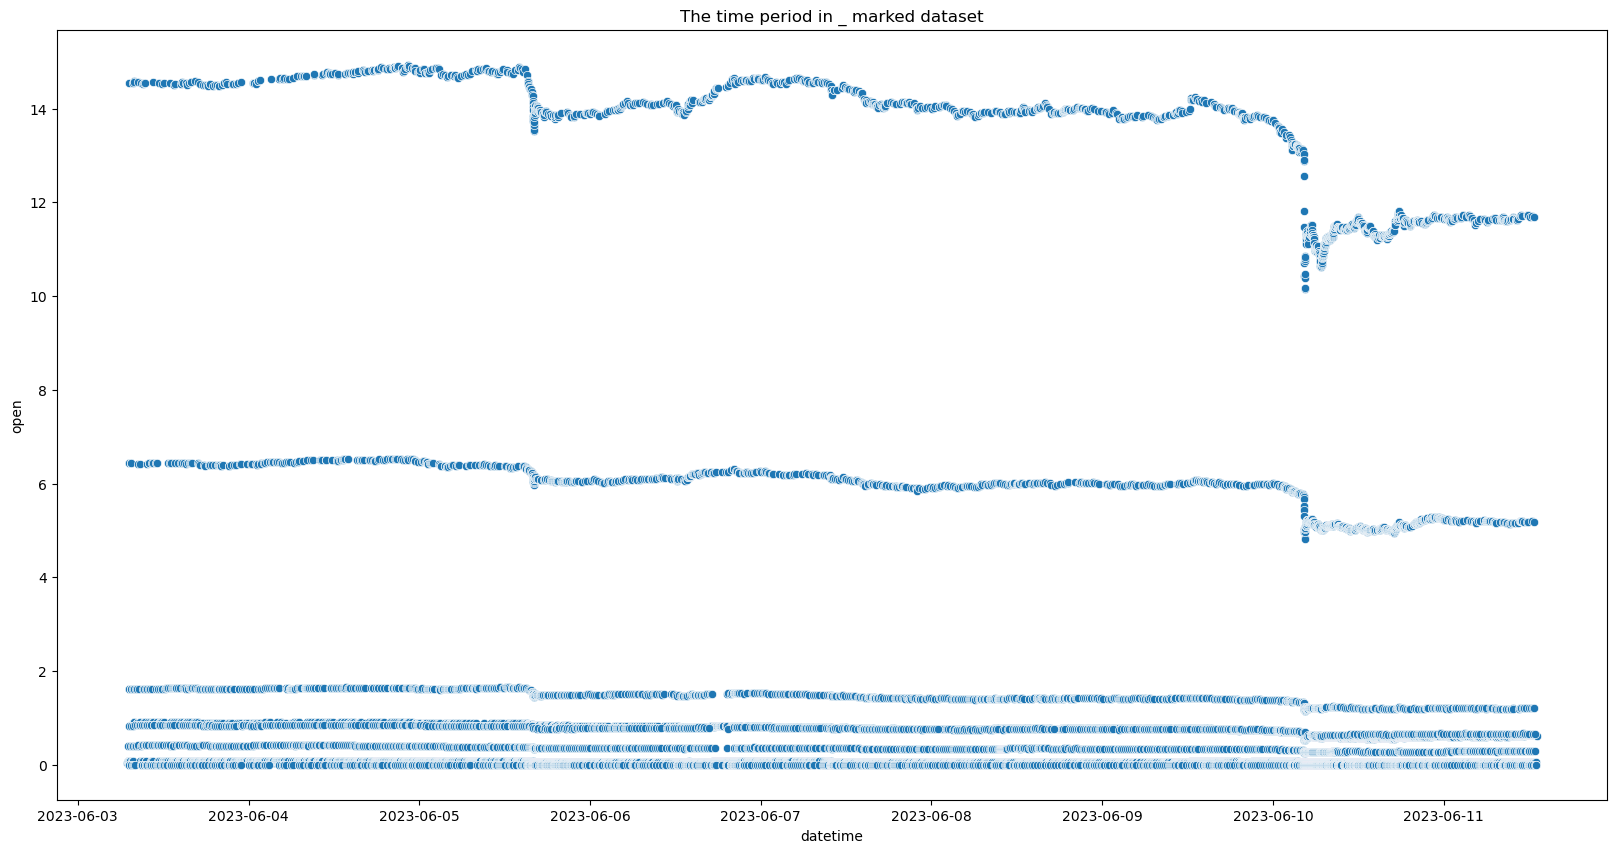

In [21]:
## plot datasets with underscore marker in the file name

underline = all_time[all_time['marker'] == '_']
print('The begin of the time in datasets with _ is '+str(min(underline['datetime'])))
print('The end of the time in datasets with _ is '+str(max(underline['datetime'])))
plt.figure(figsize = (20,10))
plt.title('The time period in _ marked dataset')
sns.scatterplot(data=underline,x = 'datetime',y = 'open')
plt.show()

The begin of the time in datasets with - is 2021-08-10 19:18:00
The end of the time in datasets with - is 2021-08-29 13:18:00


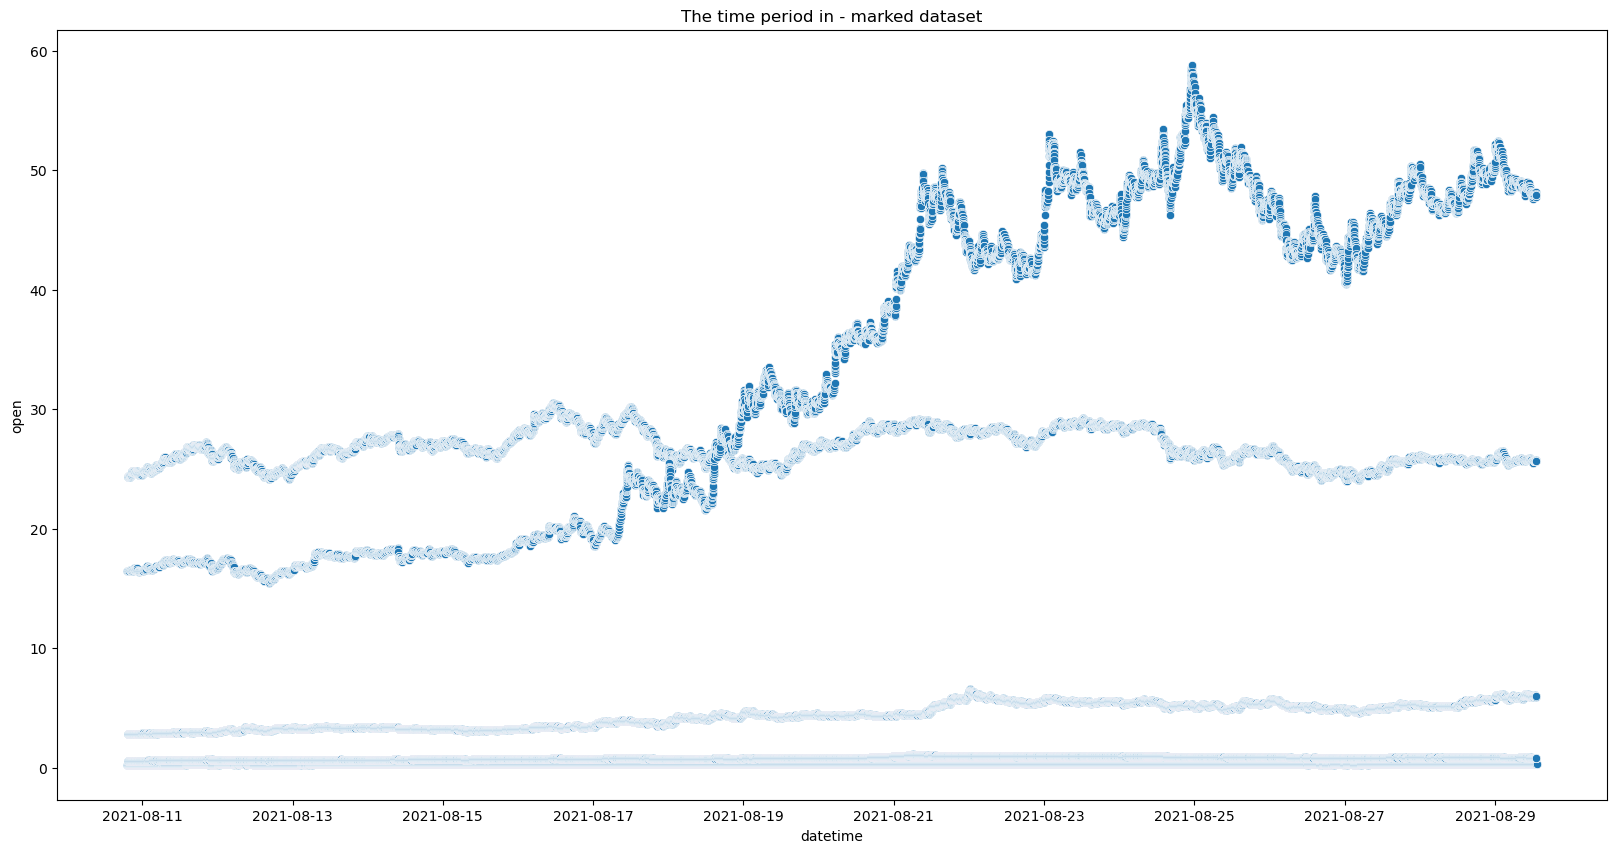

In [22]:
## plot datasets with hyphen marker in the file name

dash = all_time[all_time['marker'] == '-']
print('The begin of the time in datasets with - is '+str(min(dash['datetime'])))
print('The end of the time in datasets with - is '+str(max(dash['datetime'])))
plt.figure(figsize = (20,10))
plt.title('The time period in - marked dataset')
sns.scatterplot(data=dash,x = 'datetime',y = 'open')
plt.show()

The begin of the time in datasets with no marker is 2013-04-01 00:07:00
The end of the time in datasets with no marker is 2023-10-08 09:28:00


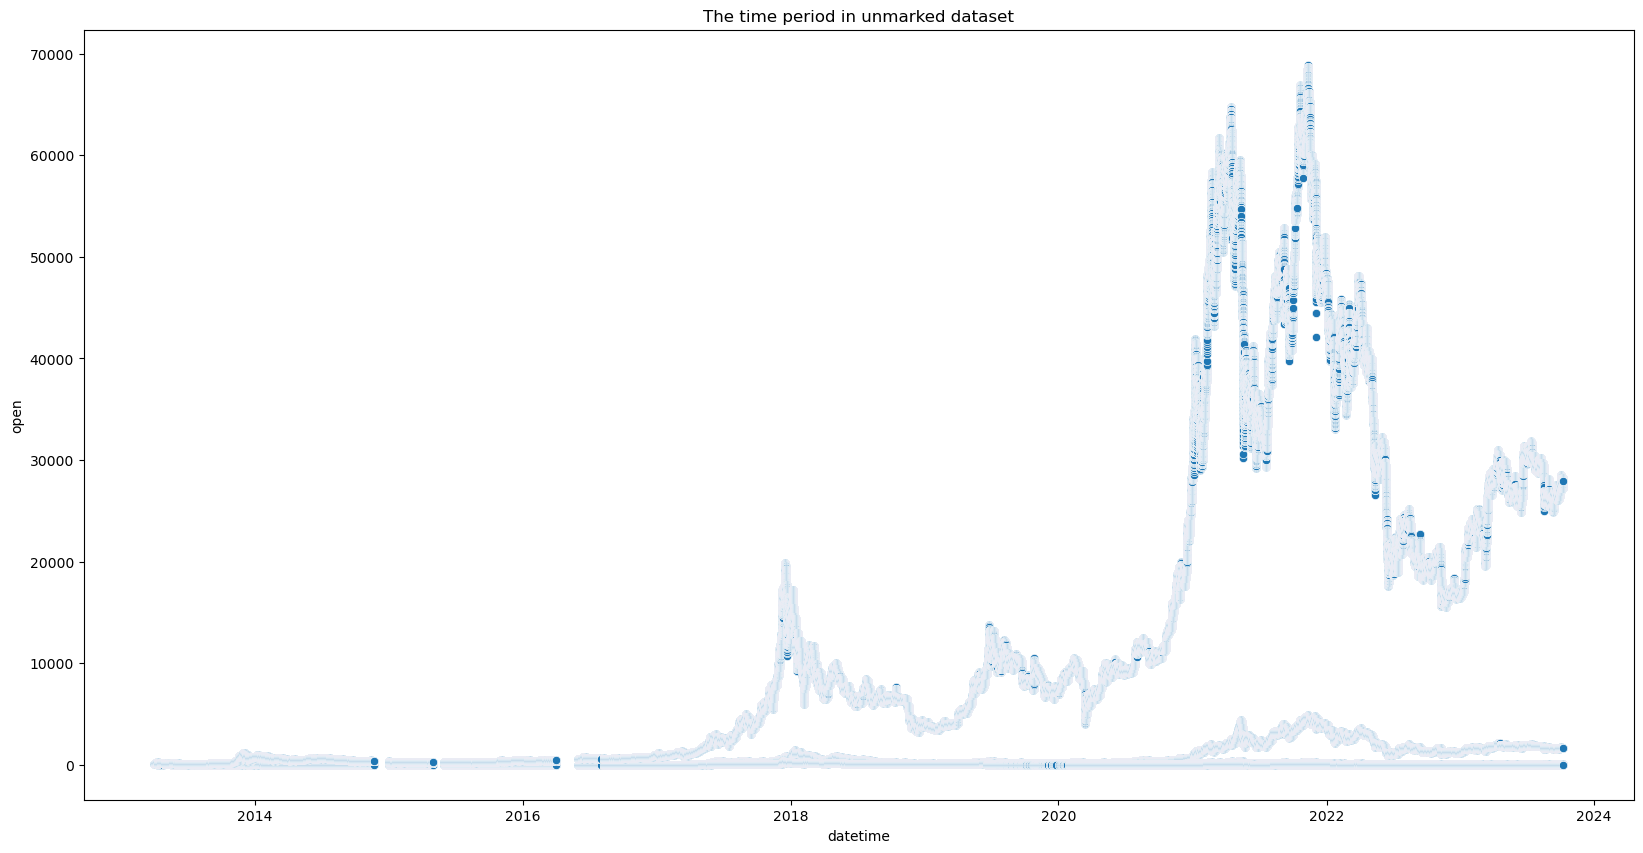

In [23]:
## plot datasets with no marker in the file name

non = all_time[all_time['marker'] == 'non']
print('The begin of the time in datasets with no marker is '+str(min(non['datetime'])))
print('The end of the time in datasets with no marker is '+str(max(non['datetime'])))
plt.figure(figsize = (20,10))
plt.title('The time period in unmarked dataset')
sns.scatterplot(data=non,x = 'datetime',y = 'open')
plt.show()

In the above plot, we do see a potential outlier that could represent erroneous data, as there is a cluster of data points with signficantly higher open price compared to the surrounding times. We will keep this in mind and continue to check for outliers as we move forward.

#### Plot the open price for the first 9 trading pairs

We plot the open price over time for the first 9 trading pairs; from the plots, we can see that the data is not continuous for several pairs.

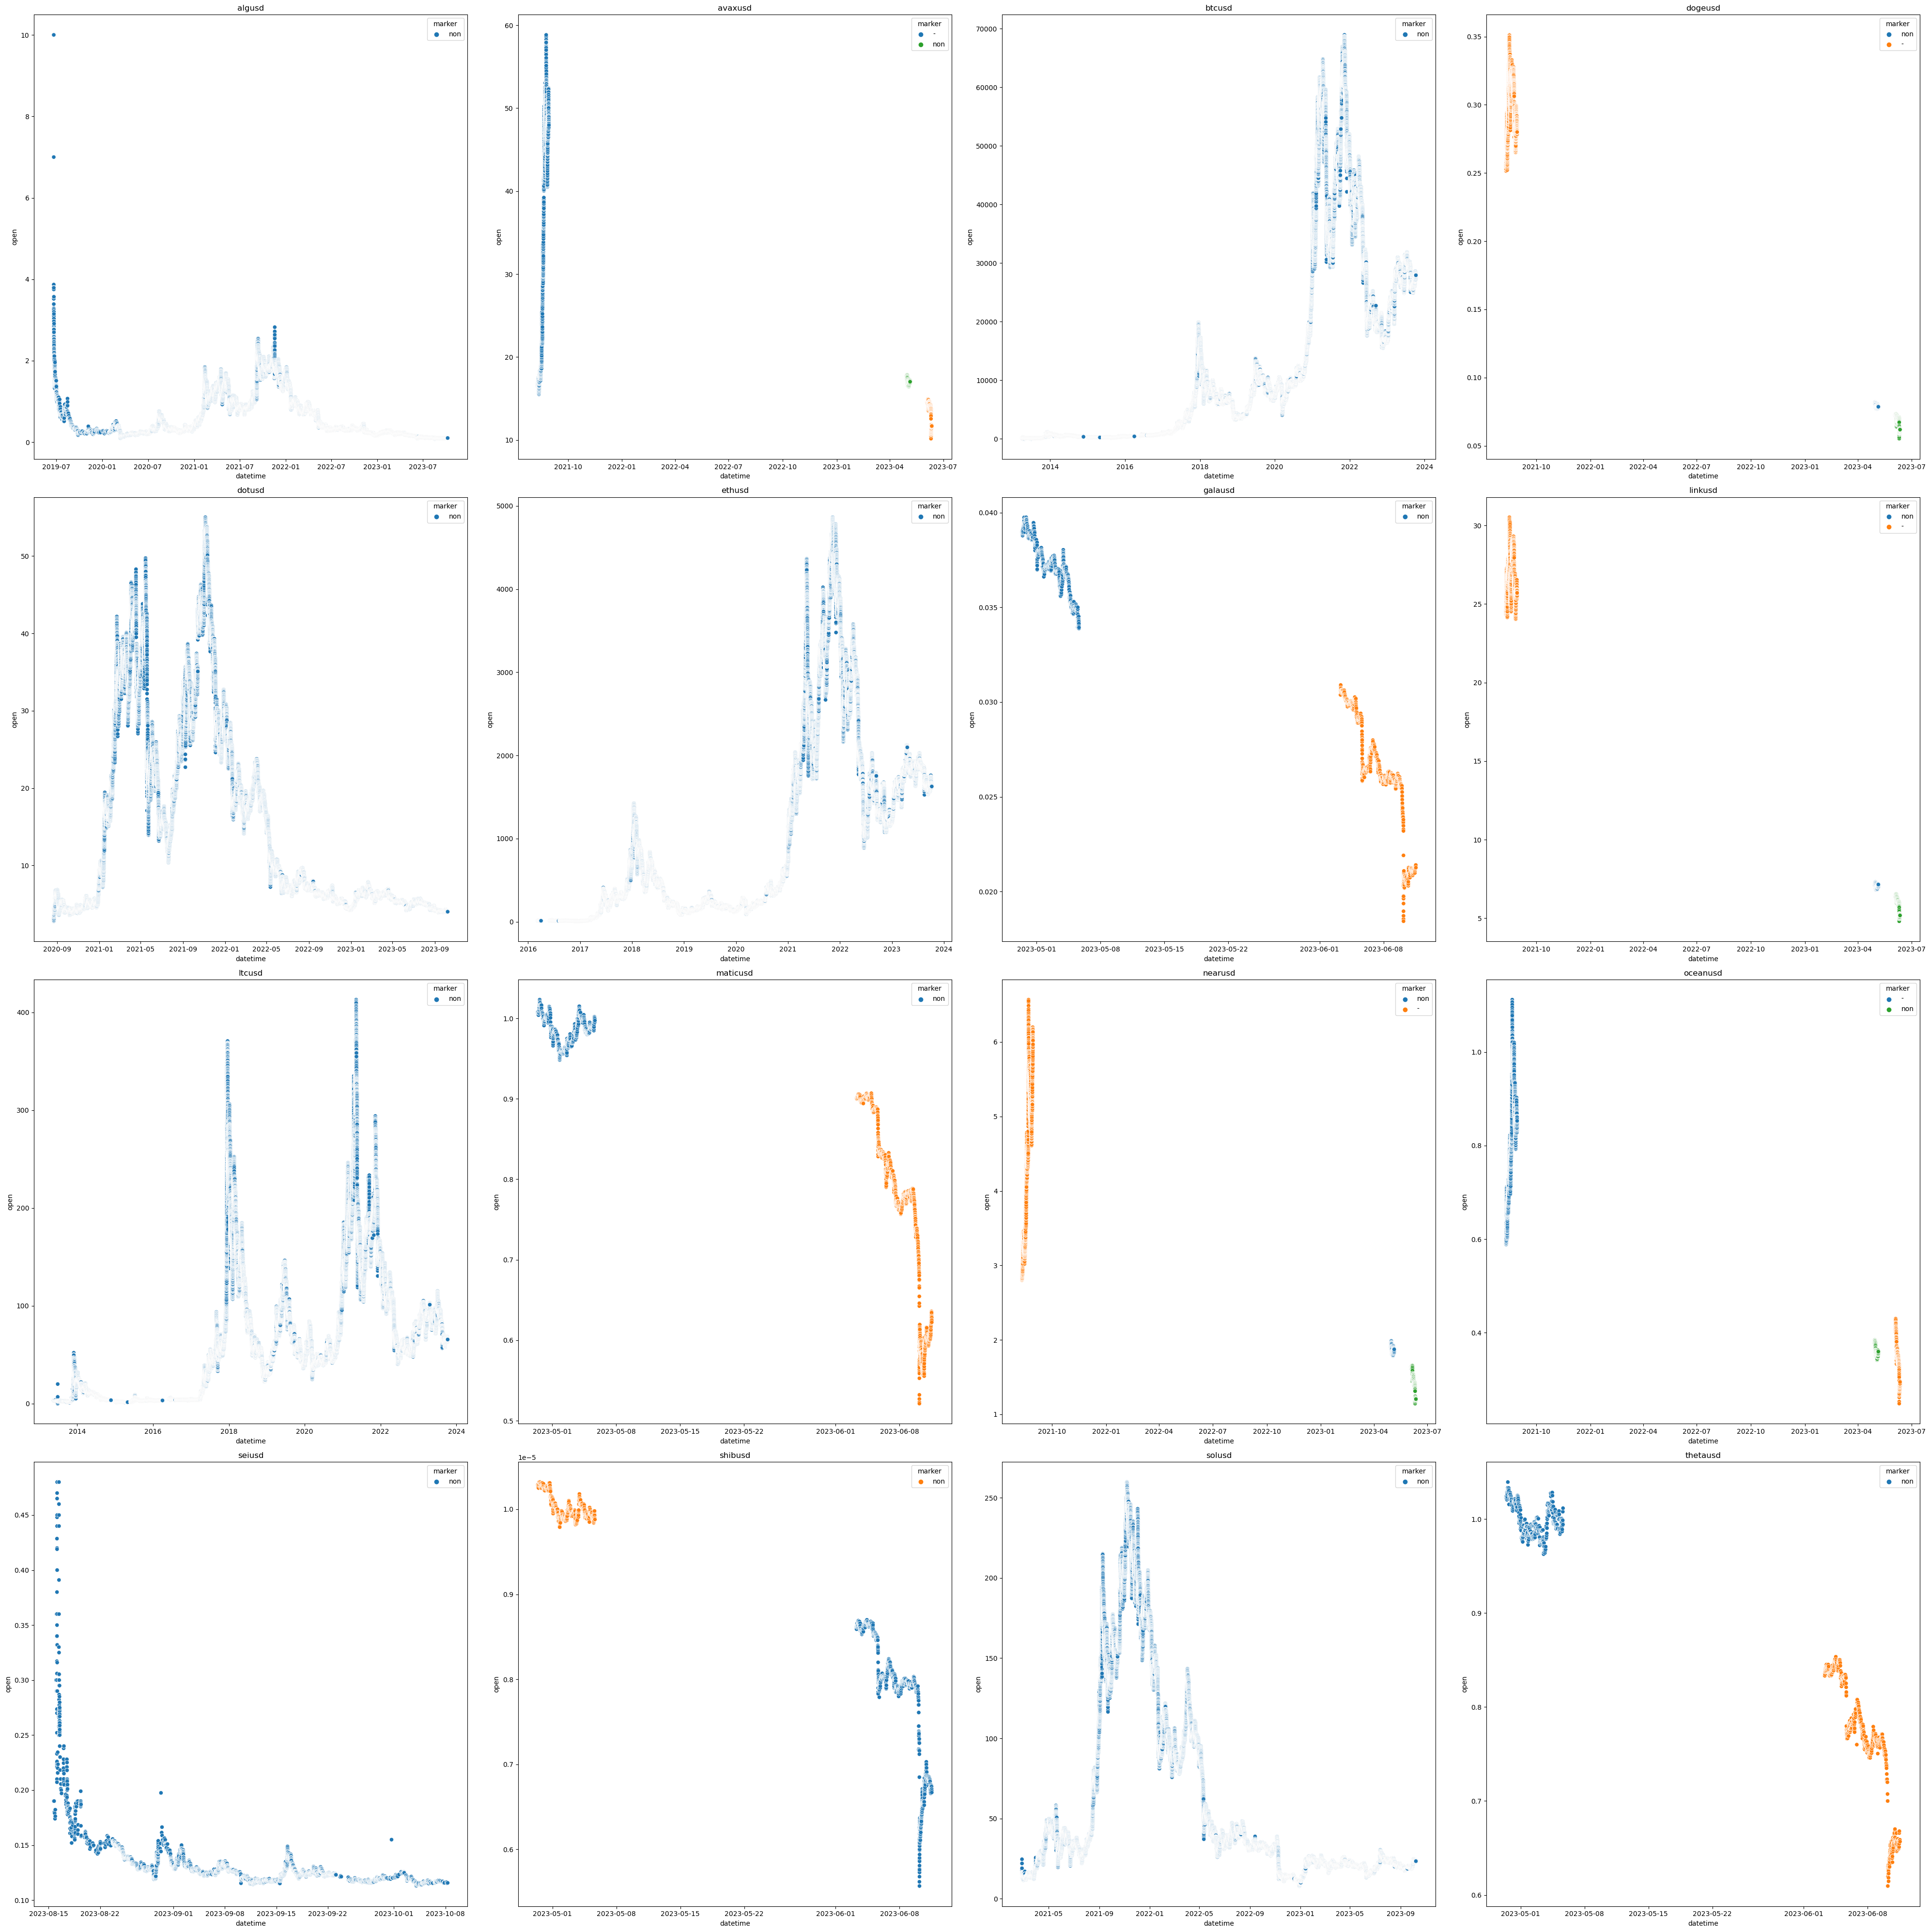

In [28]:
## plot close price vs. time for the first 9 trading pairs

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.lines as mlines

# all_time.reset_index(inplace = True)
cur_df = all_time[all_time.normalized_currency.isin(relevant_pairs)]
cur_df.set_index('normalized_currency',inplace=True)

fig, axes = plt.subplots(4,4,figsize=(40,40))
axes = axes.flatten()
i = 0

for idx, df in cur_df.groupby(cur_df.index):

    sns.scatterplot(data=df,x='datetime',y = 'open',hue = 'marker',ax=axes[i],)

    axes[i].set_title(f'{idx}')
    i += 1

plt.tight_layout()
plt.show()

#### Check if there are abnormal prices

We use Z score to find the outlier for chosen 9 currencies, and find that the volume and close columns both contain outlier for some currencies.

In [26]:
def find_outliers_z_score(data, threshold=3):
    """
    use z score to find outliers

    parameter:
        data: the series needed to inspect
        thereshold: the thereshold of z score
    return:
        outliers_index: inex of the row where outlier exists

    """
    z_scores = (data - np.mean(data)) / np.std(data)
    outliers_index = z_scores[np.abs(z_scores) > threshold].index
    return outliers_index

data_list = ['open','high','low','close','volume']
outlier_df_dic = {}
for idx, df in cur_df.groupby(cur_df.index):
  df.reset_index(inplace = True)
  for i in data_list:
      outliers_index = find_outliers_z_score(df[i])
      # print(outliers_index)
      if len(outliers_index) >0:
        outlier_df = df[df.index.isin(outliers_index)]
        key = (idx,i)
        outlier_df_dic[key] = outlier_df
        print(f'The outlier happens in column {i} in currency {idx}')
        display(outlier_df)

The outlier happens in column open in currency algusd


normalized_currency  level_0   index           time    open   close  \
0                   algusd  6977786       0  1561109520000  3.2000  3.2000   
1                   algusd  6977787       1  1561115520000  3.2000  3.2000   
2                   algusd  6977788       2  1561115580000  3.2000  3.2000   
3                   algusd  6977789       3  1561116060000  3.8000  3.8000   
4                   algusd  6977790       4  1561116480000  3.8000  3.8000   
...                    ...      ...     ...            ...     ...     ...   
300229              algusd  7278015  300229  1637209920000  2.7013  2.4140   
300234              algusd  7278020  300234  1637210220000  2.5767  2.6173   
300235              algusd  7278021  300235  1637210280000  2.7200  2.5970   
300236              algusd  7278022  300236  1637210340000  2.5454  2.5080   
300237              algusd  7278023  300237  1637210400000  2.6380  2.4199   

          high     low        volume     cur marker            datetime  
0       3.2000  3.2000      1.000000  algusd    non 2019-06-21 09:32:00  
1       3.2000  3.2000      1.000000  algusd    non 2019-06-21 11:12:00  
2       3.2000  3.2000      9.835101  algusd    non 2019-06-21 11:13:00  
3       3.8000  3.8000      1.000000  algusd    non 2019-06-21 11:21:00  
4       3.8000  3.8000      1.000000  algusd    non 2019-06-21 11:28:00  
...        ...     ...           ...     ...    ...                 ...  
300229  2.7176  2.4123  12812.680211  algusd    non 2021-11-18 04:32:00  
300234  2.8874  2.5732  26988.174793  algusd    non 2021-11-18 04:37:00  
300235  2.7774  2.5341   7153.119165  algusd    non 2021-11-18 04:38:00  
300236  2.6403  2.2353  39131.119668  algusd    non 2021-11-18 04:39:00  
300237  2.6435  2.4151  27871.812650  algusd    non 2021-11-18 04:40:00  

[154 rows x 12 columns]

The outlier happens in column high in currency algusd


normalized_currency  level_0   index           time    open   close  \
0                   algusd  6977786       0  1561109520000  3.2000  3.2000   
1                   algusd  6977787       1  1561115520000  3.2000  3.2000   
2                   algusd  6977788       2  1561115580000  3.2000  3.2000   
3                   algusd  6977789       3  1561116060000  3.8000  3.8000   
4                   algusd  6977790       4  1561116480000  3.8000  3.8000   
...                    ...      ...     ...            ...     ...     ...   
300233              algusd  7278019  300233  1637210160000  2.3962  2.5766   
300234              algusd  7278020  300234  1637210220000  2.5767  2.6173   
300235              algusd  7278021  300235  1637210280000  2.7200  2.5970   
300236              algusd  7278022  300236  1637210340000  2.5454  2.5080   
300237              algusd  7278023  300237  1637210400000  2.6380  2.4199   

          high     low        volume     cur marker            datetime  
0       3.2000  3.2000      1.000000  algusd    non 2019-06-21 09:32:00  
1       3.2000  3.2000      1.000000  algusd    non 2019-06-21 11:12:00  
2       3.2000  3.2000      9.835101  algusd    non 2019-06-21 11:13:00  
3       3.8000  3.8000      1.000000  algusd    non 2019-06-21 11:21:00  
4       3.8000  3.8000      1.000000  algusd    non 2019-06-21 11:28:00  
...        ...     ...           ...     ...    ...                 ...  
300233  2.5768  2.3765   4279.329829  algusd    non 2021-11-18 04:36:00  
300234  2.8874  2.5732  26988.174793  algusd    non 2021-11-18 04:37:00  
300235  2.7774  2.5341   7153.119165  algusd    non 2021-11-18 04:38:00  
300236  2.6403  2.2353  39131.119668  algusd    non 2021-11-18 04:39:00  
300237  2.6435  2.4151  27871.812650  algusd    non 2021-11-18 04:40:00  

[160 rows x 12 columns]

The outlier happens in column low in currency algusd


normalized_currency  level_0   index           time    open   close  \
0                   algusd  6977786       0  1561109520000  3.2000  3.2000   
1                   algusd  6977787       1  1561115520000  3.2000  3.2000   
2                   algusd  6977788       2  1561115580000  3.2000  3.2000   
3                   algusd  6977789       3  1561116060000  3.8000  3.8000   
4                   algusd  6977790       4  1561116480000  3.8000  3.8000   
...                    ...      ...     ...            ...     ...     ...   
247238              algusd  7225024  247238  1631493180000  2.5421  2.5171   
300227              algusd  7278013  300227  1637209800000  2.5796  2.8560   
300228              algusd  7278014  300228  1637209860000  2.8235  2.6521   
300234              algusd  7278020  300234  1637210220000  2.5767  2.6173   
300235              algusd  7278021  300235  1637210280000  2.7200  2.5970   

          high     low        volume     cur marker            datetime  
0       3.2000  3.2000      1.000000  algusd    non 2019-06-21 09:32:00  
1       3.2000  3.2000      1.000000  algusd    non 2019-06-21 11:12:00  
2       3.2000  3.2000      9.835101  algusd    non 2019-06-21 11:13:00  
3       3.8000  3.8000      1.000000  algusd    non 2019-06-21 11:21:00  
4       3.8000  3.8000      1.000000  algusd    non 2019-06-21 11:28:00  
...        ...     ...           ...     ...    ...                 ...  
247238  2.5421  2.5137   9204.785709  algusd    non 2021-09-13 00:33:00  
300227  2.8560  2.5390  35398.674402  algusd    non 2021-11-18 04:30:00  
300228  2.8413  2.6521  19696.792505  algusd    non 2021-11-18 04:31:00  
300234  2.8874  2.5732  26988.174793  algusd    non 2021-11-18 04:37:00  
300235  2.7774  2.5341   7153.119165  algusd    non 2021-11-18 04:38:00  

[150 rows x 12 columns]

The outlier happens in column close in currency algusd


normalized_currency  level_0   index           time    open   close  \
0                   algusd  6977786       0  1561109520000  3.2000  3.2000   
1                   algusd  6977787       1  1561115520000  3.2000  3.2000   
2                   algusd  6977788       2  1561115580000  3.2000  3.2000   
3                   algusd  6977789       3  1561116060000  3.8000  3.8000   
4                   algusd  6977790       4  1561116480000  3.8000  3.8000   
...                    ...      ...     ...            ...     ...     ...   
300228              algusd  7278014  300228  1637209860000  2.8235  2.6521   
300233              algusd  7278019  300233  1637210160000  2.3962  2.5766   
300234              algusd  7278020  300234  1637210220000  2.5767  2.6173   
300235              algusd  7278021  300235  1637210280000  2.7200  2.5970   
300236              algusd  7278022  300236  1637210340000  2.5454  2.5080   

          high     low        volume     cur marker            datetime  
0       3.2000  3.2000      1.000000  algusd    non 2019-06-21 09:32:00  
1       3.2000  3.2000      1.000000  algusd    non 2019-06-21 11:12:00  
2       3.2000  3.2000      9.835101  algusd    non 2019-06-21 11:13:00  
3       3.8000  3.8000      1.000000  algusd    non 2019-06-21 11:21:00  
4       3.8000  3.8000      1.000000  algusd    non 2019-06-21 11:28:00  
...        ...     ...           ...     ...    ...                 ...  
300228  2.8413  2.6521  19696.792505  algusd    non 2021-11-18 04:31:00  
300233  2.5768  2.3765   4279.329829  algusd    non 2021-11-18 04:36:00  
300234  2.8874  2.5732  26988.174793  algusd    non 2021-11-18 04:37:00  
300235  2.7774  2.5341   7153.119165  algusd    non 2021-11-18 04:38:00  
300236  2.6403  2.2353  39131.119668  algusd    non 2021-11-18 04:39:00  

[156 rows x 12 columns]

The outlier happens in column volume in currency algusd


normalized_currency  level_0   index           time      open  \
2655                algusd  6980441    2655  1582147080000  0.365690   
3368                algusd  6981154    3368  1583748960000  0.285350   
3515                algusd  6981301    3515  1584009720000  0.194300   
3524                algusd  6981310    3524  1584010260000  0.179950   
3527                algusd  6981313    3527  1584010560000  0.188090   
...                    ...      ...     ...            ...       ...   
680037              algusd  7657823  680037  1696090620000  0.104580   
680478              algusd  7658264  680478  1696410240000  0.099119   
680627              algusd  7658413  680627  1696528740000  0.098960   
680690              algusd  7658476  680690  1696569720000  0.099214   
680888              algusd  7658674  680888  1696743180000  0.099431   

           close      high       low        volume     cur marker  \
2655    0.252800  0.365690  0.252800  25397.768274  algusd    non   
3368    0.287170  0.287170  0.285350  25000.000000  algusd    non   
3515    0.193080  0.194300  0.189890  23392.667522  algusd    non   
3524    0.188930  0.188930  0.179950  25927.496132  algusd    non   
3527    0.191730  0.191730  0.188090  23938.668989  algusd    non   
...          ...       ...       ...           ...     ...    ...   
680037  0.104630  0.104630  0.104580  19330.687946  algusd    non   
680478  0.098970  0.099119  0.098970  29355.997000  algusd    non   
680627  0.098744  0.098960  0.098744  21217.755687  algusd    non   
680690  0.099214  0.099214  0.099214  88948.012715  algusd    non   
680888  0.099387  0.099431  0.099387  20878.550582  algusd    non   

                  datetime  
2655   2020-02-19 21:18:00  
3368   2020-03-09 10:16:00  
3515   2020-03-12 10:42:00  
3524   2020-03-12 10:51:00  
3527   2020-03-12 10:56:00  
...                    ...  
680037 2023-09-30 16:17:00  
680478 2023-10-04 09:04:00  
680627 2023-10-05 17:59:00  
680690 2023-10-06 05:22:00  
680888 2023-10-08 05:33:00  

[8624 rows x 12 columns]

The outlier happens in column volume in currency avaxusd


normalized_currency   level_0  index           time    open   close  \
28                avaxusd  12197840     28  1628632740000  16.545  16.544   
282               avaxusd  12198094    282  1628718480000  17.162  17.100   
283               avaxusd  12198095    283  1628718540000  17.168  17.100   
284               avaxusd  12198096    284  1628718600000  17.113  17.100   
285               avaxusd  12198097    285  1628718660000  17.100  17.100   
...                   ...       ...    ...            ...     ...     ...   
10318             avaxusd  12208130    873  1686371160000  10.436  10.227   
10336             avaxusd  12208148    891  1686372240000  11.308  11.281   
10348             avaxusd  12208160    903  1686373140000  11.171  11.141   
11279             avaxusd  12209091    405  1683031500000  16.716  16.716   
11423             avaxusd  12209235    549  1683137880000  16.917  16.922   

         high     low       volume       cur marker            datetime  
28     16.545  16.544  3499.354721  avax-usd      - 2021-08-10 21:59:00  
282    17.162  17.100  2000.000000  avax-usd      - 2021-08-11 21:48:00  
283    17.168  17.100  2658.648000  avax-usd      - 2021-08-11 21:49:00  
284    17.113  17.100  2605.191346  avax-usd      - 2021-08-11 21:50:00  
285    17.120  17.100  3394.808654  avax-usd      - 2021-08-11 21:51:00  
...       ...     ...          ...       ...    ...                 ...  
10318  10.455  10.185  1716.338422  avax_usd      _ 2023-06-10 04:26:00  
10336  11.308  11.105  1375.652567  avax_usd      _ 2023-06-10 04:44:00  
10348  11.171  11.133  1985.192892  avax_usd      _ 2023-06-10 04:59:00  
11279  16.716  16.716  1379.930007   avaxusd    non 2023-05-02 12:45:00  
11423  16.922  16.917  1379.557634   avaxusd    non 2023-05-03 18:18:00  

[150 rows x 12 columns]

The outlier happens in column open in currency btcusd


normalized_currency   level_0    index           time          open  \
3294078              btcusd  10952778  3294078  1618302120000  62419.000000   
3294080              btcusd  10952780  3294080  1618302240000  62415.000000   
3294087              btcusd  10952787  3294087  1618302660000  62496.429863   
3294088              btcusd  10952788  3294088  1618302720000  62590.000000   
3294089              btcusd  10952789  3294089  1618302780000  62483.000000   
...                     ...       ...      ...            ...           ...   
3604001              btcusd  11262701  3604001  1637024340000  62465.000000   
3604002              btcusd  11262702  3604002  1637024400000  62507.000000   
3604003              btcusd  11262703  3604003  1637024460000  62464.000000   
3604004              btcusd  11262704  3604004  1637024520000  62416.592242   
3604005              btcusd  11262705  3604005  1637024580000  62441.385669   

                close          high      low      volume     cur marker  \
3294078  62324.455086  62500.000000  62187.0   37.465921  btcusd    non   
3294080  62172.000000  62438.000000  62061.0   53.647687  btcusd    non   
3294087  62591.000000  62596.000000  62496.0   83.813185  btcusd    non   
3294088  62508.000000  62605.914050  62443.0   27.057055  btcusd    non   
3294089  62573.000000  62633.285097  62480.0   18.686668  btcusd    non   
...               ...           ...      ...         ...     ...    ...   
3604001  62507.000000  62587.632779  62465.0    3.680262  btcusd    non   
3604002  62462.000000  62595.514359  62455.0    5.899603  btcusd    non   
3604003  62413.000000  62480.000000  62300.0   25.811246  btcusd    non   
3604004  62441.000000  62568.000000  62392.0   13.413352  btcusd    non   
3604005  61858.000000  62441.385669  61555.0  555.839808  btcusd    non   

                   datetime  
3294078 2021-04-13 08:22:00  
3294080 2021-04-13 08:24:00  
3294087 2021-04-13 08:31:00  
3294088 2021-04-13 08:32:00  
3294089 2021-04-13 08:33:00  
...                     ...  
3604001 2021-11-16 00:59:00  
3604002 2021-11-16 01:00:00  
3604003 2021-11-16 01:01:00  
3604004 2021-11-16 01:02:00  
3604005 2021-11-16 01:03:00  

[24498 rows x 12 columns]

The outlier happens in column high in currency btcusd


normalized_currency   level_0    index           time          open  \
3294077              btcusd  10952777  3294077  1618302060000  62323.300260   
3294078              btcusd  10952778  3294078  1618302120000  62419.000000   
3294079              btcusd  10952779  3294079  1618302180000  62323.000000   
3294086              btcusd  10952786  3294086  1618302600000  62412.000000   
3294087              btcusd  10952787  3294087  1618302660000  62496.429863   
...                     ...       ...      ...            ...           ...   
3604000              btcusd  11262700  3604000  1637024280000  62665.000000   
3604001              btcusd  11262701  3604001  1637024340000  62465.000000   
3604002              btcusd  11262702  3604002  1637024400000  62507.000000   
3604003              btcusd  11262703  3604003  1637024460000  62464.000000   
3604004              btcusd  11262704  3604004  1637024520000  62416.592242   

                close          high      low     volume     cur marker  \
3294077  62434.000000  62479.000000  62180.0  46.643101  btcusd    non   
3294078  62324.455086  62500.000000  62187.0  37.465921  btcusd    non   
3294079  62416.000000  62475.000000  62322.0  46.668657  btcusd    non   
3294086  62496.429863  62496.429863  62400.0  72.929548  btcusd    non   
3294087  62591.000000  62596.000000  62496.0  83.813185  btcusd    non   
...               ...           ...      ...        ...     ...    ...   
3604000  62454.000000  62665.000000  62434.0  23.739884  btcusd    non   
3604001  62507.000000  62587.632779  62465.0   3.680262  btcusd    non   
3604002  62462.000000  62595.514359  62455.0   5.899603  btcusd    non   
3604003  62413.000000  62480.000000  62300.0  25.811246  btcusd    non   
3604004  62441.000000  62568.000000  62392.0  13.413352  btcusd    non   

                   datetime  
3294077 2021-04-13 08:21:00  
3294078 2021-04-13 08:22:00  
3294079 2021-04-13 08:23:00  
3294086 2021-04-13 08:30:00  
3294087 2021-04-13 08:31:00  
...                     ...  
3604000 2021-11-16 00:58:00  
3604001 2021-11-16 00:59:00  
3604002 2021-11-16 01:00:00  
3604003 2021-11-16 01:01:00  
3604004 2021-11-16 01:02:00  

[24435 rows x 12 columns]

The outlier happens in column low in currency btcusd


normalized_currency   level_0    index           time          open  \
3294086              btcusd  10952786  3294086  1618302600000  62412.000000   
3294087              btcusd  10952787  3294087  1618302660000  62496.429863   
3294088              btcusd  10952788  3294088  1618302720000  62590.000000   
3294089              btcusd  10952789  3294089  1618302780000  62483.000000   
3294091              btcusd  10952791  3294091  1618302900000  62482.000000   
...                     ...       ...      ...            ...           ...   
3603999              btcusd  11262699  3603999  1637024220000  62636.000000   
3604000              btcusd  11262700  3604000  1637024280000  62665.000000   
3604001              btcusd  11262701  3604001  1637024340000  62465.000000   
3604002              btcusd  11262702  3604002  1637024400000  62507.000000   
3604004              btcusd  11262704  3604004  1637024520000  62416.592242   

                close          high      low     volume     cur marker  \
3294086  62496.429863  62496.429863  62400.0  72.929548  btcusd    non   
3294087  62591.000000  62596.000000  62496.0  83.813185  btcusd    non   
3294088  62508.000000  62605.914050  62443.0  27.057055  btcusd    non   
3294089  62573.000000  62633.285097  62480.0  18.686668  btcusd    non   
3294091  62419.000000  62563.000000  62395.0   9.721318  btcusd    non   
...               ...           ...      ...        ...     ...    ...   
3603999  62666.000000  62669.951511  62602.0   7.565697  btcusd    non   
3604000  62454.000000  62665.000000  62434.0  23.739884  btcusd    non   
3604001  62507.000000  62587.632779  62465.0   3.680262  btcusd    non   
3604002  62462.000000  62595.514359  62455.0   5.899603  btcusd    non   
3604004  62441.000000  62568.000000  62392.0  13.413352  btcusd    non   

                   datetime  
3294086 2021-04-13 08:30:00  
3294087 2021-04-13 08:31:00  
3294088 2021-04-13 08:32:00  
3294089 2021-04-13 08:33:00  
3294091 2021-04-13 08:35:00  
...                     ...  
3603999 2021-11-16 00:57:00  
3604000 2021-11-16 00:58:00  
3604001 2021-11-16 00:59:00  
3604002 2021-11-16 01:00:00  
3604004 2021-11-16 01:02:00  

[24554 rows x 12 columns]

The outlier happens in column close in currency btcusd


normalized_currency   level_0    index           time          open  \
3294077              btcusd  10952777  3294077  1618302060000  62323.300260   
3294079              btcusd  10952779  3294079  1618302180000  62323.000000   
3294086              btcusd  10952786  3294086  1618302600000  62412.000000   
3294087              btcusd  10952787  3294087  1618302660000  62496.429863   
3294088              btcusd  10952788  3294088  1618302720000  62590.000000   
...                     ...       ...      ...            ...           ...   
3603999              btcusd  11262699  3603999  1637024220000  62636.000000   
3604000              btcusd  11262700  3604000  1637024280000  62665.000000   
3604001              btcusd  11262701  3604001  1637024340000  62465.000000   
3604002              btcusd  11262702  3604002  1637024400000  62507.000000   
3604004              btcusd  11262704  3604004  1637024520000  62416.592242   

                close          high      low     volume     cur marker  \
3294077  62434.000000  62479.000000  62180.0  46.643101  btcusd    non   
3294079  62416.000000  62475.000000  62322.0  46.668657  btcusd    non   
3294086  62496.429863  62496.429863  62400.0  72.929548  btcusd    non   
3294087  62591.000000  62596.000000  62496.0  83.813185  btcusd    non   
3294088  62508.000000  62605.914050  62443.0  27.057055  btcusd    non   
...               ...           ...      ...        ...     ...    ...   
3603999  62666.000000  62669.951511  62602.0   7.565697  btcusd    non   
3604000  62454.000000  62665.000000  62434.0  23.739884  btcusd    non   
3604001  62507.000000  62587.632779  62465.0   3.680262  btcusd    non   
3604002  62462.000000  62595.514359  62455.0   5.899603  btcusd    non   
3604004  62441.000000  62568.000000  62392.0  13.413352  btcusd    non   

                   datetime  
3294077 2021-04-13 08:21:00  
3294079 2021-04-13 08:23:00  
3294086 2021-04-13 08:30:00  
3294087 2021-04-13 08:31:00  
3294088 2021-04-13 08:32:00  
...                     ...  
3603999 2021-11-16 00:57:00  
3604000 2021-11-16 00:58:00  
3604001 2021-11-16 00:59:00  
3604002 2021-11-16 01:00:00  
3604004 2021-11-16 01:02:00  

[24487 rows x 12 columns]

The outlier happens in column volume in currency btcusd


normalized_currency   level_0    index           time       open  \
24                   btcusd   7658724       24  1364783880000     93.478   
25                   btcusd   7658725       25  1364784000000     93.500   
125                  btcusd   7658825      125  1364827980000    104.900   
143                  btcusd   7658843      143  1364829480000    100.900   
148                  btcusd   7658848      148  1364830020000     99.400   
...                     ...       ...      ...            ...        ...   
4513928              btcusd  12172628  4513928  1695583620000  26488.000   
4514084              btcusd  12172784  4514084  1695598020000  26461.000   
4520507              btcusd  12179207  4520507  1696198620000  27404.000   
4520508              btcusd  12179208  4520508  1696198680000  28042.000   
4520523              btcusd  12179223  4520523  1696199580000  28029.000   

            close         high        low      volume     cur marker  \
24          93.50     93.50000     93.478  200.000000  btcusd    non   
25          93.50     93.50000     93.500  200.000000  btcusd    non   
125        104.60    105.00000    104.000  401.000000  btcusd    non   
143         99.40    100.90000     99.400  230.000000  btcusd    non   
148         98.95     99.77876     98.950  306.758367  btcusd    non   
...           ...          ...        ...         ...     ...    ...   
4513928  26482.00  26488.00000  26393.000  233.840171  btcusd    non   
4514084  26259.00  26461.00000  26258.000  472.958131  btcusd    non   
4520507  28050.00  28050.00000  27404.000  242.531005  btcusd    non   
4520508  27901.00  28050.00000  27900.000  206.588499  btcusd    non   
4520523  28083.00  28105.00000  28029.000  435.466487  btcusd    non   

                   datetime  
24      2013-04-01 02:38:00  
25      2013-04-01 02:40:00  
125     2013-04-01 14:53:00  
143     2013-04-01 15:18:00  
148     2013-04-01 15:27:00  
...                     ...  
4513928 2023-09-24 19:27:00  
4514084 2023-09-24 23:27:00  
4520507 2023-10-01 22:17:00  
4520508 2023-10-01 22:18:00  
4520523 2023-10-01 22:33:00  

[53939 rows x 12 columns]

The outlier happens in column volume in currency dogeusd


normalized_currency  level_0  index           time      open     close  \
1543              dogeusd     7391   1543  1682967180000  0.078315  0.078452   
1544              dogeusd     7392   1544  1682967240000  0.078429  0.078644   
3132              dogeusd     8980   3132  1683179460000  0.079533  0.079600   
3746              dogeusd     9594   3746  1683289800000  0.078622  0.077930   
3912              dogeusd     9760     42  1628625660000  0.252840  0.255080   
...                   ...      ...    ...            ...       ...       ...   
33382             dogeusd    39230   3786  1686371100000  0.060101  0.057990   
33383             dogeusd    39231   3787  1686371160000  0.057680  0.055180   
33387             dogeusd    39235   3791  1686371400000  0.057931  0.058601   
33395             dogeusd    39243   3799  1686371880000  0.060900  0.060840   
33502             dogeusd    39350   3906  1686378660000  0.060218  0.060156   

           high       low        volume       cur marker            datetime  
1543   0.078886  0.078315  1.702691e+06   dogeusd    non 2023-05-01 18:53:00  
1544   0.078644  0.078380  4.668895e+05   dogeusd    non 2023-05-01 18:54:00  
3132   0.079689  0.079533  6.701998e+05   dogeusd    non 2023-05-04 05:51:00  
3746   0.078757  0.077000  4.588453e+05   dogeusd    non 2023-05-05 12:30:00  
3912   0.255080  0.252840  4.614351e+05  doge-usd      - 2021-08-10 20:01:00  
...         ...       ...           ...       ...    ...                 ...  
33382  0.060884  0.057697  7.585881e+05  doge_usd      _ 2023-06-10 04:25:00  
33383  0.058555  0.053547  1.268048e+06  doge_usd      _ 2023-06-10 04:26:00  
33387  0.058645  0.057745  3.484842e+05  doge_usd      _ 2023-06-10 04:30:00  
33395  0.060919  0.060648  3.793114e+05  doge_usd      _ 2023-06-10 04:38:00  
33502  0.060296  0.060146  4.603163e+05  doge_usd      _ 2023-06-10 06:31:00  

[400 rows x 12 columns]

The outlier happens in column volume in currency dotusd


normalized_currency   level_0   index           time    open   close  \
16                  dotusd  12209504      16  1598050500000  3.0531  2.9775   
19                  dotusd  12209507      19  1598051040000  3.0300  2.9507   
21                  dotusd  12209509      21  1598051580000  2.9180  2.9180   
23                  dotusd  12209511      23  1598052300000  2.8900  2.8900   
48                  dotusd  12209536      48  1598080620000  3.0633  3.0695   
...                    ...       ...     ...            ...     ...     ...   
897372              dotusd  13106860  897372  1696271940000  4.1645  4.0474   
897765              dotusd  13107253  897765  1696380060000  3.9777  3.9964   
897769              dotusd  13107257  897769  1696380360000  3.9946  3.9947   
897864              dotusd  13107352  897864  1696404120000  4.0401  4.0394   
898423              dotusd  13107911  898423  1696657560000  4.0968  4.0937   

          high     low        volume     cur marker            datetime  
16      3.0531  2.9775  15266.518186  dotusd    non 2020-08-21 22:55:00  
19      3.0300  2.9507   4583.641976  dotusd    non 2020-08-21 23:04:00  
21      2.9180  2.9180   4139.438680  dotusd    non 2020-08-21 23:13:00  
23      2.8900  2.8805   5381.696789  dotusd    non 2020-08-21 23:25:00  
48      3.0757  3.0633   9748.495267  dotusd    non 2020-08-22 07:17:00  
...        ...     ...           ...     ...    ...                 ...  
897372  4.1645  4.0474  13369.114043  dotusd    non 2023-10-02 18:39:00  
897765  4.0006  3.9777   9726.361345  dotusd    non 2023-10-04 00:41:00  
897769  3.9995  3.9923   4881.056511  dotusd    non 2023-10-04 00:46:00  
897864  4.0401  4.0394   8340.000000  dotusd    non 2023-10-04 07:22:00  
898423  4.1010  4.0937   9915.744924  dotusd    non 2023-10-07 05:46:00  

[9533 rows x 12 columns]

The outlier happens in column open in currency ethusd


normalized_currency  level_0    index           time    open  \
2368316              ethusd  2419457  2368316  1635849120000  4481.0   
2368520              ethusd  2419661  2368520  1635861360000  4479.4   
2368521              ethusd  2419662  2368521  1635861420000  4481.6   
2368522              ethusd  2419663  2368522  1635861480000  4489.9   
2368523              ethusd  2419664  2368523  1635861540000  4491.0   
...                     ...      ...      ...            ...     ...   
2412822              ethusd  2463963  2412822  1638546480000  4497.2   
2412823              ethusd  2463964  2412823  1638546540000  4490.1   
2420509              ethusd  2471650  2420509  1639008360000  4481.2   
2420510              ethusd  2471651  2420510  1639008420000  4482.1   
2420511              ethusd  2471652  2420511  1639008480000  4480.1   

               close         high          low      volume     cur marker  \
2368316  4469.900000  4481.000000  4469.600000   27.403053  ethusd    non   
2368520  4481.571141  4481.600000  4479.400000   21.118727  ethusd    non   
2368521  4489.544920  4489.890552  4481.600000   32.149090  ethusd    non   
2368522  4490.900000  4490.900000  4482.200000   20.020190  ethusd    non   
2368523  4492.181228  4492.300000  4490.026936   17.360381  ethusd    non   
...              ...          ...          ...         ...     ...    ...   
2412822  4490.000000  4497.200000  4490.000000   47.138538  ethusd    non   
2412823  4479.300000  4490.100000  4477.500000   56.707755  ethusd    non   
2420509  4482.500000  4490.523674  4481.200000  109.421468  ethusd    non   
2420510  4481.806775  4482.800000  4476.162932    9.235506  ethusd    non   
2420511  4475.900000  4480.300000  4473.327549  101.399595  ethusd    non   

                   datetime  
2368316 2021-11-02 10:32:00  
2368520 2021-11-02 13:56:00  
2368521 2021-11-02 13:57:00  
2368522 2021-11-02 13:58:00  
2368523 2021-11-02 13:59:00  
...                     ...  
2412822 2021-12-03 15:48:00  
2412823 2021-12-03 15:49:00  
2420509 2021-12-09 00:06:00  
2420510 2021-12-09 00:07:00  
2420511 2021-12-09 00:08:00  

[22892 rows x 12 columns]

The outlier happens in column high in currency ethusd


normalized_currency  level_0    index           time    open  \
2368315              ethusd  2419456  2368315  1635849060000  4476.9   
2368521              ethusd  2419662  2368521  1635861420000  4481.6   
2368522              ethusd  2419663  2368522  1635861480000  4489.9   
2368523              ethusd  2419664  2368523  1635861540000  4491.0   
2368524              ethusd  2419665  2368524  1635861600000  4491.6   
...                     ...      ...      ...            ...     ...   
2412823              ethusd  2463964  2412823  1638546540000  4490.1   
2420507              ethusd  2471648  2420507  1639008240000  4470.4   
2420508              ethusd  2471649  2420508  1639008300000  4467.7   
2420509              ethusd  2471650  2420509  1639008360000  4481.2   
2420510              ethusd  2471651  2420510  1639008420000  4482.1   

               close         high          low      volume     cur marker  \
2368315  4481.000000  4484.000000  4476.900000   81.730701  ethusd    non   
2368521  4489.544920  4489.890552  4481.600000   32.149090  ethusd    non   
2368522  4490.900000  4490.900000  4482.200000   20.020190  ethusd    non   
2368523  4492.181228  4492.300000  4490.026936   17.360381  ethusd    non   
2368524  4490.900000  4493.900000  4488.200000   53.971405  ethusd    non   
...              ...          ...          ...         ...     ...    ...   
2412823  4479.300000  4490.100000  4477.500000   56.707755  ethusd    non   
2420507  4469.700000  4482.000000  4467.300000  779.211389  ethusd    non   
2420508  4480.926376  4481.900000  4464.715426   69.463585  ethusd    non   
2420509  4482.500000  4490.523674  4481.200000  109.421468  ethusd    non   
2420510  4481.806775  4482.800000  4476.162932    9.235506  ethusd    non   

                   datetime  
2368315 2021-11-02 10:31:00  
2368521 2021-11-02 13:57:00  
2368522 2021-11-02 13:58:00  
2368523 2021-11-02 13:59:00  
2368524 2021-11-02 14:00:00  
...                     ...  
2412823 2021-12-03 15:49:00  
2420507 2021-12-09 00:04:00  
2420508 2021-12-09 00:05:00  
2420509 2021-12-09 00:06:00  
2420510 2021-12-09 00:07:00  

[22851 rows x 12 columns]

The outlier happens in column low in currency ethusd


normalized_currency  level_0    index           time    open  \
2368520              ethusd  2419661  2368520  1635861360000  4479.4   
2368521              ethusd  2419662  2368521  1635861420000  4481.6   
2368522              ethusd  2419663  2368522  1635861480000  4489.9   
2368523              ethusd  2419664  2368523  1635861540000  4491.0   
2368524              ethusd  2419665  2368524  1635861600000  4491.6   
...                     ...      ...      ...            ...     ...   
2412820              ethusd  2463961  2412820  1638546360000  4496.8   
2412821              ethusd  2463962  2412821  1638546420000  4504.1   
2412822              ethusd  2463963  2412822  1638546480000  4497.2   
2412823              ethusd  2463964  2412823  1638546540000  4490.1   
2420509              ethusd  2471650  2420509  1639008360000  4481.2   

               close         high          low      volume     cur marker  \
2368520  4481.571141  4481.600000  4479.400000   21.118727  ethusd    non   
2368521  4489.544920  4489.890552  4481.600000   32.149090  ethusd    non   
2368522  4490.900000  4490.900000  4482.200000   20.020190  ethusd    non   
2368523  4492.181228  4492.300000  4490.026936   17.360381  ethusd    non   
2368524  4490.900000  4493.900000  4488.200000   53.971405  ethusd    non   
...              ...          ...          ...         ...     ...    ...   
2412820  4505.100000  4505.200000  4495.500000   18.591382  ethusd    non   
2412821  4499.100000  4504.400000  4498.800620   13.327618  ethusd    non   
2412822  4490.000000  4497.200000  4490.000000   47.138538  ethusd    non   
2412823  4479.300000  4490.100000  4477.500000   56.707755  ethusd    non   
2420509  4482.500000  4490.523674  4481.200000  109.421468  ethusd    non   

                   datetime  
2368520 2021-11-02 13:56:00  
2368521 2021-11-02 13:57:00  
2368522 2021-11-02 13:58:00  
2368523 2021-11-02 13:59:00  
2368524 2021-11-02 14:00:00  
...                     ...  
2412820 2021-12-03 15:46:00  
2412821 2021-12-03 15:47:00  
2412822 2021-12-03 15:48:00  
2412823 2021-12-03 15:49:00  
2420509 2021-12-09 00:06:00  

[22951 rows x 12 columns]

The outlier happens in column close in currency ethusd


normalized_currency  level_0    index           time    open  \
2368315              ethusd  2419456  2368315  1635849060000  4476.9   
2368520              ethusd  2419661  2368520  1635861360000  4479.4   
2368521              ethusd  2419662  2368521  1635861420000  4481.6   
2368522              ethusd  2419663  2368522  1635861480000  4489.9   
2368523              ethusd  2419664  2368523  1635861540000  4491.0   
...                     ...      ...      ...            ...     ...   
2412821              ethusd  2463962  2412821  1638546420000  4504.1   
2412822              ethusd  2463963  2412822  1638546480000  4497.2   
2420508              ethusd  2471649  2420508  1639008300000  4467.7   
2420509              ethusd  2471650  2420509  1639008360000  4481.2   
2420510              ethusd  2471651  2420510  1639008420000  4482.1   

               close         high          low      volume     cur marker  \
2368315  4481.000000  4484.000000  4476.900000   81.730701  ethusd    non   
2368520  4481.571141  4481.600000  4479.400000   21.118727  ethusd    non   
2368521  4489.544920  4489.890552  4481.600000   32.149090  ethusd    non   
2368522  4490.900000  4490.900000  4482.200000   20.020190  ethusd    non   
2368523  4492.181228  4492.300000  4490.026936   17.360381  ethusd    non   
...              ...          ...          ...         ...     ...    ...   
2412821  4499.100000  4504.400000  4498.800620   13.327618  ethusd    non   
2412822  4490.000000  4497.200000  4490.000000   47.138538  ethusd    non   
2420508  4480.926376  4481.900000  4464.715426   69.463585  ethusd    non   
2420509  4482.500000  4490.523674  4481.200000  109.421468  ethusd    non   
2420510  4481.806775  4482.800000  4476.162932    9.235506  ethusd    non   

                   datetime  
2368315 2021-11-02 10:31:00  
2368520 2021-11-02 13:56:00  
2368521 2021-11-02 13:57:00  
2368522 2021-11-02 13:58:00  
2368523 2021-11-02 13:59:00  
...                     ...  
2412821 2021-12-03 15:47:00  
2412822 2021-12-03 15:48:00  
2420508 2021-12-09 00:05:00  
2420509 2021-12-09 00:06:00  
2420510 2021-12-09 00:07:00  

[22888 rows x 12 columns]

The outlier happens in column volume in currency ethusd


normalized_currency  level_0    index           time      open  \
230                  ethusd    51371      230  1457967360000    13.753   
340                  ethusd    51481      340  1457984220000    13.861   
397                  ethusd    51538      397  1457993880000    13.000   
1767                 ethusd    52908     1767  1458303300000     9.284   
1769                 ethusd    52910     1769  1458303420000     9.284   
...                     ...      ...      ...            ...       ...   
3205048              ethusd  3256189  3205048  1690904040000  1831.000   
3213888              ethusd  3265029  3213888  1692308520000  1662.100   
3218162              ethusd  3269303  3218162  1692765840000  1639.400   
3227215              ethusd  3278356  3227215  1693969860000  1640.300   
3242655              ethusd  3293796  3242655  1695973200000  1684.900   

            close      high       low       volume     cur marker  \
230        13.753    13.754    13.753  1491.244597  ethusd    non   
340        13.595    13.861    13.550  1597.726767  ethusd    non   
397        12.000    13.000    12.000  2791.416559  ethusd    non   
1767        9.284     9.284     9.284  1696.804567  ethusd    non   
1769        9.284     9.284     9.284  1884.635552  ethusd    non   
...           ...       ...       ...          ...     ...    ...   
3205048  1833.400  1833.400  1831.000  1876.174691  ethusd    non   
3213888  1618.300  1662.100  1617.900  1520.584266  ethusd    non   
3218162  1639.400  1639.400  1639.400  1435.500814  ethusd    non   
3227215  1639.700  1640.300  1639.700  1406.279802  ethusd    non   
3242655  1683.400  1685.100  1683.400  1398.522625  ethusd    non   

                   datetime  
230     2016-03-14 14:56:00  
340     2016-03-14 19:37:00  
397     2016-03-14 22:18:00  
1767    2016-03-18 12:15:00  
1769    2016-03-18 12:17:00  
...                     ...  
3205048 2023-08-01 15:34:00  
3213888 2023-08-17 21:42:00  
3218162 2023-08-23 04:44:00  
3227215 2023-09-06 03:11:00  
3242655 2023-09-29 07:40:00  

[32787 rows x 12 columns]

The outlier happens in column volume in currency galausd


normalized_currency  level_0  index           time      open     close  \
840              galausd      840    840  1683221160000  0.035616  0.035510   
1035             galausd     1035   1035  1683300000000  0.034035  0.034012   
1052             galausd     1052      8  1685780640000  0.030609  0.030658   
1055             galausd     1055     11  1685782020000  0.030560  0.030498   
1250             galausd     1250    206  1685933700000  0.029000  0.028871   
1259             galausd     1259    215  1685940480000  0.028903  0.028862   
1284             galausd     1284    240  1685958840000  0.029044  0.029080   
1285             galausd     1285    241  1685958900000  0.029049  0.029089   
1319             galausd     1319    275  1685977440000  0.028767  0.028750   
1322             galausd     1322    278  1685978340000  0.028151  0.028153   
1334             galausd     1334    290  1685980320000  0.027711  0.027601   
1338             galausd     1338    294  1685980680000  0.027024  0.026903   
1342             galausd     1342    298  1685980920000  0.026199  0.026012   
1372             galausd     1372    328  1685984640000  0.026620  0.026590   
1455             galausd     1455    411  1686036000000  0.026450  0.026450   
1466             galausd     1466    422  1686044040000  0.026799  0.026764   
1562             galausd     1562    518  1686050820000  0.026820  0.026827   
1631             galausd     1631    587  1686060720000  0.027462  0.027578   
1642             galausd     1642    598  1686064440000  0.027317  0.027182   
1754             galausd     1754    710  1686131400000  0.026685  0.026685   
1882             galausd     1882    838  1686204180000  0.025718  0.025755   
1886             galausd     1886    842  1686207540000  0.025809  0.025784   
1887             galausd     1887    843  1686207600000  0.025807  0.025777   
2024             galausd     2024    980  1686295680000  0.025726  0.025760   
2041             galausd     2041    997  1686303240000  0.025794  0.025795   
2043             galausd     2043    999  1686303360000  0.025794  0.025794   
2177             galausd     2177   1133  1686370860000  0.023200  0.021939   
2178             galausd     2178   1134  1686370920000  0.021909  0.021086   
2179             galausd     2179   1135  1686370980000  0.020804  0.020565   
2180             galausd     2180   1136  1686371040000  0.020565  0.019600   
2181             galausd     2181   1137  1686371100000  0.019705  0.019145   
2182             galausd     2182   1138  1686371160000  0.018962  0.018746   
2183             galausd     2183   1139  1686371220000  0.018554  0.018419   
2184             galausd     2184   1140  1686371280000  0.018436  0.018713   
2193             galausd     2193   1149  1686371940000  0.020415  0.020373   
2195             galausd     2195   1151  1686372120000  0.020300  0.020190   
2206             galausd     2206   1162  1686372960000  0.020827  0.020894   
2210             galausd     2210   1166  1686373200000  0.020593  0.020512   
2236             galausd     2236   1192  1686376260000  0.020580  0.020544   
2307             galausd     2307   1263  1686396060000  0.020600  0.020611   
2323             galausd     2323   1279  1686402120000  0.020360  0.020280   
2332             galausd     2332   1288  1686408060000  0.020495  0.020473   
2376             galausd     2376   1332  1686429660000  0.020967  0.020947   
2388             galausd     2388   1344  1686439320000  0.021219  0.021201   

          high       low         volume       cur marker            datetime  
840   0.035616  0.035510  333319.815647   galausd    non 2023-05-04 17:26:00  
1035  0.034056  0.034012  251703.613200   galausd    non 2023-05-05 15:20:00  
1052  0.030658  0.030609  592535.119924  gala_usd      _ 2023-06-03 08:24:00  
1055  0.030560  0.030498  592535.119924  gala_usd      _ 2023-06-03 08:47:00  
1250  0.029000  0.028834  395344.578760  gala_usd     

The outlier happens in column volume in currency linkusd


normalized_currency   level_0  index           time     open    close  \
36                linkusd  12185884     36  1682780700000   7.1930   7.1930   
361               linkusd  12186209    361  1682974740000   6.8235   6.8243   
687               linkusd  12186535    687  1683273600000   7.0475   7.0405   
820               linkusd  12186668     94  1628635980000  24.5190  24.4270   
986               linkusd  12186834    260  1628660940000  25.3120  25.3890   
...                   ...       ...    ...            ...      ...      ...   
11455             linkusd  12197303    747  1686371040000   5.3011   5.0330   
11456             linkusd  12197304    748  1686371100000   5.0330   5.0265   
11475             linkusd  12197323    767  1686372300000   5.1381   5.1540   
11597             linkusd  12197445    889  1686385860000   5.1216   5.1175   
11709             linkusd  12197557   1001  1686406380000   4.9938   5.0031   

          high      low       volume       cur marker            datetime  
36      7.1930   7.1930  5451.805706   linkusd    non 2023-04-29 15:05:00  
361     6.8334   6.8235  2457.856414   linkusd    non 2023-05-01 20:59:00  
687     7.0475   7.0405  2457.596340   linkusd    non 2023-05-05 08:00:00  
820    24.5190  24.4160  3488.975491  link-usd      - 2021-08-10 22:53:00  
986    25.3960  25.3110  3081.960165  link-usd      - 2021-08-11 05:49:00  
...        ...      ...          ...       ...    ...                 ...  
11455   5.3056   5.0330  6922.943779  link_usd      _ 2023-06-10 04:24:00  
11456   5.1167   4.9622  4949.757021  link_usd      _ 2023-06-10 04:25:00  
11475   5.1570   5.1381  2565.830850  link_usd      _ 2023-06-10 04:45:00  
11597   5.1300   5.1175  6034.000000  link_usd      _ 2023-06-10 08:31:00  
11709   5.0031   4.9938  2680.589532  link_usd      _ 2023-06-10 14:13:00  

[122 rows x 12 columns]

The outlier happens in column open in currency ltcusd


normalized_currency  level_0    index           time    open   close  \
663173               ltcusd  3964649   663173  1513086480000  293.90  294.10   
663174               ltcusd  3964650   663174  1513086540000  294.43  294.84   
663175               ltcusd  3964651   663175  1513086600000  294.84  291.15   
663176               ltcusd  3964652   663176  1513086660000  293.01  292.00   
663178               ltcusd  3964654   663178  1513086780000  293.80  293.56   
...                     ...      ...      ...            ...     ...     ...   
2227867              ltcusd  5529343  2227867  1636546200000  293.91  292.44   
2228040              ltcusd  5529516  2228040  1636556580000  293.01  293.48   
2228041              ltcusd  5529517  2228041  1636556640000  292.90  292.02   
2228145              ltcusd  5529621  2228145  1636562880000  294.02  294.12   
2228146              ltcusd  5529622  2228146  1636562940000  294.10  292.93   

           high     low       volume     cur marker            datetime  
663173   295.00  292.47  4675.538877  ltcusd    non 2017-12-12 13:48:00  
663174   294.89  291.89  1962.438609  ltcusd    non 2017-12-12 13:49:00  
663175   294.89  291.15  1955.590515  ltcusd    non 2017-12-12 13:50:00  
663176   294.00  291.15  3422.008184  ltcusd    non 2017-12-12 13:51:00  
663178   294.19  291.40  2894.445131  ltcusd    non 2017-12-12 13:53:00  
...         ...     ...          ...     ...    ...                 ...  
2227867  294.87  292.44   783.325724  ltcusd    non 2021-11-10 12:10:00  
2228040  294.23  292.24  3250.165739  ltcusd    non 2021-11-10 15:03:00  
2228041  294.23  291.28  5638.064545  ltcusd    non 2021-11-10 15:04:00  
2228145  295.40  293.10  1626.250294  ltcusd    non 2021-11-10 16:48:00  
2228146  294.10  292.60   545.739601  ltcusd    non 2021-11-10 16:49:00  

[32924 rows x 12 columns]

The outlier happens in column high in currency ltcusd


normalized_currency  level_0    index           time    open   close  \
663170               ltcusd  3964646   663170  1513086300000  292.26  289.56   
663172               ltcusd  3964648   663172  1513086420000  291.27  293.50   
663173               ltcusd  3964649   663173  1513086480000  293.90  294.10   
663174               ltcusd  3964650   663174  1513086540000  294.43  294.84   
663175               ltcusd  3964651   663175  1513086600000  294.84  291.15   
...                     ...      ...      ...            ...     ...     ...   
2228040              ltcusd  5529516  2228040  1636556580000  293.01  293.48   
2228041              ltcusd  5529517  2228041  1636556640000  292.90  292.02   
2228144              ltcusd  5529620  2228144  1636562820000  291.78  294.32   
2228145              ltcusd  5529621  2228145  1636562880000  294.02  294.12   
2228146              ltcusd  5529622  2228146  1636562940000  294.10  292.93   

           high     low       volume     cur marker            datetime  
663170   293.34  288.61  4275.566610  ltcusd    non 2017-12-12 13:45:00  
663172   293.90  291.15  1610.503693  ltcusd    non 2017-12-12 13:47:00  
663173   295.00  292.47  4675.538877  ltcusd    non 2017-12-12 13:48:00  
663174   294.89  291.89  1962.438609  ltcusd    non 2017-12-12 13:49:00  
663175   294.89  291.15  1955.590515  ltcusd    non 2017-12-12 13:50:00  
...         ...     ...          ...     ...    ...                 ...  
2228040  294.23  292.24  3250.165739  ltcusd    non 2021-11-10 15:03:00  
2228041  294.23  291.28  5638.064545  ltcusd    non 2021-11-10 15:04:00  
2228144  294.80  291.69  2297.277769  ltcusd    non 2021-11-10 16:47:00  
2228145  295.40  293.10  1626.250294  ltcusd    non 2021-11-10 16:48:00  
2228146  294.10  292.60   545.739601  ltcusd    non 2021-11-10 16:49:00  

[33037 rows x 12 columns]

The outlier happens in column low in currency ltcusd


normalized_currency  level_0    index           time    open   close  \
663181               ltcusd  3964657   663181  1513086960000  292.98  293.70   
663182               ltcusd  3964658   663182  1513087020000  293.70  294.00   
663183               ltcusd  3964659   663183  1513087080000  294.00  298.00   
663184               ltcusd  3964660   663184  1513087140000  299.00  297.00   
663185               ltcusd  3964661   663185  1513087200000  297.00  298.61   
...                     ...      ...      ...            ...     ...     ...   
2008376              ltcusd  5309852  2008376  1621385040000  293.76  293.61   
2008377              ltcusd  5309853  2008377  1621385100000  294.02  293.01   
2008378              ltcusd  5309854  2008378  1621385160000  292.97  293.16   
2228145              ltcusd  5529621  2228145  1636562880000  294.02  294.12   
2228146              ltcusd  5529622  2228146  1636562940000  294.10  292.93   

           high     low       volume     cur marker            datetime  
663181   294.00  292.69  2078.947886  ltcusd    non 2017-12-12 13:56:00  
663182   294.00  292.81  5829.457136  ltcusd    non 2017-12-12 13:57:00  
663183   299.00  293.70  6447.006618  ltcusd    non 2017-12-12 13:58:00  
663184   300.00  297.00  8369.184811  ltcusd    non 2017-12-12 13:59:00  
663185   300.00  295.00  3980.901425  ltcusd    non 2017-12-12 14:00:00  
...         ...     ...          ...     ...    ...                 ...  
2008376  293.76  293.61    11.706000  ltcusd    non 2021-05-19 00:44:00  
2008377  294.02  293.01     4.435586  ltcusd    non 2021-05-19 00:45:00  
2008378  293.16  292.97     1.111430  ltcusd    non 2021-05-19 00:46:00  
2228145  295.40  293.10  1626.250294  ltcusd    non 2021-11-10 16:48:00  
2228146  294.10  292.60   545.739601  ltcusd    non 2021-11-10 16:49:00  

[32730 rows x 12 columns]

The outlier happens in column close in currency ltcusd


normalized_currency  level_0    index           time    open   close  \
663172               ltcusd  3964648   663172  1513086420000  291.27  293.50   
663173               ltcusd  3964649   663173  1513086480000  293.90  294.10   
663174               ltcusd  3964650   663174  1513086540000  294.43  294.84   
663177               ltcusd  3964653   663177  1513086720000  291.61  293.80   
663178               ltcusd  3964654   663178  1513086780000  293.80  293.56   
...                     ...      ...      ...            ...     ...     ...   
2228039              ltcusd  5529515  2228039  1636556520000  286.40  292.93   
2228040              ltcusd  5529516  2228040  1636556580000  293.01  293.48   
2228144              ltcusd  5529620  2228144  1636562820000  291.78  294.32   
2228145              ltcusd  5529621  2228145  1636562880000  294.02  294.12   
2228146              ltcusd  5529622  2228146  1636562940000  294.10  292.93   

           high     low        volume     cur marker            datetime  
663172   293.90  291.15   1610.503693  ltcusd    non 2017-12-12 13:47:00  
663173   295.00  292.47   4675.538877  ltcusd    non 2017-12-12 13:48:00  
663174   294.89  291.89   1962.438609  ltcusd    non 2017-12-12 13:49:00  
663177   293.88  291.15   2626.872781  ltcusd    non 2017-12-12 13:52:00  
663178   294.19  291.40   2894.445131  ltcusd    non 2017-12-12 13:53:00  
...         ...     ...           ...     ...    ...                 ...  
2228039  293.05  286.39  14316.717474  ltcusd    non 2021-11-10 15:02:00  
2228040  294.23  292.24   3250.165739  ltcusd    non 2021-11-10 15:03:00  
2228144  294.80  291.69   2297.277769  ltcusd    non 2021-11-10 16:47:00  
2228145  295.40  293.10   1626.250294  ltcusd    non 2021-11-10 16:48:00  
2228146  294.10  292.60    545.739601  ltcusd    non 2021-11-10 16:49:00  

[32930 rows x 12 columns]

The outlier happens in column volume in currency ltcusd


normalized_currency  level_0    index           time     open   close  \
108                  ltcusd  3301584      108  1370427000000   2.9898   3.920   
381                  ltcusd  3301857      381  1372276680000   0.0100   0.010   
382                  ltcusd  3301858      382  1372276740000   0.0200   2.700   
383                  ltcusd  3301859      383  1372276800000   2.8000   3.990   
1064                 ltcusd  3302540     1064  1377428400000   2.7300   2.300   
...                     ...      ...      ...            ...      ...     ...   
2851868              ltcusd  6153344  2851868  1693993320000  62.9920  63.006   
2852957              ltcusd  6154433  2852957  1694319720000  62.2300  60.781   
2854195              ltcusd  6155671  2854195  1694530140000  60.4200  60.370   
2854478              ltcusd  6155954  2854478  1694590680000  60.1620  62.781   
2854479              ltcusd  6155955  2854479  1694590740000  62.8330  62.581   

           high      low        volume     cur marker            datetime  
108       3.920   2.9898   2955.667400  ltcusd    non 2013-06-05 10:10:00  
381       0.010   0.0100   1625.455517  ltcusd    non 2013-06-26 19:58:00  
382       2.700   0.0200  10500.000000  ltcusd    non 2013-06-26 19:59:00  
383       3.990   2.8000   3885.298503  ltcusd    non 2013-06-26 20:00:00  
1064      2.730   2.3000   3191.103591  ltcusd    non 2013-08-25 11:00:00  
...         ...      ...           ...     ...    ...                 ...  
2851868  63.100  62.9920   2083.446656  ltcusd    non 2023-09-06 09:42:00  
2852957  62.230  60.1570   2702.268028  ltcusd    non 2023-09-10 04:22:00  
2854195  60.550  60.3700   1577.933144  ltcusd    non 2023-09-12 14:49:00  
2854478  62.967  60.1620   6555.383977  ltcusd    non 2023-09-13 07:38:00  
2854479  62.926  62.4840   2136.400660  ltcusd    non 2023-09-13 07:39:00  

[36024 rows x 12 columns]

The outlier happens in column volume in currency maticusd


normalized_currency  level_0  index           time     open    close  \
170             maticusd     2638    170  1682868180000  1.01030  1.01000   
404             maticusd     2872    404  1682968980000  0.95171  0.95429   
634             maticusd     3102    634  1683074460000  0.97003  0.97000   
872             maticusd     3340    872  1683189600000  0.99668  0.99668   
1311            maticusd     3779    187  1685946000000  0.88680  0.88594   
1367            maticusd     3835    243  1685981040000  0.82928  0.82834   
1370            maticusd     3838    246  1685981220000  0.83585  0.84032   
1371            maticusd     3839    247  1685981280000  0.84032  0.84306   
1755            maticusd     4223    631  1686132120000  0.78558  0.78375   
1859            maticusd     4327    735  1686153180000  0.77100  0.77100   
1865            maticusd     4333    741  1686153720000  0.77000  0.77000   
2306            maticusd     4774   1182  1686338040000  0.73375  0.73227   
2373            maticusd     4841   1249  1686358320000  0.71271  0.71257   
2374            maticusd     4842   1250  1686358380000  0.71257  0.71257   
2375            maticusd     4843   1251  1686358620000  0.71000  0.71303   
2462            maticusd     4930   1338  1686370740000  0.65451  0.64467   
2465            maticusd     4933   1341  1686370920000  0.60622  0.57845   
2466            maticusd     4934   1342  1686370980000  0.56988  0.56034   
2467            maticusd     4935   1343  1686371040000  0.56034  0.52700   
2468            maticusd     4936   1344  1686371100000  0.52700  0.53097   
2469            maticusd     4937   1345  1686371160000  0.52299  0.52116   
2472            maticusd     4940   1348  1686371340000  0.55277  0.56291   
2474            maticusd     4942   1350  1686371460000  0.56035  0.57065   
2477            maticusd     4945   1353  1686371640000  0.56621  0.57114   
2481            maticusd     4949   1357  1686371940000  0.59331  0.59457   
2484            maticusd     4952   1360  1686372120000  0.58646  0.57800   
2486            maticusd     4954   1362  1686372240000  0.59164  0.60289   
2494            maticusd     4962   1370  1686372720000  0.60953  0.60980   
2496            maticusd     4964   1372  1686372840000  0.61146  0.60834   
2497            maticusd     4965   1373  1686372900000  0.60867  0.60557   
2498            maticusd     4966   1374  1686372960000  0.60522  0.61174   
2501            maticusd     4969   1377  1686373140000  0.60378  0.60190   
2502            maticusd     4970   1378  1686373200000  0.60267  0.60167   
2514            maticusd     4982   1390  1686374160000  0.61324  0.61477   
2520            maticusd     4988   1396  1686374520000  0.61587  0.61610   
2583            maticusd     5051   1459  1686378840000  0.59379  0.59204   
2587            maticusd     5055   1463  1686379140000  0.57817  0.58422   
2588            maticusd     5056   1464  1686379200000  0.58403  0.58666   
2605            maticusd     5073   1481  1686380400000  0.58771  0.58795   
2622            maticusd     5090   1498  1686382260000  0.59683  0.59620   
2631            maticusd     5099   1507  1686383220000  0.59235  0.59123   
2681            maticusd     5149   1557  1686388020000  0.58794  0.58643   
2683            maticusd     5151   1559  1686388140000  0.58767  0.58848   
2757            maticusd     5225   1633  1686395880000  0.57748  0.57912   
2793            maticusd     5261   1669  1686399360000  0.58002  0.58096   
3049            maticusd     5517   1925  1686423000000  0.58739  0.58857   
3235            maticusd     5703   2111  1686464400000  0.60701  0.60701   

         high      low         volume        cur marker            datetime  
170   1.01030  1.01000   30000.000000   maticusd    non 2023-04-30 15:23:00  
404   0.95429  0.95171   30919.059103   maticusd    non 2023-05-01 19:23:00  
634   0.97003  0.97000   30000.000000   maticusd    non 2023-05-03 00:41:0

The outlier happens in column volume in currency nearusd


normalized_currency  level_0  index           time    open   close  \
19                nearusd  6965063     19  1682779740000  1.9583  1.9583   
21                nearusd  6965065     21  1682779920000  1.9583  1.9583   
94                nearusd  6965138     94  1682845380000  1.9671  1.9794   
96                nearusd  6965140     96  1682845500000  1.9682  1.9781   
101               nearusd  6965145    101  1682849340000  1.9566  1.9467   
...                   ...      ...    ...            ...     ...     ...   
12545             nearusd  6977589    865  1686372120000  1.2021  1.1974   
12557             nearusd  6977601    877  1686373080000  1.2008  1.1983   
12591             nearusd  6977635    911  1686381540000  1.2175  1.2165   
12624             nearusd  6977668    944  1686401820000  1.1900  1.1915   
12668             nearusd  6977712    988  1686433020000  1.2039  1.2101   

         high     low       volume       cur marker            datetime  
19     1.9583  1.9583  3041.263700   nearusd    non 2023-04-29 14:49:00  
21     1.9583  1.9583  4139.657300   nearusd    non 2023-04-29 14:52:00  
94     1.9794  1.9671  4422.538581   nearusd    non 2023-04-30 09:03:00  
96     1.9781  1.9682  3915.153411   nearusd    non 2023-04-30 09:05:00  
101    1.9566  1.9467  4423.107399   nearusd    non 2023-04-30 10:09:00  
...       ...     ...          ...       ...    ...                 ...  
12545  1.2021  1.1974  2013.213449  near_usd      _ 2023-06-10 04:42:00  
12557  1.2008  1.1983  1280.035004  near_usd      _ 2023-06-10 04:58:00  
12591  1.2178  1.1913  6174.571118  near_usd      _ 2023-06-10 07:19:00  
12624  1.1915  1.1879  1484.155824  near_usd      _ 2023-06-10 12:57:00  
12668  1.2101  1.2039  5159.860114  near_usd      _ 2023-06-10 21:37:00  

[202 rows x 12 columns]

The outlier happens in column volume in currency oceanusd


normalized_currency  level_0  index           time     open    close  \
64              oceanusd    40572     64  1628636940000  0.59370  0.59323   
198             oceanusd    40706    198  1628668380000  0.65435  0.65648   
227             oceanusd    40735    227  1628673840000  0.65571  0.65771   
244             oceanusd    40752    244  1628677800000  0.65467  0.65836   
246             oceanusd    40754    246  1628677980000  0.65801  0.65905   
...                  ...      ...    ...            ...      ...      ...   
9600            oceanusd    50108    558  1686216780000  0.34323  0.34492   
9601            oceanusd    50109    559  1686216900000  0.34424  0.34581   
9602            oceanusd    50110    560  1686217080000  0.34417  0.34430   
9651            oceanusd    50159    609  1686223080000  0.34654  0.34490   
9914            oceanusd    50422    872  1686385980000  0.28198  0.28218   

         high      low        volume        cur marker            datetime  
64    0.59370  0.59323  10120.700000  ocean-usd      - 2021-08-10 23:09:00  
198   0.65648  0.65435  13793.130721  ocean-usd      - 2021-08-11 07:53:00  
227   0.65947  0.65571  14899.875437  ocean-usd      - 2021-08-11 09:24:00  
244   0.65836  0.65467  11571.776498  ocean-usd      - 2021-08-11 10:30:00  
246   0.65905  0.65769  11837.410000  ocean-usd      - 2021-08-11 10:33:00  
...       ...      ...           ...        ...    ...                 ...  
9600  0.34492  0.34323  10659.951937  ocean_usd      _ 2023-06-08 09:33:00  
9601  0.34581  0.34424  11798.367170  ocean_usd      _ 2023-06-08 09:35:00  
9602  0.34558  0.34417  11905.808653  ocean_usd      _ 2023-06-08 09:38:00  
9651  0.34654  0.32675  34364.127760  ocean_usd      _ 2023-06-08 11:18:00  
9914  0.28218  0.28156  11696.000000  ocean_usd      _ 2023-06-10 08:33:00  

[212 rows x 12 columns]

The outlier happens in column open in currency seiusd


normalized_currency   level_0  index           time     open    close  \
14               seiusd  13108058     14  1692146100000  0.30000  0.30000   
15               seiusd  13108059     15  1692151020000  0.29000  0.30000   
16               seiusd  13108060     16  1692151140000  0.36000  0.36000   
17               seiusd  13108061     17  1692153360000  0.33993  0.33993   
18               seiusd  13108062     18  1692154020000  0.33993  0.33909   
..                  ...       ...    ...            ...      ...      ...   
199              seiusd  13108243    199  1692272100000  0.22799  0.22799   
202              seiusd  13108246    202  1692272460000  0.22100  0.20000   
205              seiusd  13108249    205  1692273780000  0.21798  0.21800   
206              seiusd  13108250    206  1692273900000  0.21800  0.21800   
207              seiusd  13108251    207  1692274020000  0.22510  0.21800   

        high      low       volume     cur marker            datetime  
14   0.30000  0.30000     0.500000  seiusd    non 2023-08-16 00:35:00  
15   0.30000  0.29000    45.600000  seiusd    non 2023-08-16 01:57:00  
16   0.36000  0.36000  1000.000000  seiusd    non 2023-08-16 01:59:00  
17   0.33993  0.33993     2.000000  seiusd    non 2023-08-16 02:36:00  
18   0.33993  0.33909   344.969325  seiusd    non 2023-08-16 02:47:00  
..       ...      ...          ...     ...    ...                 ...  
199  0.22799  0.22799     2.000000  seiusd    non 2023-08-17 11:35:00  
202  0.22100  0.20000     6.011377  seiusd    non 2023-08-17 11:41:00  
205  0.21800  0.21798   143.634925  seiusd    non 2023-08-17 12:03:00  
206  0.21800  0.21800     3.365075  seiusd    non 2023-08-17 12:05:00  
207  0.22510  0.21800     4.000000  seiusd    non 2023-08-17 12:07:00  

[156 rows x 12 columns]

The outlier happens in column high in currency seiusd


normalized_currency   level_0  index           time     open    close  \
14               seiusd  13108058     14  1692146100000  0.30000  0.30000   
15               seiusd  13108059     15  1692151020000  0.29000  0.30000   
16               seiusd  13108060     16  1692151140000  0.36000  0.36000   
17               seiusd  13108061     17  1692153360000  0.33993  0.33993   
18               seiusd  13108062     18  1692154020000  0.33993  0.33909   
..                  ...       ...    ...            ...      ...      ...   
199              seiusd  13108243    199  1692272100000  0.22799  0.22799   
202              seiusd  13108246    202  1692272460000  0.22100  0.20000   
205              seiusd  13108249    205  1692273780000  0.21798  0.21800   
206              seiusd  13108250    206  1692273900000  0.21800  0.21800   
207              seiusd  13108251    207  1692274020000  0.22510  0.21800   

        high      low       volume     cur marker            datetime  
14   0.30000  0.30000     0.500000  seiusd    non 2023-08-16 00:35:00  
15   0.30000  0.29000    45.600000  seiusd    non 2023-08-16 01:57:00  
16   0.36000  0.36000  1000.000000  seiusd    non 2023-08-16 01:59:00  
17   0.33993  0.33993     2.000000  seiusd    non 2023-08-16 02:36:00  
18   0.33993  0.33909   344.969325  seiusd    non 2023-08-16 02:47:00  
..       ...      ...          ...     ...    ...                 ...  
199  0.22799  0.22799     2.000000  seiusd    non 2023-08-17 11:35:00  
202  0.22100  0.20000     6.011377  seiusd    non 2023-08-17 11:41:00  
205  0.21800  0.21798   143.634925  seiusd    non 2023-08-17 12:03:00  
206  0.21800  0.21800     3.365075  seiusd    non 2023-08-17 12:05:00  
207  0.22510  0.21800     4.000000  seiusd    non 2023-08-17 12:07:00  

[158 rows x 12 columns]

The outlier happens in column low in currency seiusd


normalized_currency   level_0  index           time     open    close  \
14               seiusd  13108058     14  1692146100000  0.30000  0.30000   
15               seiusd  13108059     15  1692151020000  0.29000  0.30000   
16               seiusd  13108060     16  1692151140000  0.36000  0.36000   
17               seiusd  13108061     17  1692153360000  0.33993  0.33993   
18               seiusd  13108062     18  1692154020000  0.33993  0.33909   
..                  ...       ...    ...            ...      ...      ...   
201              seiusd  13108245    201  1692272280000  0.21000  0.21000   
205              seiusd  13108249    205  1692273780000  0.21798  0.21800   
206              seiusd  13108250    206  1692273900000  0.21800  0.21800   
207              seiusd  13108251    207  1692274020000  0.22510  0.21800   
211              seiusd  13108255    211  1692276060000  0.21000  0.21000   

        high      low       volume     cur marker            datetime  
14   0.30000  0.30000     0.500000  seiusd    non 2023-08-16 00:35:00  
15   0.30000  0.29000    45.600000  seiusd    non 2023-08-16 01:57:00  
16   0.36000  0.36000  1000.000000  seiusd    non 2023-08-16 01:59:00  
17   0.33993  0.33993     2.000000  seiusd    non 2023-08-16 02:36:00  
18   0.33993  0.33909   344.969325  seiusd    non 2023-08-16 02:47:00  
..       ...      ...          ...     ...    ...                 ...  
201  0.21000  0.21000     1.000000  seiusd    non 2023-08-17 11:38:00  
205  0.21800  0.21798   143.634925  seiusd    non 2023-08-17 12:03:00  
206  0.21800  0.21800     3.365075  seiusd    non 2023-08-17 12:05:00  
207  0.22510  0.21800     4.000000  seiusd    non 2023-08-17 12:07:00  
211  0.21000  0.21000     6.000000  seiusd    non 2023-08-17 12:41:00  

[158 rows x 12 columns]

The outlier happens in column close in currency seiusd


normalized_currency   level_0  index           time     open    close  \
14               seiusd  13108058     14  1692146100000  0.30000  0.30000   
15               seiusd  13108059     15  1692151020000  0.29000  0.30000   
16               seiusd  13108060     16  1692151140000  0.36000  0.36000   
17               seiusd  13108061     17  1692153360000  0.33993  0.33993   
18               seiusd  13108062     18  1692154020000  0.33993  0.33909   
..                  ...       ...    ...            ...      ...      ...   
205              seiusd  13108249    205  1692273780000  0.21798  0.21800   
206              seiusd  13108250    206  1692273900000  0.21800  0.21800   
207              seiusd  13108251    207  1692274020000  0.22510  0.21800   
210              seiusd  13108254    210  1692276000000  0.18005  0.21000   
211              seiusd  13108255    211  1692276060000  0.21000  0.21000   

        high      low       volume     cur marker            datetime  
14   0.30000  0.30000     0.500000  seiusd    non 2023-08-16 00:35:00  
15   0.30000  0.29000    45.600000  seiusd    non 2023-08-16 01:57:00  
16   0.36000  0.36000  1000.000000  seiusd    non 2023-08-16 01:59:00  
17   0.33993  0.33993     2.000000  seiusd    non 2023-08-16 02:36:00  
18   0.33993  0.33909   344.969325  seiusd    non 2023-08-16 02:47:00  
..       ...      ...          ...     ...    ...                 ...  
205  0.21800  0.21798   143.634925  seiusd    non 2023-08-17 12:03:00  
206  0.21800  0.21800     3.365075  seiusd    non 2023-08-17 12:05:00  
207  0.22510  0.21800     4.000000  seiusd    non 2023-08-17 12:07:00  
210  0.21000  0.18005     2.000000  seiusd    non 2023-08-17 12:40:00  
211  0.21000  0.21000     6.000000  seiusd    non 2023-08-17 12:41:00  

[160 rows x 12 columns]

The outlier happens in column volume in currency seiusd


normalized_currency   level_0  index           time     open    close  \
33                seiusd  13108077     33  1692155700000  0.20716  0.27967   
37                seiusd  13108081     37  1692155940000  0.38000  0.33259   
61                seiusd  13108105     61  1692158280000  0.33200  0.30000   
97                seiusd  13108141     97  1692181140000  0.30000  0.27000   
105               seiusd  13108149    105  1692181680000  0.30000  0.27197   
121               seiusd  13108165    121  1692185760000  0.29500  0.26920   
169               seiusd  13108213    169  1692234120000  0.23801  0.21353   
175               seiusd  13108219    175  1692236040000  0.24000  0.21648   
177               seiusd  13108221    177  1692237480000  0.24000  0.21886   
215               seiusd  13108259    215  1692276300000  0.20000  0.18000   
225               seiusd  13108269    225  1692279600000  0.20100  0.18584   
252               seiusd  13108296    252  1692308580000  0.17465  0.17011   
310               seiusd  13108354    310  1692369780000  0.18100  0.16559   
323               seiusd  13108367    323  1692371100000  0.18100  0.16347   
361               seiusd  13108405    361  1692439200000  0.15833  0.15832   
362               seiusd  13108406    362  1692439620000  0.15801  0.15801   
390               seiusd  13108434    390  1692575400000  0.15183  0.15183   
1928              seiusd  13109972   1928  1693345740000  0.14450  0.14335   
1929              seiusd  13109973   1929  1693345800000  0.14370  0.14308   
1936              seiusd  13109980   1936  1693346220000  0.14864  0.15001   
3051              seiusd  13111095   3051  1693956540000  0.12572  0.12572   
3241              seiusd  13111285   3241  1694054760000  0.13086  0.13062   
3244              seiusd  13111288   3244  1694055060000  0.13077  0.13028   
4133              seiusd  13112177   4133  1694320620000  0.11931  0.11927   
4137              seiusd  13112181   4137  1694320920000  0.11876  0.11858   
4312              seiusd  13112356   4312  1694417100000  0.11891  0.11891   
4365              seiusd  13112409   4365  1694445060000  0.11773  0.11792   
4719              seiusd  13112763   4719  1694588460000  0.11767  0.11788   
5590              seiusd  13113634   5590  1694863380000  0.13461  0.13630   
5625              seiusd  13113669   5625  1694865780000  0.13973  0.13973   
5648              seiusd  13113692   5648  1694867340000  0.14876  0.14855   
5653              seiusd  13113697   5653  1694867640000  0.14774  0.14702   
5665              seiusd  13113709   5665  1694868660000  0.14485  0.14513   
5797              seiusd  13113841   5797  1694878560000  0.13885  0.13836   
5798              seiusd  13113842   5798  1694878620000  0.13813  0.13813   
5800              seiusd  13113844   5800  1694878740000  0.13813  0.13813   
5801              seiusd  13113845   5801  1694878800000  0.13813  0.13795   
6901              seiusd  13114945   6901  1695085440000  0.12189  0.12189   
7047              seiusd  13115091   7047  1695141540000  0.12429  0.12278   
7140              seiusd  13115184   7140  1695169020000  0.12675  0.12700   
7335              seiusd  13115379   7335  1695213420000  0.12344  0.12341   
7428              seiusd  13115472   7428  1695255300000  0.12757  0.12779   
8316              seiusd  13116360   8316  1695761940000  0.11730  0.11730   
8567              seiusd  13116611   8567  1695985740000  0.12168  0.12184   

         high      low        volume     cur marker            datetime  
33    0.28000  0.20716   3030.439522  seiusd    non 2023-08-16 03:15:00  
37    0.38000  0.33259   3201.543623  seiusd    non 2023-08-16 03:19:00  
61    0.33200  0.30000   3295.410541  seiusd    non 2023-08-16 03:58:00  
97    0.30000  0.27000   5131.015608  seiusd    non 2023-08-16 10:19:00  
105   0.30000  0.27197   5809.000000  seiusd    non 2023-08-16 10:28:00  
121   0.29500  0.26920   8322.000000  seiusd    no

The outlier happens in column volume in currency shibusd


normalized_currency  level_0  index           time      open     close  \
11               shibusd  6166527     11  1685783940000  0.000009  0.000009   
262              shibusd  6166778    262  1685980920000  0.000008  0.000008   
269              shibusd  6166785    269  1685981580000  0.000008  0.000008   
330              shibusd  6166846    330  1685999040000  0.000008  0.000008   
363              shibusd  6166879    363  1686018720000  0.000008  0.000008   
390              shibusd  6166906    390  1686036540000  0.000008  0.000008   
897              shibusd  6167413    897  1686370920000  0.000007  0.000006   
907              shibusd  6167423    907  1686371940000  0.000006  0.000006   
936              shibusd  6167452    936  1686374040000  0.000006  0.000006   
950              shibusd  6167466    950  1686375180000  0.000006  0.000006   
952              shibusd  6167468    952  1686375300000  0.000006  0.000006   
1066             shibusd  6167582   1066  1686392220000  0.000006  0.000006   
1118             shibusd  6167634   1118  1686402360000  0.000007  0.000007   
1620             shibusd  6168136    310  1683014160000  0.000010  0.000010   
1754             shibusd  6168270    444  1683113760000  0.000010  0.000010   
1921             shibusd  6168437    611  1683251340000  0.000010  0.000010   
1923             shibusd  6168439    613  1683251460000  0.000010  0.000010   

          high       low        volume       cur marker            datetime  
11    0.000009  0.000009  1.639849e+09  shib_usd      _ 2023-06-03 09:19:00  
262   0.000008  0.000008  1.353914e+09  shib_usd      _ 2023-06-05 16:02:00  
269   0.000008  0.000008  9.701099e+08  shib_usd      _ 2023-06-05 16:13:00  
330   0.000008  0.000008  2.865580e+09  shib_usd      _ 2023-06-05 21:04:00  
363   0.000008  0.000008  3.493000e+09  shib_usd      _ 2023-06-06 02:32:00  
390   0.000008  0.000008  1.283252e+09  shib_usd      _ 2023-06-06 07:29:00  
897   0.000007  0.000006  1.783306e+09  shib_usd      _ 2023-06-10 04:22:00  
907   0.000006  0.000006  1.657871e+09  shib_usd      _ 2023-06-10 04:39:00  
936   0.000006  0.000006  1.332440e+09  shib_usd      _ 2023-06-10 05:14:00  
950   0.000006  0.000006  6.274807e+09  shib_usd      _ 2023-06-10 05:33:00  
952   0.000006  0.000006  4.089013e+09  shib_usd      _ 2023-06-10 05:35:00  
1066  0.000006  0.000006  9.094714e+08  shib_usd      _ 2023-06-10 10:17:00  
1118  0.000007  0.000007  8.299461e+08  shib_usd      _ 2023-06-10 13:06:00  
1620  0.000010  0.000010  1.361424e+09   shibusd    non 2023-05-02 07:56:00  
1754  0.000010  0.000010  9.489535e+08   shibusd    non 2023-05-03 11:36:00  
1921  0.000010  0.000010  2.731186e+09   shibusd    non 2023-05-05 01:49:00  
1923  0.000010  0.000010  9.191624e+08   shibusd    non 2023-05-05 01:51:00

The outlier happens in column open in currency solusd


normalized_currency  level_0   index           time    open   close  \
223188              solusd  6391720  223188  1636234620000  259.64  259.59   
223198              solusd  6391730  223198  1636235220000  259.80  259.71   
223199              solusd  6391731  223199  1636235280000  259.63  259.43   

          high     low     volume     cur marker            datetime  
223188  259.80  259.59   5.298223  solusd    non 2021-11-06 21:37:00  
223198  259.80  259.06  63.583250  solusd    non 2021-11-06 21:47:00  
223199  259.63  259.43   6.000000  solusd    non 2021-11-06 21:48:00

The outlier happens in column high in currency solusd


normalized_currency  level_0   index           time    open   close  \
223186              solusd  6391718  223186  1636234500000  259.31  259.80   
223188              solusd  6391720  223188  1636234620000  259.64  259.59   
223189              solusd  6391721  223189  1636234680000  259.61  259.38   
223197              solusd  6391729  223197  1636235160000  259.44  259.68   
223198              solusd  6391730  223198  1636235220000  259.80  259.71   
223200              solusd  6391732  223200  1636235340000  259.15  259.80   
223201              solusd  6391733  223201  1636235400000  259.59  259.61   

         high     low       volume     cur marker            datetime  
223186  259.8  259.06   422.106096  solusd    non 2021-11-06 21:35:00  
223188  259.8  259.59     5.298223  solusd    non 2021-11-06 21:37:00  
223189  259.8  259.38     7.776600  solusd    non 2021-11-06 21:38:00  
223197  259.8  259.44   119.226941  solusd    non 2021-11-06 21:46:00  
223198  259.8  259.06    63.583250  solusd    non 2021-11-06 21:47:00  
223200  259.8  259.15  1452.000000  solusd    non 2021-11-06 21:49:00  
223201  259.8  259.39    58.709383  solusd    non 2021-11-06 21:50:00

The outlier happens in column low in currency solusd


normalized_currency  level_0   index           time    open   close  \
223188              solusd  6391720  223188  1636234620000  259.64  259.59   

         high     low    volume     cur marker            datetime  
223188  259.8  259.59  5.298223  solusd    non 2021-11-06 21:37:00

The outlier happens in column close in currency solusd


normalized_currency  level_0   index           time    open   close  \
223186              solusd  6391718  223186  1636234500000  259.31  259.80   
223187              solusd  6391719  223187  1636234560000  259.58  259.77   
223197              solusd  6391729  223197  1636235160000  259.44  259.68   
223198              solusd  6391730  223198  1636235220000  259.80  259.71   
223200              solusd  6391732  223200  1636235340000  259.15  259.80   

          high     low       volume     cur marker            datetime  
223186  259.80  259.06   422.106096  solusd    non 2021-11-06 21:35:00  
223187  259.77  259.22    59.146569  solusd    non 2021-11-06 21:36:00  
223197  259.80  259.44   119.226941  solusd    non 2021-11-06 21:46:00  
223198  259.80  259.06    63.583250  solusd    non 2021-11-06 21:47:00  
223200  259.80  259.15  1452.000000  solusd    non 2021-11-06 21:49:00

The outlier happens in column volume in currency solusd


normalized_currency  level_0   index           time    open   close  \
138                 solusd  6168670     138  1614266580000  16.474  16.500   
203                 solusd  6168735     203  1614274920000  15.449  15.449   
206                 solusd  6168738     206  1614275400000  15.364  15.406   
386                 solusd  6168918     386  1614300780000  13.590  13.650   
559                 solusd  6169091     559  1614338280000  13.990  13.973   
...                    ...      ...     ...            ...     ...     ...   
794440              solusd  6962972  794440  1696363560000  23.469  23.445   
795005              solusd  6963537  795005  1696446840000  23.232  23.250   
795006              solusd  6963538  795006  1696446900000  23.250  23.257   
795441              solusd  6963973  795441  1696540440000  22.852  22.860   
796008              solusd  6964540  796008  1696652040000  23.826  24.151   

          high     low       volume     cur marker            datetime  
138     16.501  16.474  7627.103120  solusd    non 2021-02-25 15:23:00  
203     15.449  15.449  1999.974655  solusd    non 2021-02-25 17:42:00  
206     15.406  15.364  2194.145773  solusd    non 2021-02-25 17:50:00  
386     13.650  13.573  2822.346938  solusd    non 2021-02-26 00:53:00  
559     13.990  13.973  2260.203163  solusd    non 2021-02-26 11:18:00  
...        ...     ...          ...     ...    ...                 ...  
794440  23.469  23.398  3032.851666  solusd    non 2023-10-03 20:06:00  
795005  23.250  23.232  2076.343940  solusd    non 2023-10-04 19:14:00  
795006  23.311  23.250  2331.582548  solusd    non 2023-10-04 19:15:00  
795441  22.860  22.800  2043.132728  solusd    non 2023-10-05 21:14:00  
796008  24.151  23.826  3145.807502  solusd    non 2023-10-07 04:14:00  

[7875 rows x 12 columns]

The outlier happens in column volume in currency thetausd


normalized_currency  level_0  index           time     open    close  \
153             thetausd  3300240    153  1682911140000  0.99190  0.99400   
810             thetausd  3300897    237  1685992380000  0.77398  0.77603   
811             thetausd  3300898    238  1685992440000  0.77576  0.77703   
872             thetausd  3300959    299  1686039300000  0.78192  0.77637   
1214            thetausd  3301301    641  1686358320000  0.73700  0.73700   
1215            thetausd  3301302    642  1686358380000  0.73700  0.73700   
1216            thetausd  3301303    643  1686358560000  0.73700  0.73700   
1217            thetausd  3301304    644  1686358680000  0.73700  0.73700   
1241            thetausd  3301328    668  1686374640000  0.63010  0.63011   
1242            thetausd  3301329    669  1686374700000  0.63010  0.63011   
1244            thetausd  3301331    671  1686374820000  0.63196  0.63196   
1313            thetausd  3301400    740  1686422340000  0.66106  0.66123   

         high      low       volume        cur marker            datetime  
153   0.99400  0.99190  1906.475409   thetausd    non 2023-05-01 03:19:00  
810   0.77603  0.77398  3000.000000  theta_usd      _ 2023-06-05 19:13:00  
811   0.77703  0.77576  7000.000000  theta_usd      _ 2023-06-05 19:14:00  
872   0.78192  0.77637  9980.000000  theta_usd      _ 2023-06-06 08:15:00  
1214  0.73700  0.73700  3403.277578  theta_usd      _ 2023-06-10 00:52:00  
1215  0.73700  0.73700  2136.544686  theta_usd      _ 2023-06-10 00:53:00  
1216  0.73700  0.73700  1865.000000  theta_usd      _ 2023-06-10 00:56:00  
1217  0.73700  0.73700  1834.000000  theta_usd      _ 2023-06-10 00:58:00  
1241  0.63011  0.63010  1302.000000  theta_usd      _ 2023-06-10 05:24:00  
1242  0.63011  0.63010  1488.000000  theta_usd      _ 2023-06-10 05:25:00  
1244  0.63196  0.63196  1302.000000  theta_usd      _ 2023-06-10 05:27:00  
1313  0.66123  0.66106  1999.088416  theta_usd      _ 2023-06-10 18:39:00

### Planned Preprocessing Steps <a id="data-cleaning"></a>


[**Return to Contents**](#contents)
<hr style="height:2.4pt">

We've identified some potential issues in the Kaggle datasets that need to be addressed.

- **Imputation**:
For data that is missing on a low scale (not for significant consecutive chunks of time), we can perform linear interpolation. Note that our data does not contain any NaN values, but rather there appear to be some sequential missing minutes of observations. This will allow us to fill any potential temporal gaps in our dataset, which appear to be commonplace from our initial inspection of the dataset. If there are less than 10 minutes of missing sequential observations, we will perform this imputation (and otherwise ignore/drop this segment of the data). Since our data is numeric and temporal, we believe that an interpolation strategy makes most sense. We will also consider more complex interpolation approaches such as cubic interpolation.

- **Feature Scaling**:
We plan to standardize our data on a pairing basis. That is, for each pairing in the dataset, we will standardize the price and volume of the pairing using that pairing's mean and standard deviation. This is valuable because our data is at various different ranges when considering different pairings. For example, the btc-usd pairing features prices north of \$60,000, while alternative pairings such as algo-usd have prices that remain under $1. Since we are interested in percentage gains rather than nominal prices, normalizing our data will enable easier comparison across these different pairings to inform a universal model for crypto price prediction.

- **Dropping**
If data is missing sequentially for longer than 5 consecutive minutes we will treat the surrounding segments as disjoint. Note that this threshold can later be tuned based on model evaluations. We will then elect any segments in our data that feature observations which are less than 100 in consecutive length. Our dataset is large and dropping these small disjoint segments will not have a dramatic impact in terms of resulting in a dataset that is too small. The remaining temporal segments of data (which exceed 100 minutes in length), will then be used to train our model.

- **Outliers**
Our dataset contains outliers that represent potentially erroneous data. We will check and remove such data via comparisons to neighboring time points. If we observe an abnormal fluctuation within a one minute fluctuation, we will drop this observation and replace with a linear interpolation imputation. We will compare the preceding 5 observations, as well as the posterior 5 observations surrounding each data point. If the observation exceeds a threshold of 10 standard deviations from the surrounding observations, we will elect to drop this data point. We will choose such a high threshold to have a high tolerance for the volatility in the crypto market, while still discovering outliers that are likely erroneous.


In [29]:
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
# Add ID for each crypto pair
all_time['pair_id'] = all_time['normalized_currency'].astype('category').cat.codes

grouped = all_time.groupby('normalized_currency')
dfs = [group for _, group in grouped]  # List of DataFrames, one for each pairing

# Function to check and replace outliers in a given column
def handle_outliers(df, column, threshold_factor=3):
    # Calculate the mean and standard deviation
    std_dev = df[column].std()

    # Identify outliers
    outliers = df[np.abs(df[column] - df[column].shift(1)) > threshold_factor * std_dev]

    # Interpolate the values for the identified outliers
    for index in outliers.index:
        # Ensure not to interpolate the first and last index to avoid NaN values
        if index > df.index[0] and index < df.index[-1]:
            df.loc[index, column] = np.nan  # Set outliers to NaN for interpolation
    df[column].interpolate(method='linear', inplace=True)

# Step 2 & 3: Check for Outliers and Replace Them
for df in tqdm(dfs):
    # Ensure the DataFrame is sorted by 'datetime' for proper interpolation
    df.sort_values('datetime', inplace=True)

    # Reset index to ensure linear interpolation works as expected
    df.reset_index(drop=True, inplace=True)

    # Handle outliers for 'price' and 'volume'
    handle_outliers(df, 'open')
    handle_outliers(df, 'close')
    handle_outliers(df, 'high')
    handle_outliers(df, 'low')
    handle_outliers(df, 'volume')




100%|██████████| 16/16 [00:10<00:00,  1.49it/s]


In [30]:
dfs[0].columns

Index(['level_0', 'index', 'time', 'open', 'close', 'high', 'low', 'volume',
       'cur', 'normalized_currency', 'marker', 'datetime', 'pair_id'],
      dtype='object')

In [31]:
# Linear interpolation if 5 or less minutes missing sequentially
relevant_columns = ['open', 'high', 'low', 'close', 'volume']
for i, df in enumerate(dfs):
    # Check if 'datetime' is the index and reset it to a column
    if df.index.name == 'datetime':
        df = df.reset_index()

    # Ensure the DataFrame is sorted by 'datetime'
    df.sort_values('datetime', inplace=True)

    # Set 'datetime' as the index for easier resampling and interpolation, if it's not already
    if df.index.name != 'datetime':
        df.set_index('datetime', inplace=True)

    # Resample the DataFrame to ensure 1-minute intervals, identifying missing entries
    df_resampled = df.resample('1T').asfreq()

    # Define the columns you wish to interpolate
    relevant_columns = ['open', 'high', 'low', 'close', 'volume']  # Adjust as needed

    # Forward fill the non-interpolated columns to copy over their last valid values
    non_interpolated_columns = [col for col in df.columns if col not in relevant_columns]
    df_resampled[non_interpolated_columns] = df_resampled[non_interpolated_columns].ffill()

    # Perform linear interpolation on the relevant columns
    df_resampled[relevant_columns] = df_resampled[relevant_columns].interpolate(method='linear', limit=5, limit_direction='forward')

    # Update the DataFrame in the list with the resampled and interpolated one
    dfs[i] = df_resampled.reset_index()

In [32]:
alltime_combined = pd.concat(dfs, ignore_index=True)
# Normalize price and volume data within pairings to [0, 1]
scaler = MinMaxScaler()
columns_to_normalize = ['open', 'high', 'low', 'close', 'volume']

# Function to apply normalization within each group (crypto pair)
def normalize_within_group(df, scaler, columns):
    df[columns] = scaler.fit_transform(df[columns])
    return df

# Apply the normalization within each crypto pair
all_time_normalized = alltime_combined.groupby('pair_id').apply(normalize_within_group, scaler, columns_to_normalize)
all_time_normalized.reset_index(drop=True, inplace=True)
all_time_normalized.head()

/var/folders/qw/9d5gnk7d6zzcz5nv2h3prjl00000gn/T/ipykernel_4877/3949126940.py:12: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  all_time_normalized = alltime_combined.groupby('pair_id').apply(normalize_within_group, scaler, columns_to_normalize)


datetime    level_0  index          time      open     close  \
0 2019-06-21 09:32:00  6977786.0    0.0  1.561110e+12  0.314345  0.314315   
1 2019-06-21 09:33:00  6977786.0    0.0  1.561110e+12  0.314345  0.314315   
2 2019-06-21 09:34:00  6977786.0    0.0  1.561110e+12  0.314345  0.314315   
3 2019-06-21 09:35:00  6977786.0    0.0  1.561110e+12  0.314345  0.314315   
4 2019-06-21 09:36:00  6977786.0    0.0  1.561110e+12  0.314345  0.314315   

       high       low    volume     cur normalized_currency marker  pair_id  
0  0.314122  0.314353  0.000008  algusd              algusd    non      0.0  
1  0.314122  0.314353  0.000008  algusd              algusd    non      0.0  
2  0.314122  0.314353  0.000008  algusd              algusd    non      0.0  
3  0.314122  0.314353  0.000008  algusd              algusd    non      0.0  
4  0.314122  0.314353  0.000008  algusd              algusd    non      0.0

In [ ]:
all_time_normalized.to_csv('alltime_combined.csv', index=False)

#### Time series plot for selected sample

First, we will plot the time series of the price of crypto currencies separately and together.

In [13]:
all_time_normalized = pd.read_csv('alltime_combined.csv')

In [33]:
all_time_normalized_plot = all_time_normalized.copy()

In [34]:
all_time_normalized_plot.dropna(inplace = True)
all_time_normalized_plot.set_index('normalized_currency',inplace=True)

In [35]:
all_time_normalized

datetime    level_0  index          time      open  \
0        2019-06-21 09:32:00  6977786.0    0.0  1.561110e+12  0.314345   
1        2019-06-21 09:33:00  6977786.0    0.0  1.561110e+12  0.314345   
2        2019-06-21 09:34:00  6977786.0    0.0  1.561110e+12  0.314345   
3        2019-06-21 09:35:00  6977786.0    0.0  1.561110e+12  0.314345   
4        2019-06-21 09:36:00  6977786.0    0.0  1.561110e+12  0.314345   
...                      ...        ...    ...           ...       ...   
25411983 2023-06-11 12:47:00  3301474.0  814.0  1.686487e+12       NaN   
25411984 2023-06-11 12:48:00  3301474.0  814.0  1.686487e+12       NaN   
25411985 2023-06-11 12:49:00  3301474.0  814.0  1.686487e+12       NaN   
25411986 2023-06-11 12:50:00  3301474.0  814.0  1.686487e+12       NaN   
25411987 2023-06-11 12:51:00  3301475.0  815.0  1.686488e+12  0.109920   

             close      high       low    volume        cur  \
0         0.314315  0.314122  0.314353  0.000008     algusd   
1         0.314315  0.314122  0.314353  0.000008     algusd   
2         0.314315  0.314122  0.314353  0.000008     algusd   
3         0.314315  0.314122  0.314353  0.000008     algusd   
4         0.314315  0.314122  0.314353  0.000008     algusd   
...            ...       ...       ...       ...        ...   
25411983       NaN       NaN       NaN       NaN  theta_usd   
25411984       NaN       NaN       NaN       NaN  theta_usd   
25411985       NaN       NaN       NaN       NaN  theta_usd   
25411986       NaN       NaN       NaN       NaN  theta_usd   
25411987  0.129244  0.109920  0.129244  0.000414  theta_usd   

         normalized_currency marker  pair_id  
0                     algusd    non      0.0  
1                     algusd    non      0.0  
2                     algusd    non      0.0  
3                     algusd    non      0.0  
4                     algusd    non      0.0  
...                      ...    ...      ...  
25411983            thetausd      _     15.0  
25411984            thetausd      _     15.0  
25411985            thetausd      _     15.0  
25411986            thetausd      _     15.0  
25411987            thetausd      _     15.0  

[25411988 rows x 13 columns]

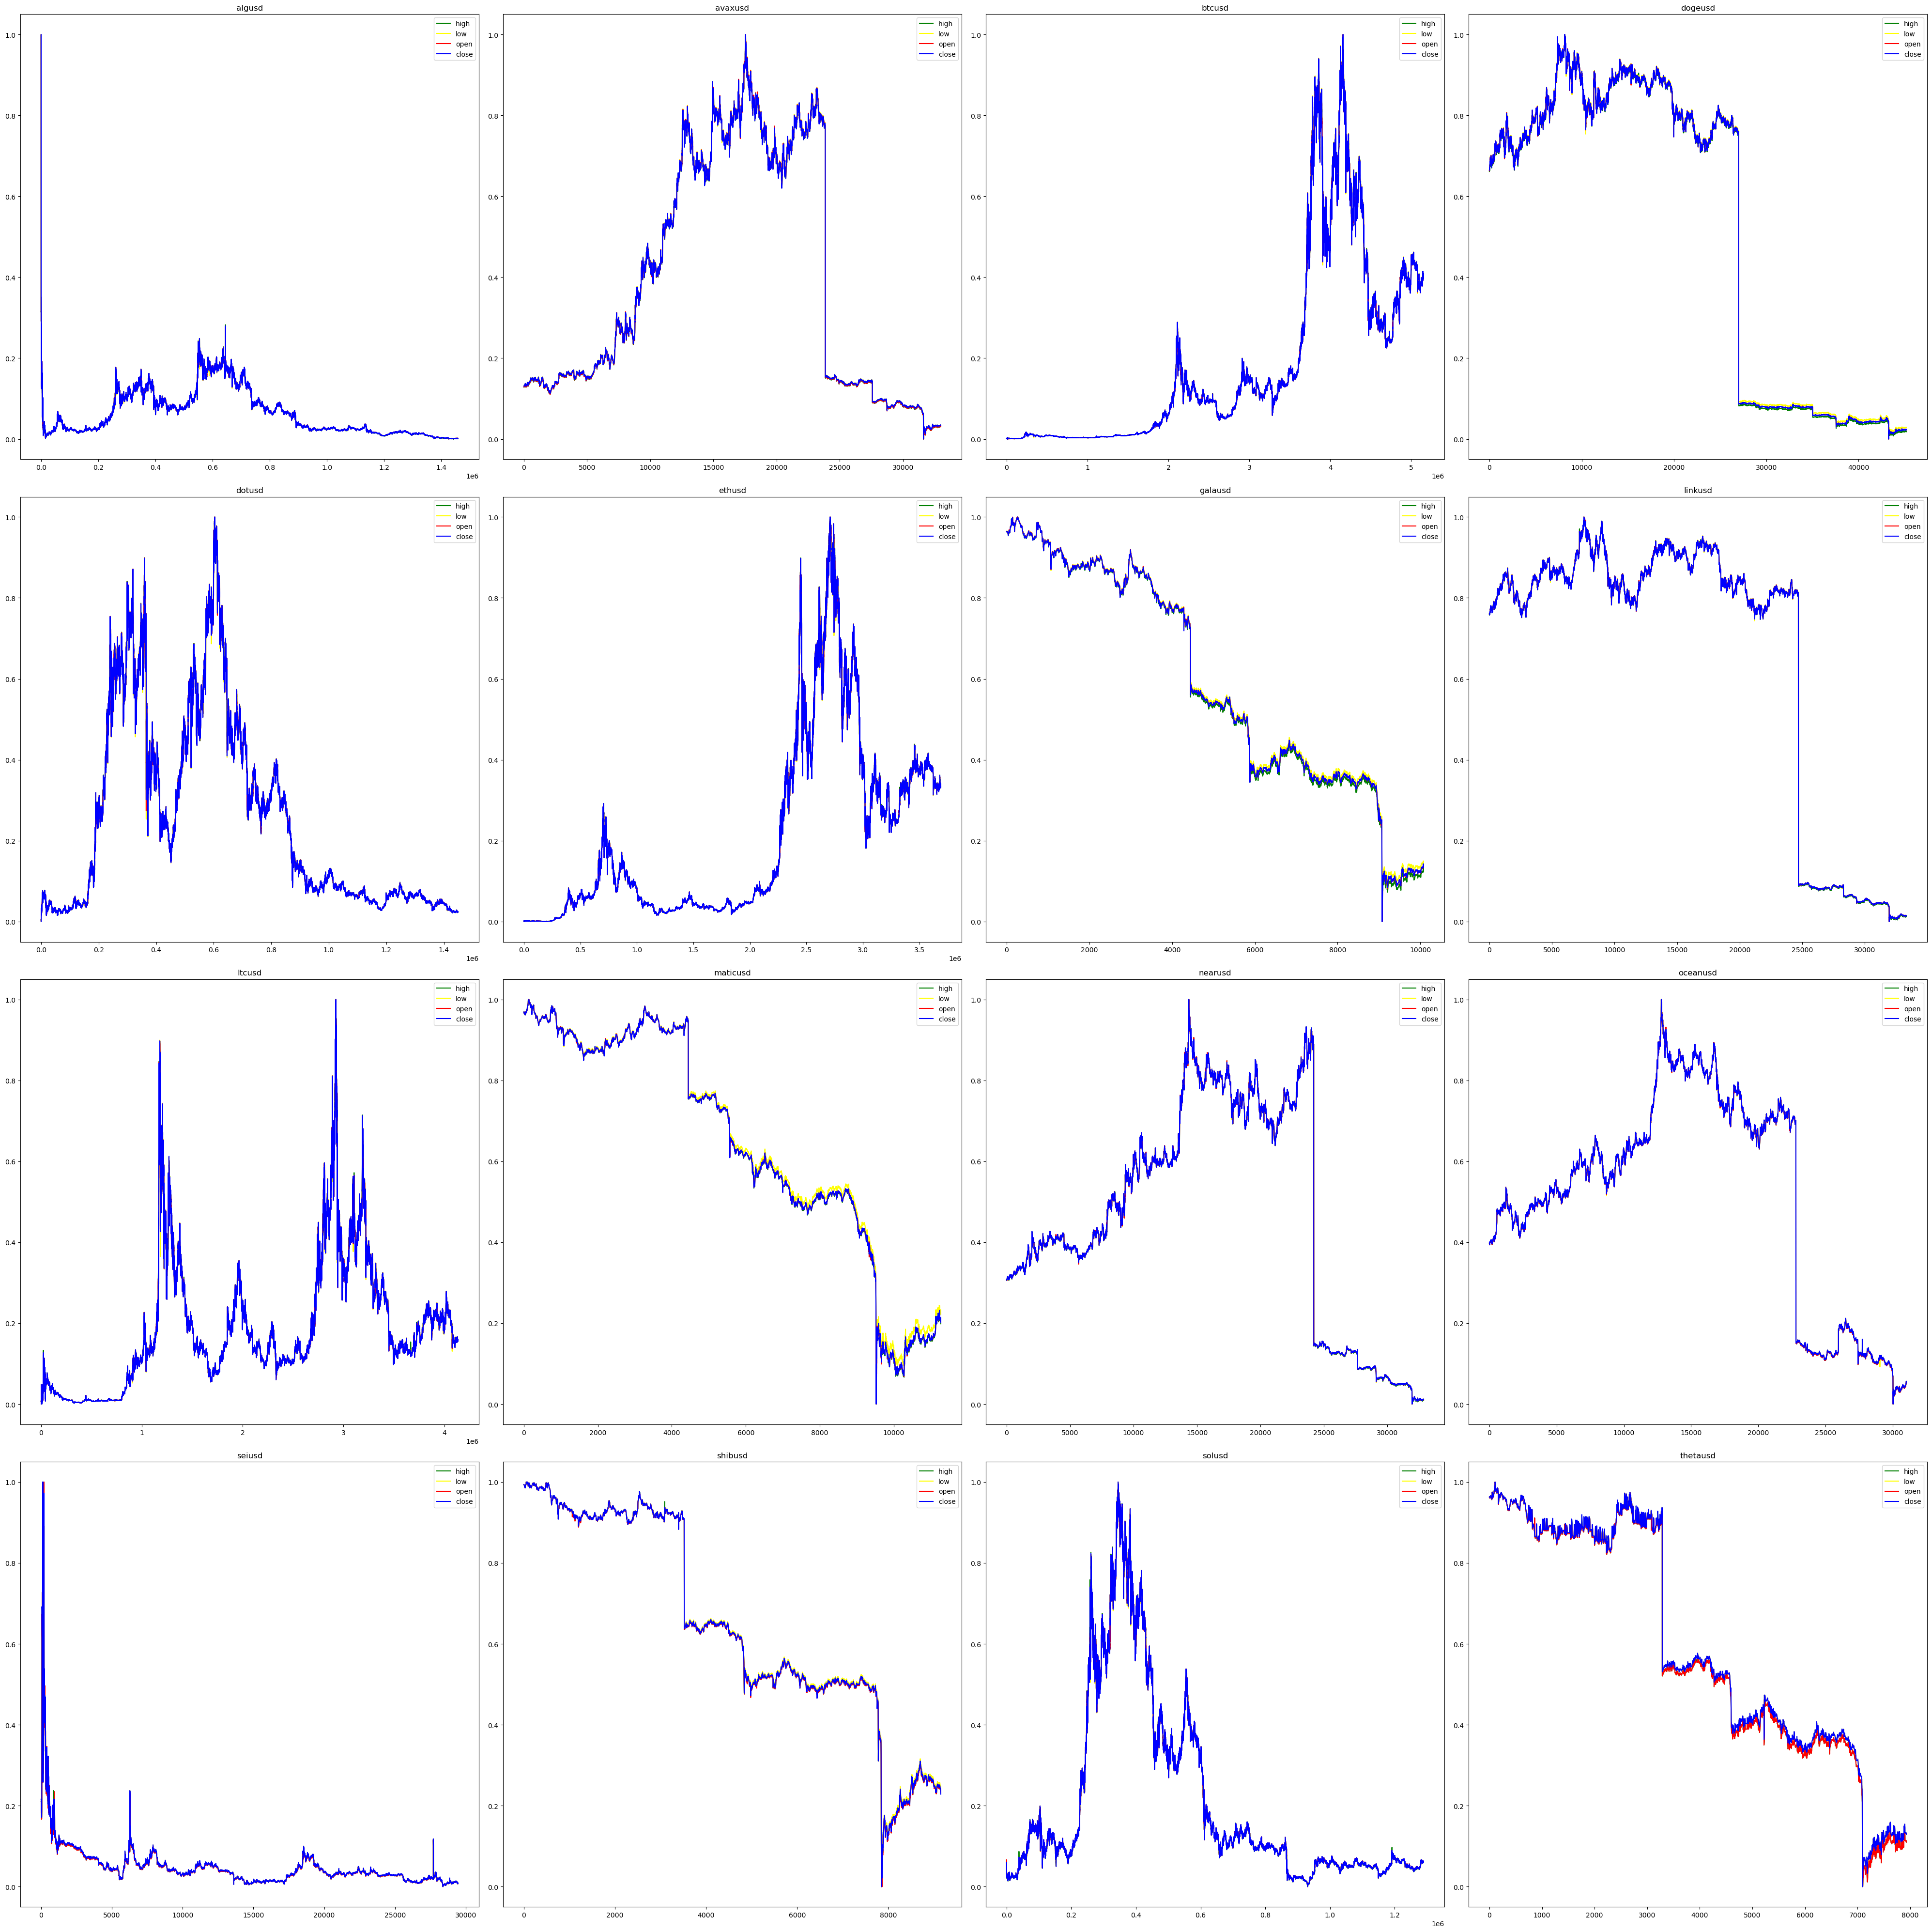

In [36]:
fig, axes = plt.subplots(4,4,figsize=(40,40))
axes = axes.flatten()
i = 0

for idx, df in all_time_normalized_plot.groupby(all_time_normalized_plot.index):

    axes[i].plot(df['high'].values,color = 'green',label = 'high')
    axes[i].plot(df['low'].values,color = 'yellow',label = 'low')
    axes[i].plot(df['open'].values,color = 'red',label = 'open')
    axes[i].plot(df['close'].values,color = 'blue',label = 'close')
    axes[i].set_title(idx)
    axes[i].legend(loc='best')
    i += 1

plt.tight_layout()
plt.show()

Then we plot them together, we can see that almost all of the currencies had the same trend in some specific periods：

- **First Period (around 2018)**: There is a significant spike in all the cryptocurrencies, likely representing a bull market or a period of increased investor enthusiasm in the crypto market.

- **Second Period (around 2020-2021)**: Here we see more volatility with several peaks and troughs. This could indicate a series of events affecting market sentiment or could correspond to the onset of the COVID-19 pandemic, which initially caused a market crash followed by a strong recovery and speculative bubble in various asset classes, including cryptocurrencies.

- **Third Period (post-2021)**: This period seems to indicate a decline or correction following the earlier peaks. It might suggest a bear market, possibly due to regulatory news, changes in market structure, or a normalization of the earlier hype.

- **Special Note**: The weird straightline for some currencies between year 2021 and 2023 is due to the gap in the data. If we use seaborn the data point between gap will be connected by straight line directly.

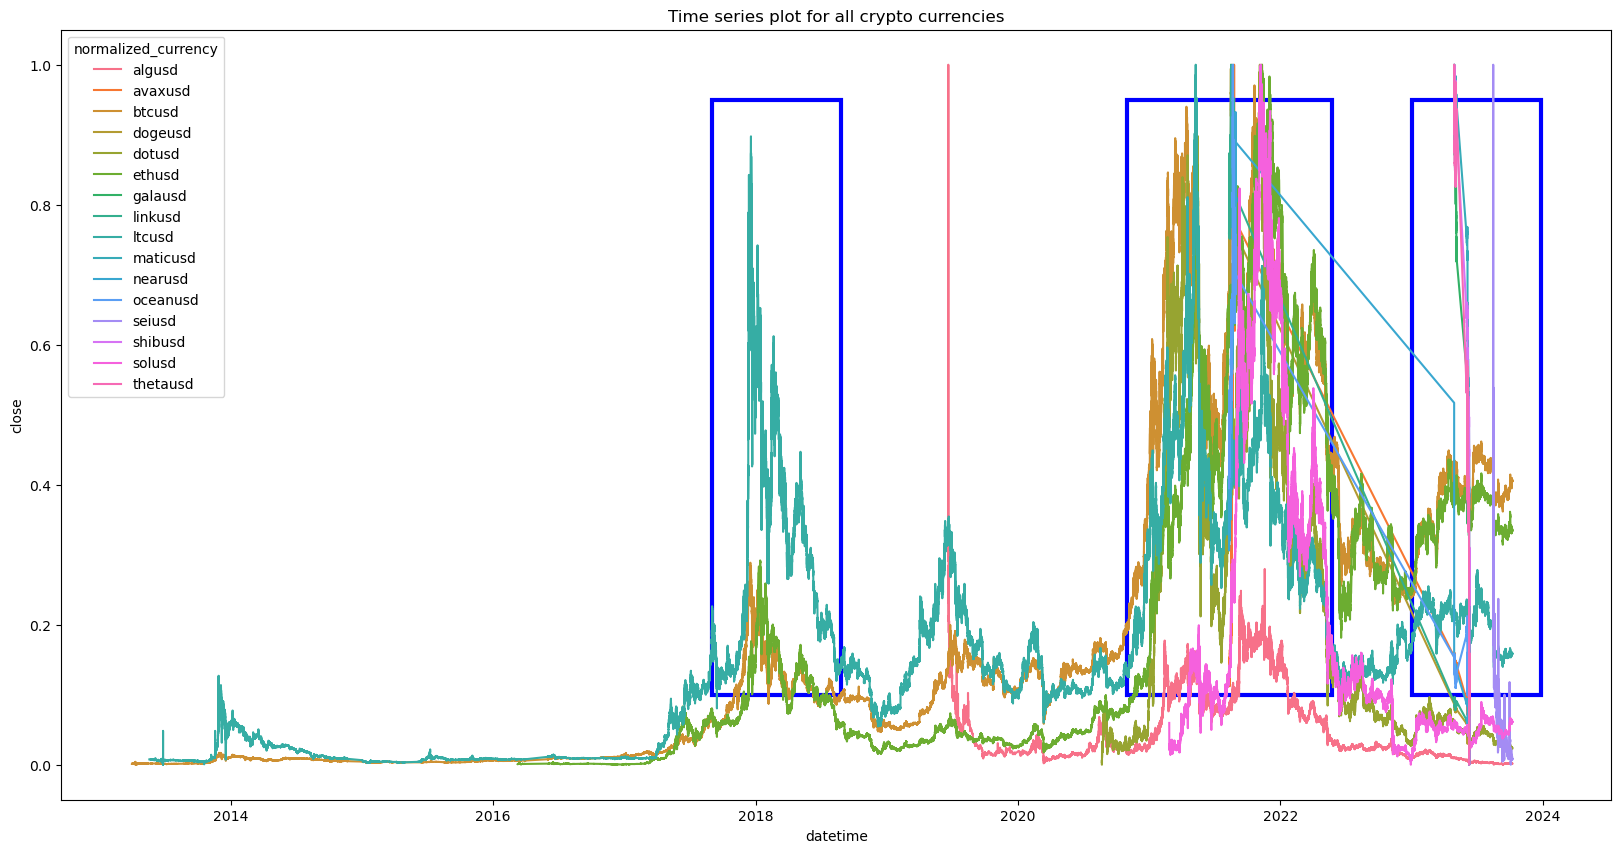

In [37]:
import matplotlib.patches as patches
fig,ax = plt.subplots(1,figsize=(20,10))

plt.title('Time series plot for all crypto currencies')
sns.lineplot(data=all_time_normalized,x='datetime',y='close',hue='normalized_currency')
rect1 = patches.Rectangle((datetime.datetime(2017,9,1), 0.1), datetime.timedelta(180*2), 0.85, linewidth=3, edgecolor='b', facecolor='none')
rect2 = patches.Rectangle((datetime.datetime(2020,11,1), 0.1), datetime.timedelta(190*3), 0.85,  linewidth=3, edgecolor='b', facecolor='none')
rect3 = patches.Rectangle((datetime.datetime(2023,1,1), 0.1), datetime.timedelta(180*2), 0.85,  linewidth=3, edgecolor='b', facecolor='none')
ax.add_patch(rect1)
ax.add_patch(rect2)
ax.add_patch(rect3)


In the following part, we create the `open-close spread` and `high-low spread`.
- For `open-close spread`:   

    - **Interpretation**:A positive spread indicates that the asset's price increased from the open to the close, suggesting bullish sentiment for that period. A negative spread suggests bearish sentiment, indicating that the price decreased from the open to the close. The open-close spread is often used to gauge the day's market sentiment and the strength of the buying or selling pressure. A large spread, whether positive or negative, signifies strong sentiment and potentially higher volatility.  

    - **Result**: Some plots show significant spikes, which indicate moments of high volatility where the open-close spread has large variations. This could be due to market news, economic events, or simply periods of high trading activity. Some segments within the plots show very little variation, indicating periods of low volatility or market inactivity. This could happen outside of the main trading hours or during less volatile market conditions.
- For `high-low spread`:   

    - **Interpretation**: A larger high-low spread indicates a high level of volatility, as the price moved significantly from its lowest point to its highest point within the session. Traders use the high-low spread to understand the volatility and potential risk associated with trading an asset. High volatility might offer more opportunities for profit but comes with increased risk, while lower volatility suggests a more stable and potentially less risky environment.  
    
    - **Result**: The plots are characterized by spikes which indicate moments of high volatility where the high-low spread is significant.  These spikes could be associated with market news, release of economic data, or periods of high trading activity. There may be outliers or extreme spikes that are substantially higher than the typical range for the high-low spread. Such anomalies might suggest extraordinary market events, data errors, or even issues with the trading system or liquidity.

In [38]:
all_time_normalized_plot.reset_index(inplace=True)
all_time_normalized_plot['open-close spread'] = all_time_normalized_plot['open']-all_time_normalized_plot['close']
all_time_normalized_plot['high-low spread'] = all_time_normalized_plot['high'] - all_time_normalized_plot['low']
all_time_normalized_plot.set_index('normalized_currency',inplace=True)

**Time series for open-close spread of selected crypto currencies**

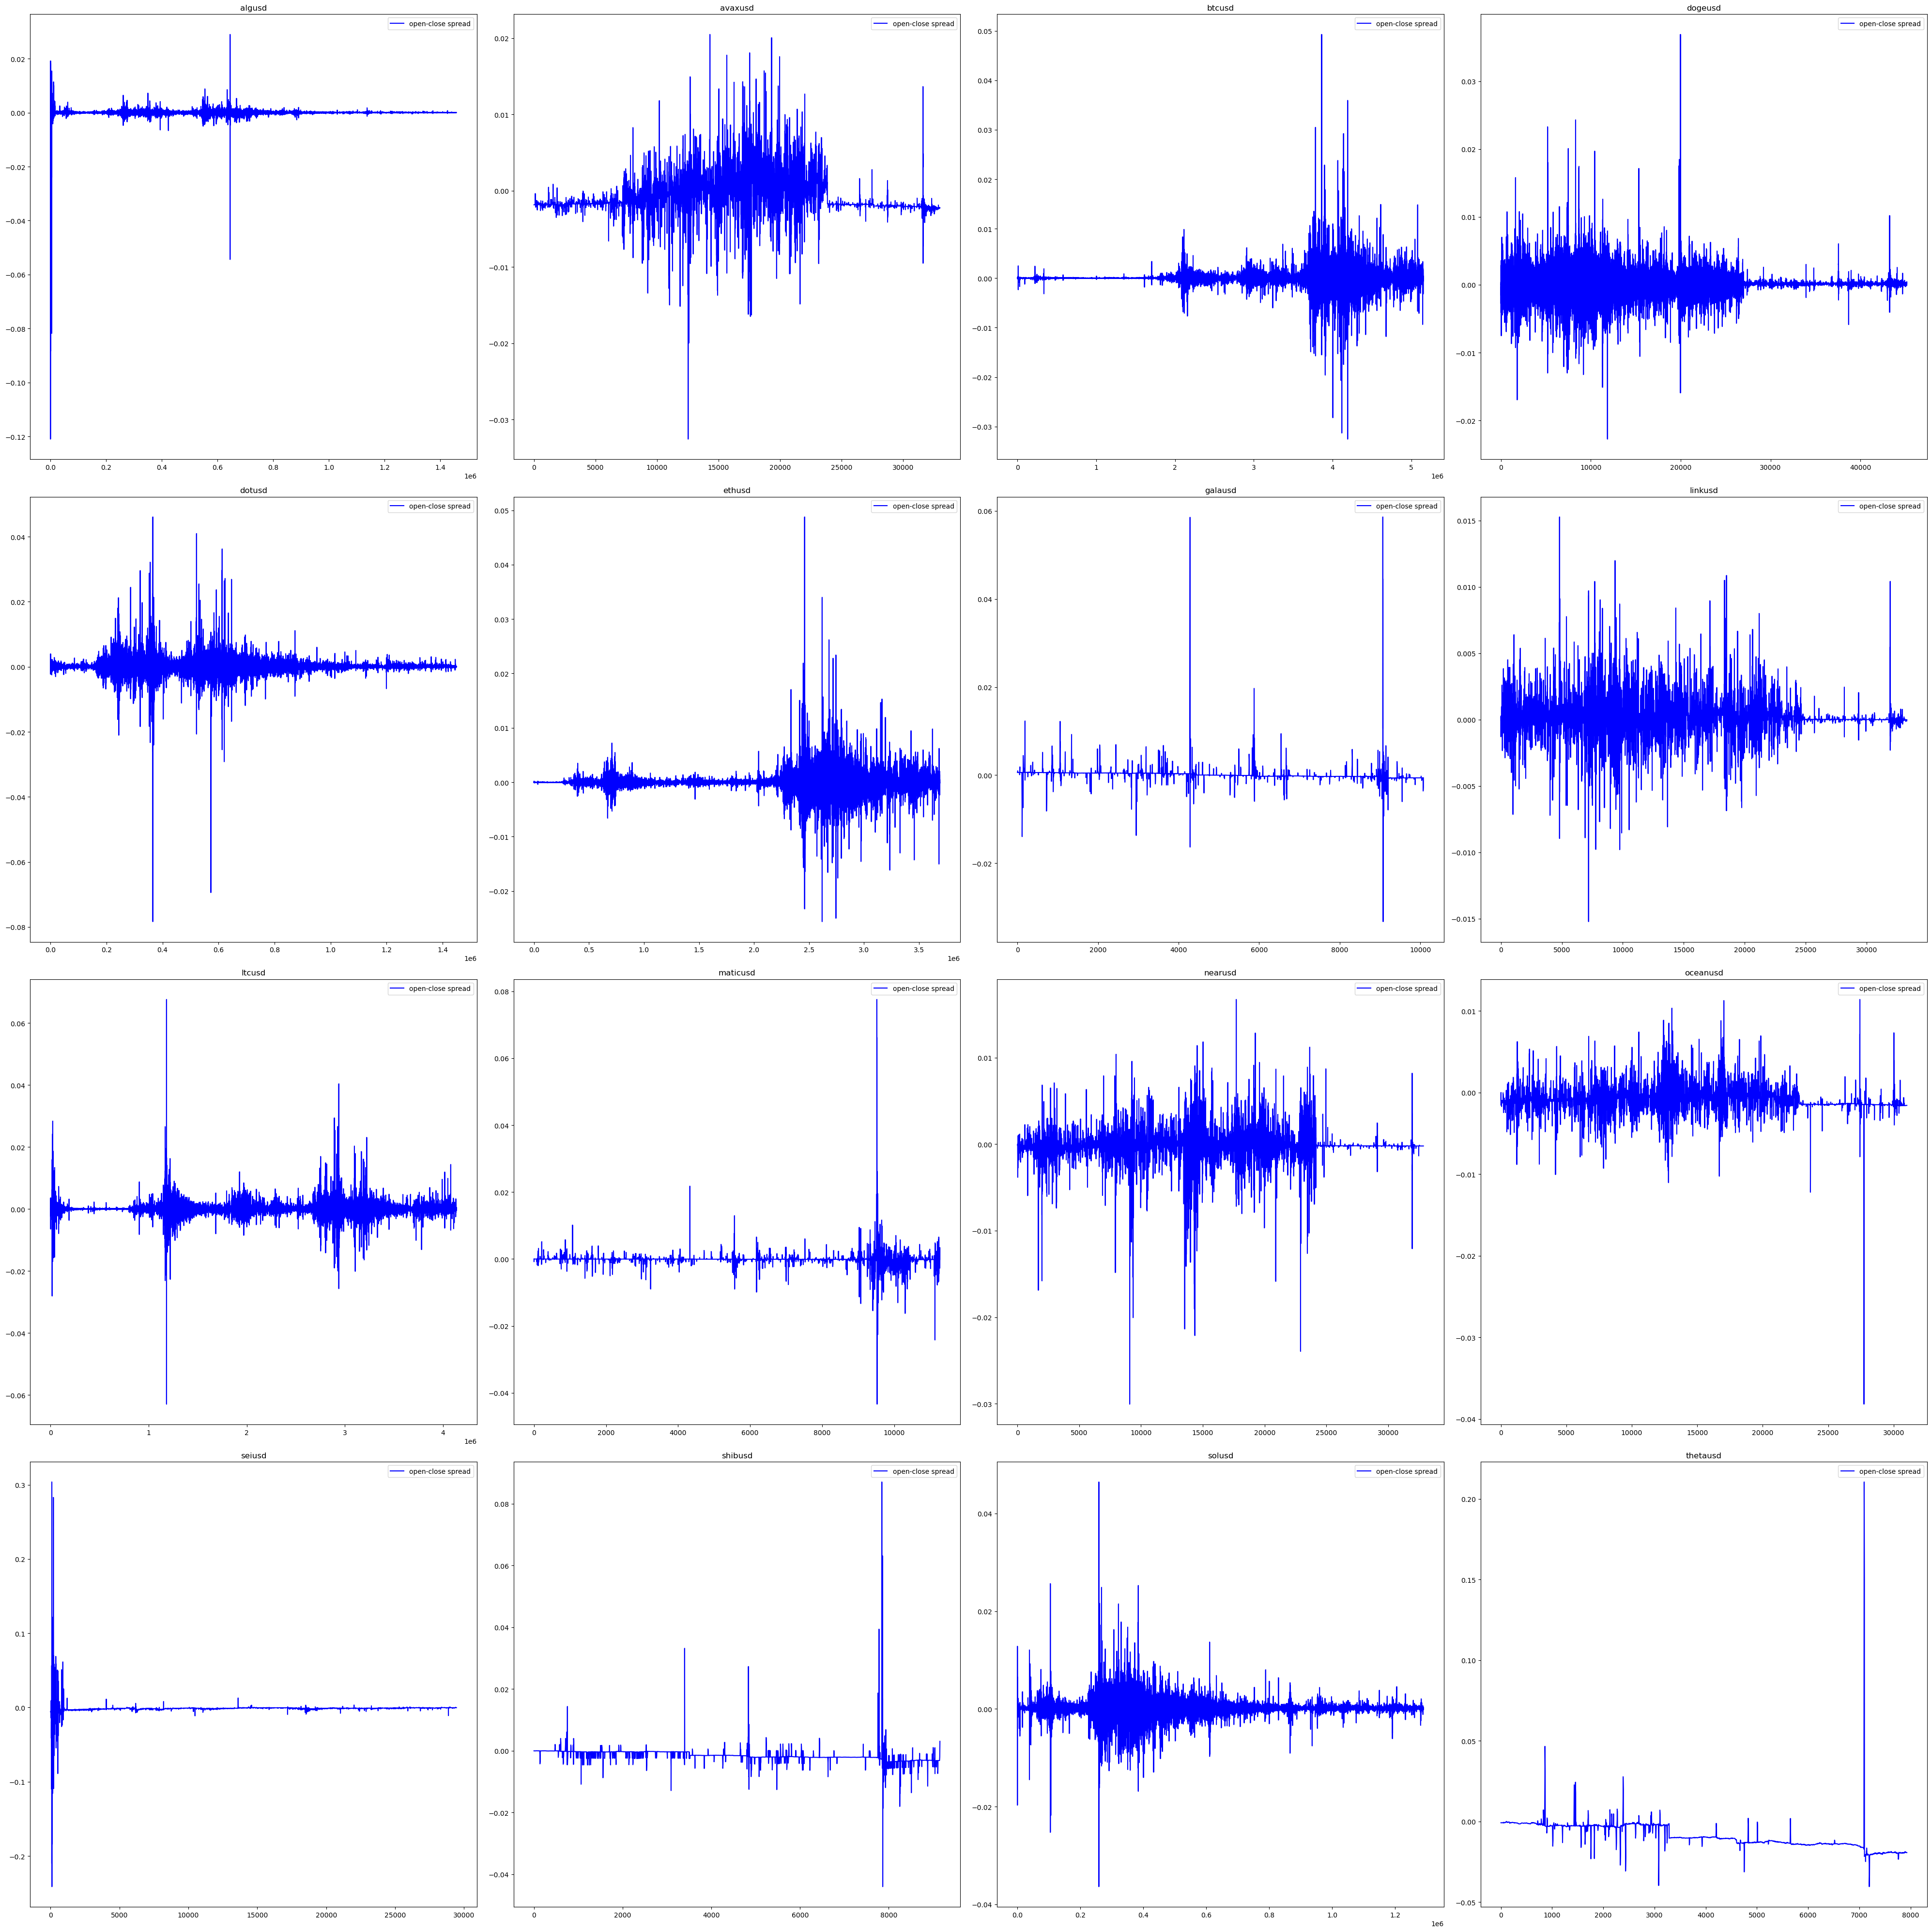

In [39]:
fig, axes = plt.subplots(4,4,figsize=(40,40))
axes = axes.flatten()
i = 0

for idx, df in all_time_normalized_plot.groupby(all_time_normalized_plot.index):

    axes[i].plot(df['open-close spread'].values,color = 'blue',label = 'open-close spread')
    axes[i].set_title(idx)
    axes[i].legend(loc='best')
    i += 1

# plt.suptitle('Time series for open-close spread of selected crypto currencies')
plt.tight_layout()
plt.show()

**Time series for high-low spread of selected crypto currencies**

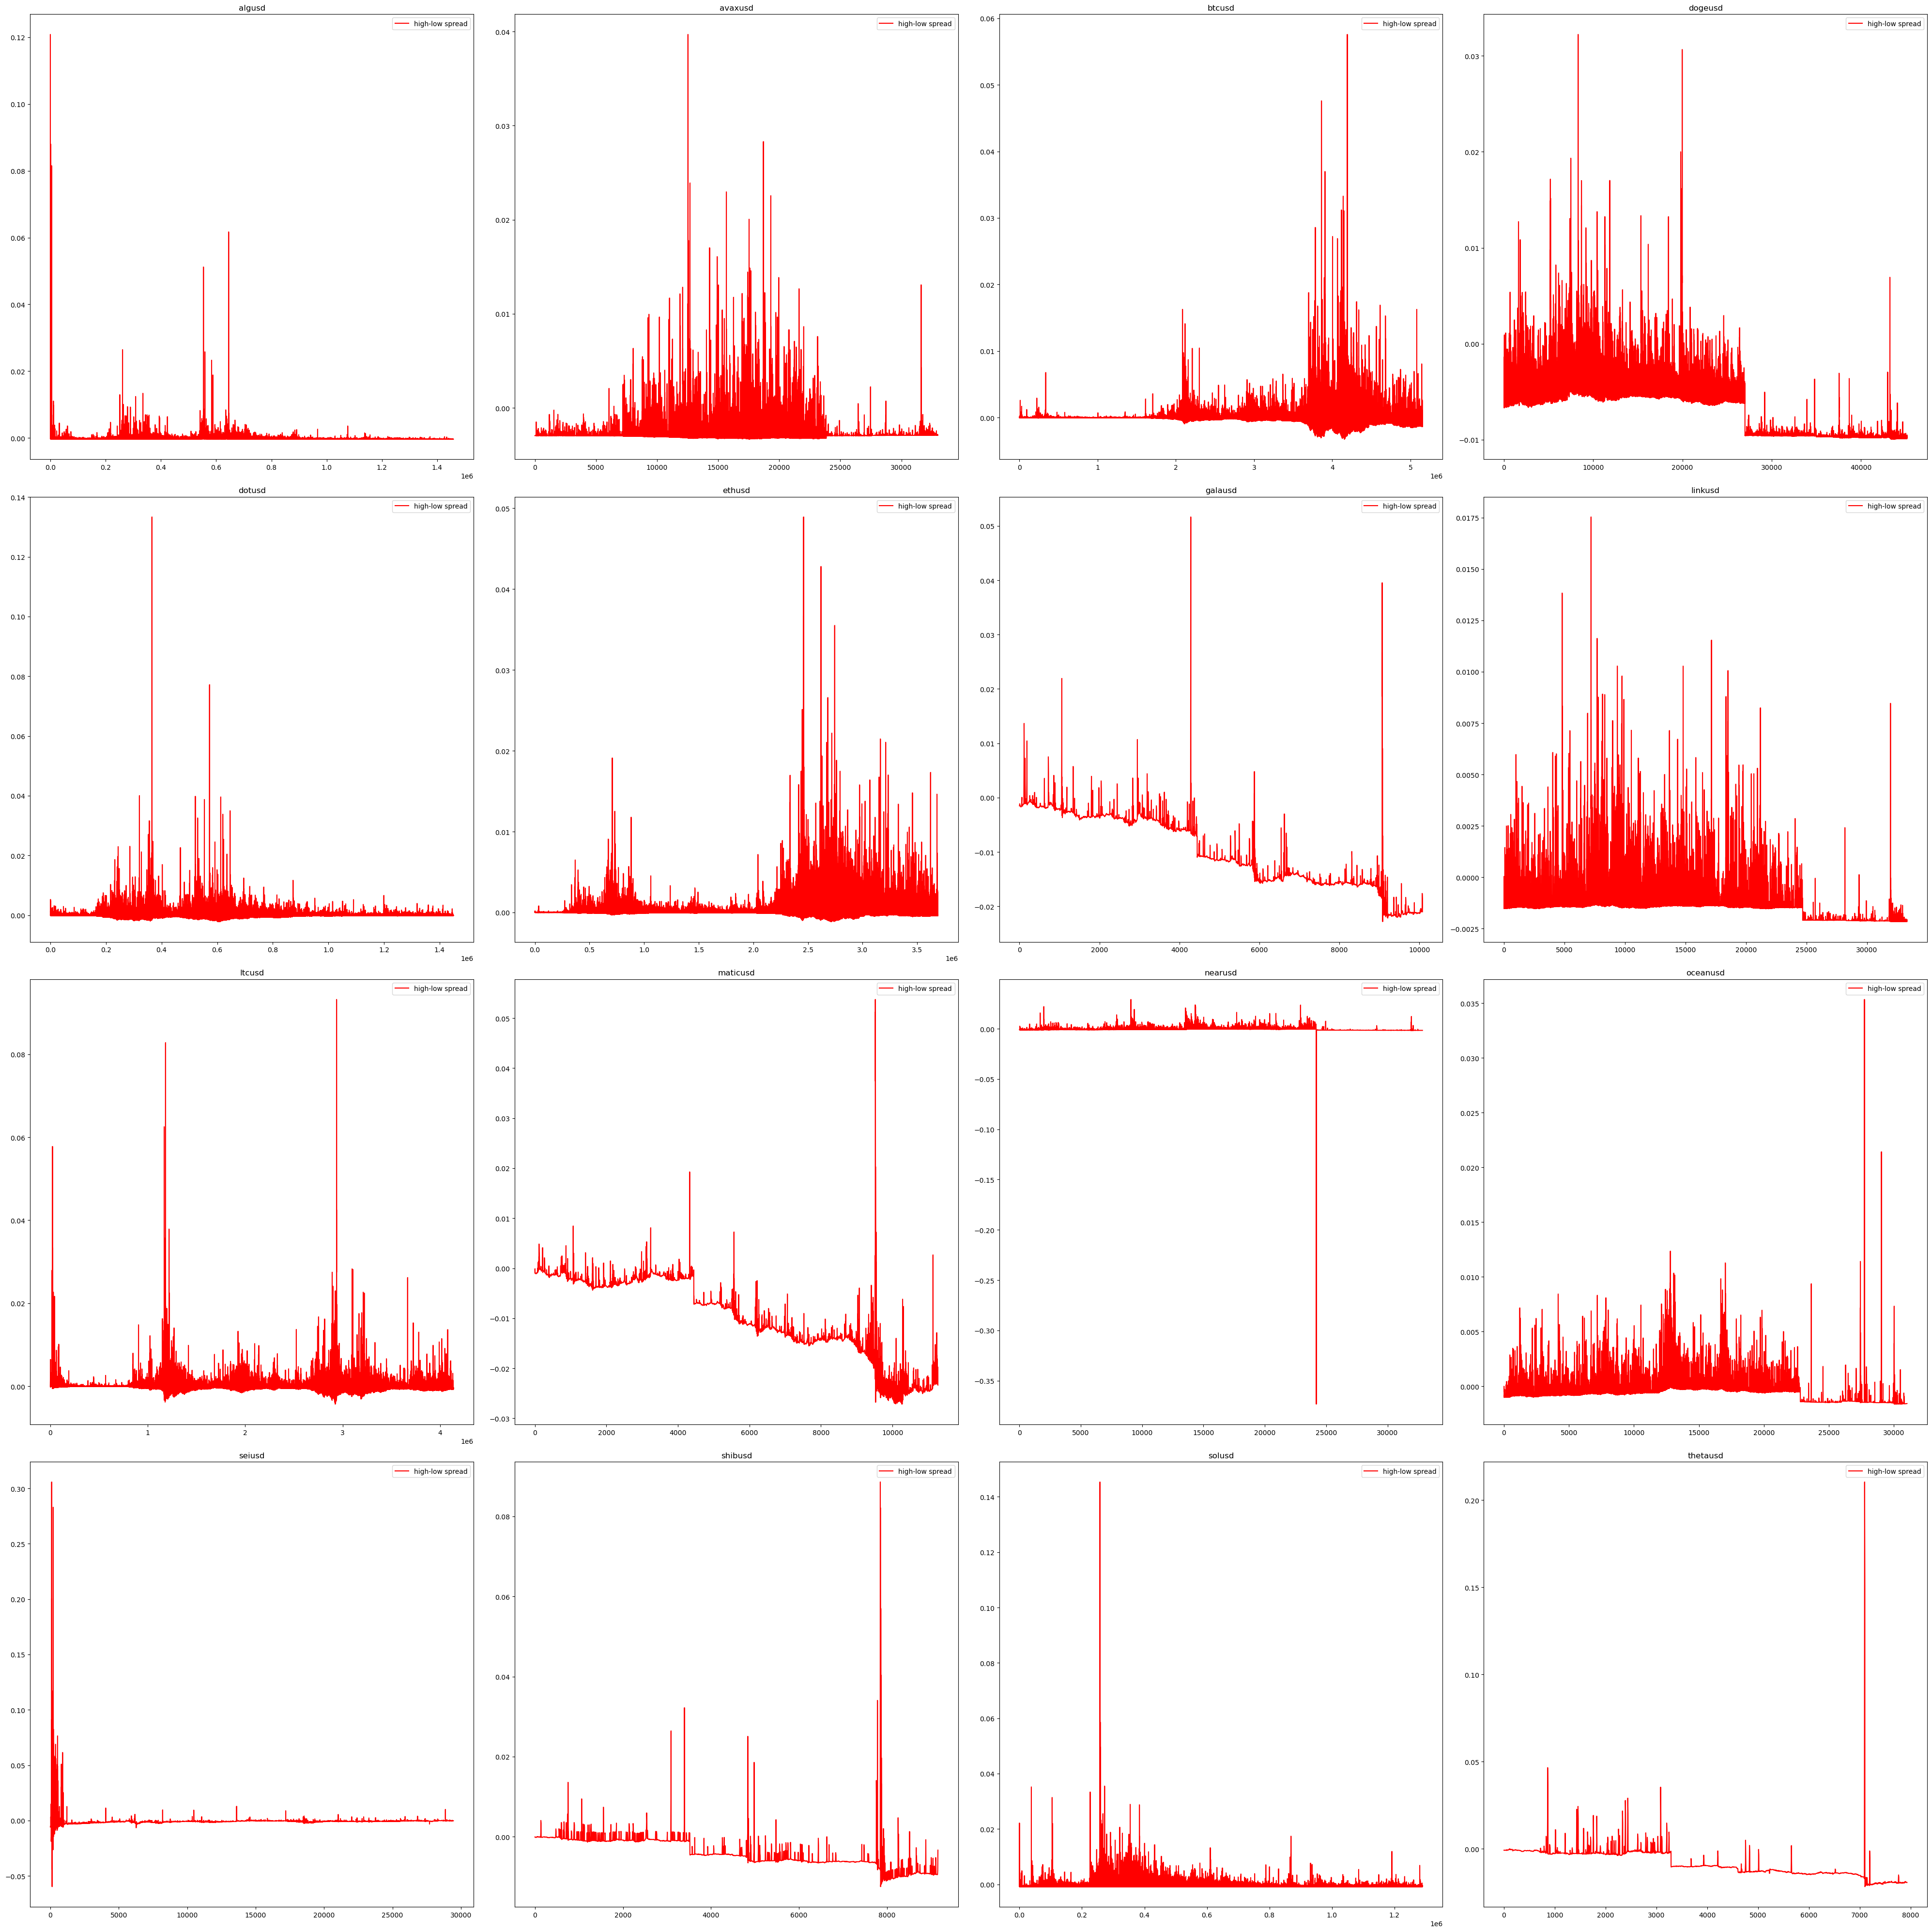

In [40]:
fig, axes = plt.subplots(4,4,figsize=(40,40))
axes = axes.flatten()
i = 0
for idx, df in all_time_normalized_plot.groupby(all_time_normalized_plot.index):

    axes[i].plot(df['high-low spread'].values,color = 'red',label = 'high-low spread')
    axes[i].set_title(idx)
    axes[i].legend(loc='best')
    i += 1

plt.tight_layout()
plt.show()

We also plot the distribution of `open-close spread` and `high-low spread` with histogram, here is the interpretation of the result:
- `open-close spread`:  

    - **Centering Around Zero**: Many histograms have a peak at or near zero, indicating that there are many instances where the opening and closing prices were very close, suggesting minimal price change over the trading period.

    - **Skewness**: Some histograms show a skew to the right or left, which would suggest a tendency for the closing price to be consistently higher or lower than the opening price over the sampled periods.

    - **Volatility**: The width of the histograms reflects the volatility of the open-close spread. A narrow distribution suggests less volatility, while a wider distribution indicates greater volatility.
- `high-low spread`:  

    - **Peak Near Zero**: Most histograms have a pronounced peak very close to zero, suggesting that often there is a small difference between the high and low prices within the given time frame.

    - **Tail Behavior**: Some histograms show a long tail extending to the right, indicating occasional large spreads between the high and low prices. This might be due to sudden market movements or events causing volatility.

    - **Variation in Spread**: The width of the distributions varies across the histograms. Some are quite narrow, indicating a more stable market condition with less variability in the high-low spread, while others are wider, indicating more volatile conditions.

**Histogram for open-close spread of selected crypto currencies**

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


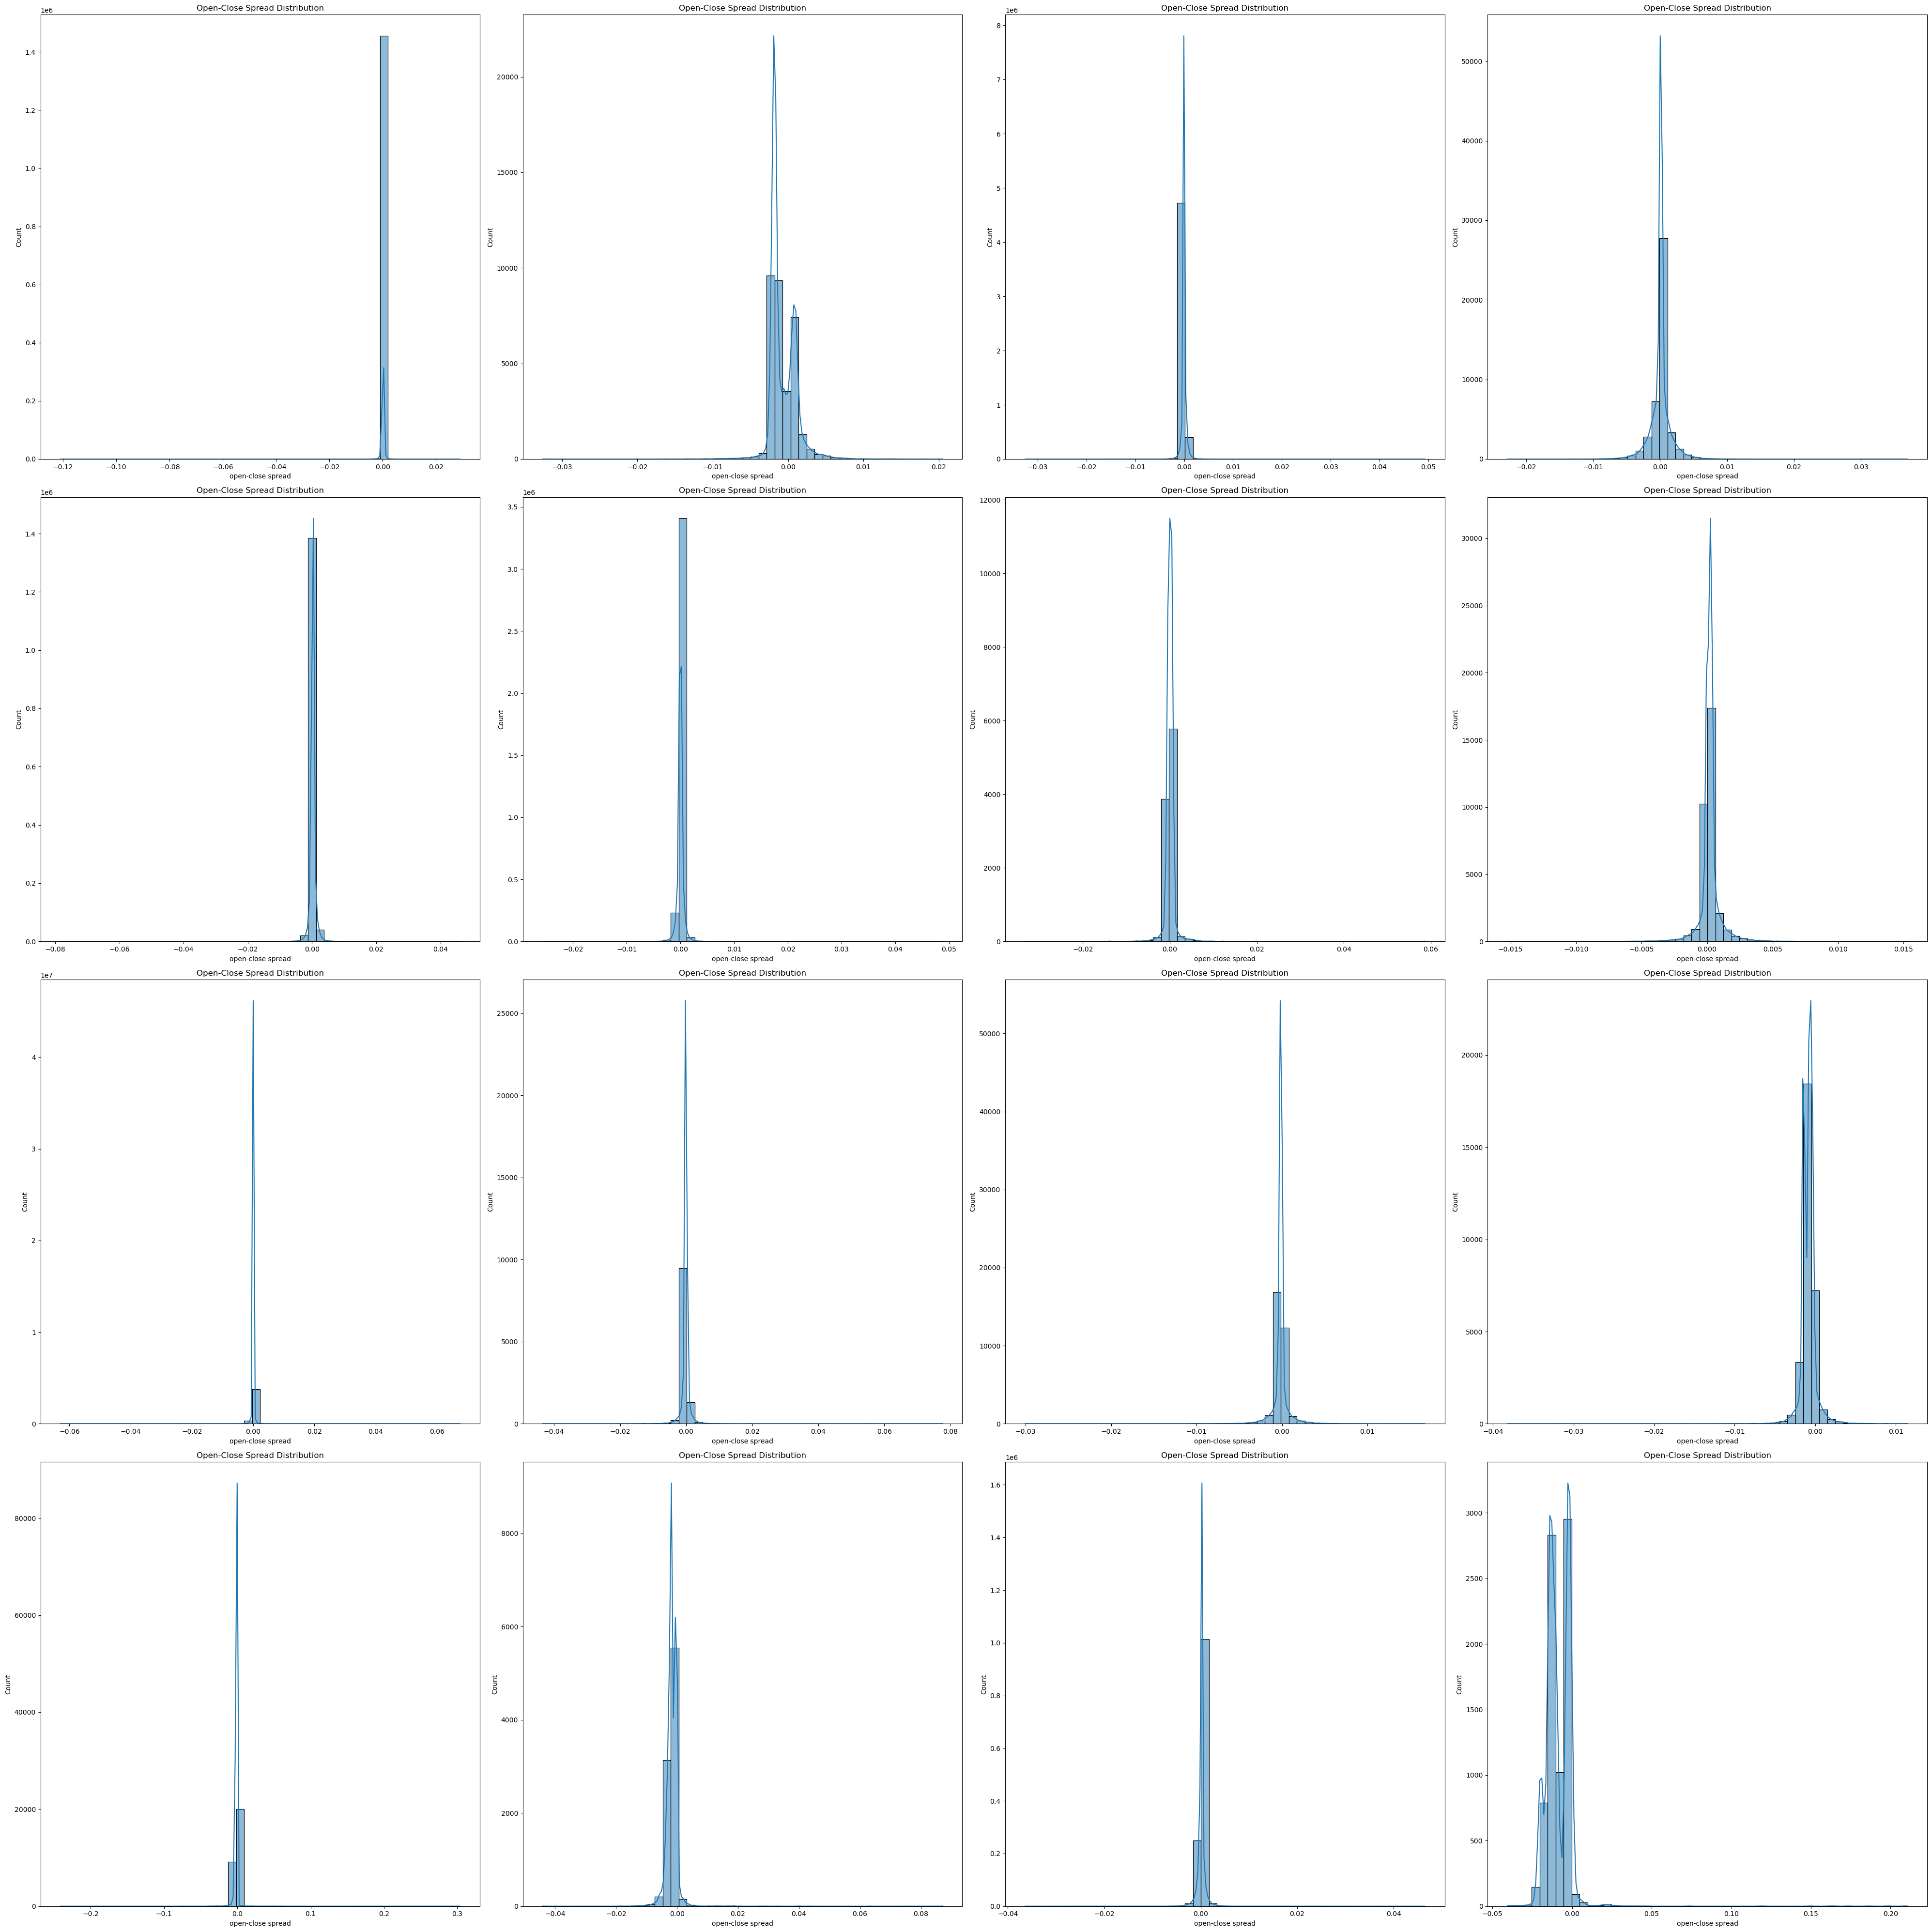

In [41]:
fig, axes = plt.subplots(4,4,figsize=(40,40))
axes = axes.flatten()
i = 0
for idx, df in all_time_normalized_plot.groupby(all_time_normalized_plot.index):

    sns.histplot(df['open-close spread'], bins=50, kde=True,ax=axes[i])
    axes[i].set_title('Open-Close Spread Distribution')
    # axes[i].set_title(idx)
    i += 1

plt.tight_layout()
plt.show()


**Histogram for high-low spread of selected crypto currencies**

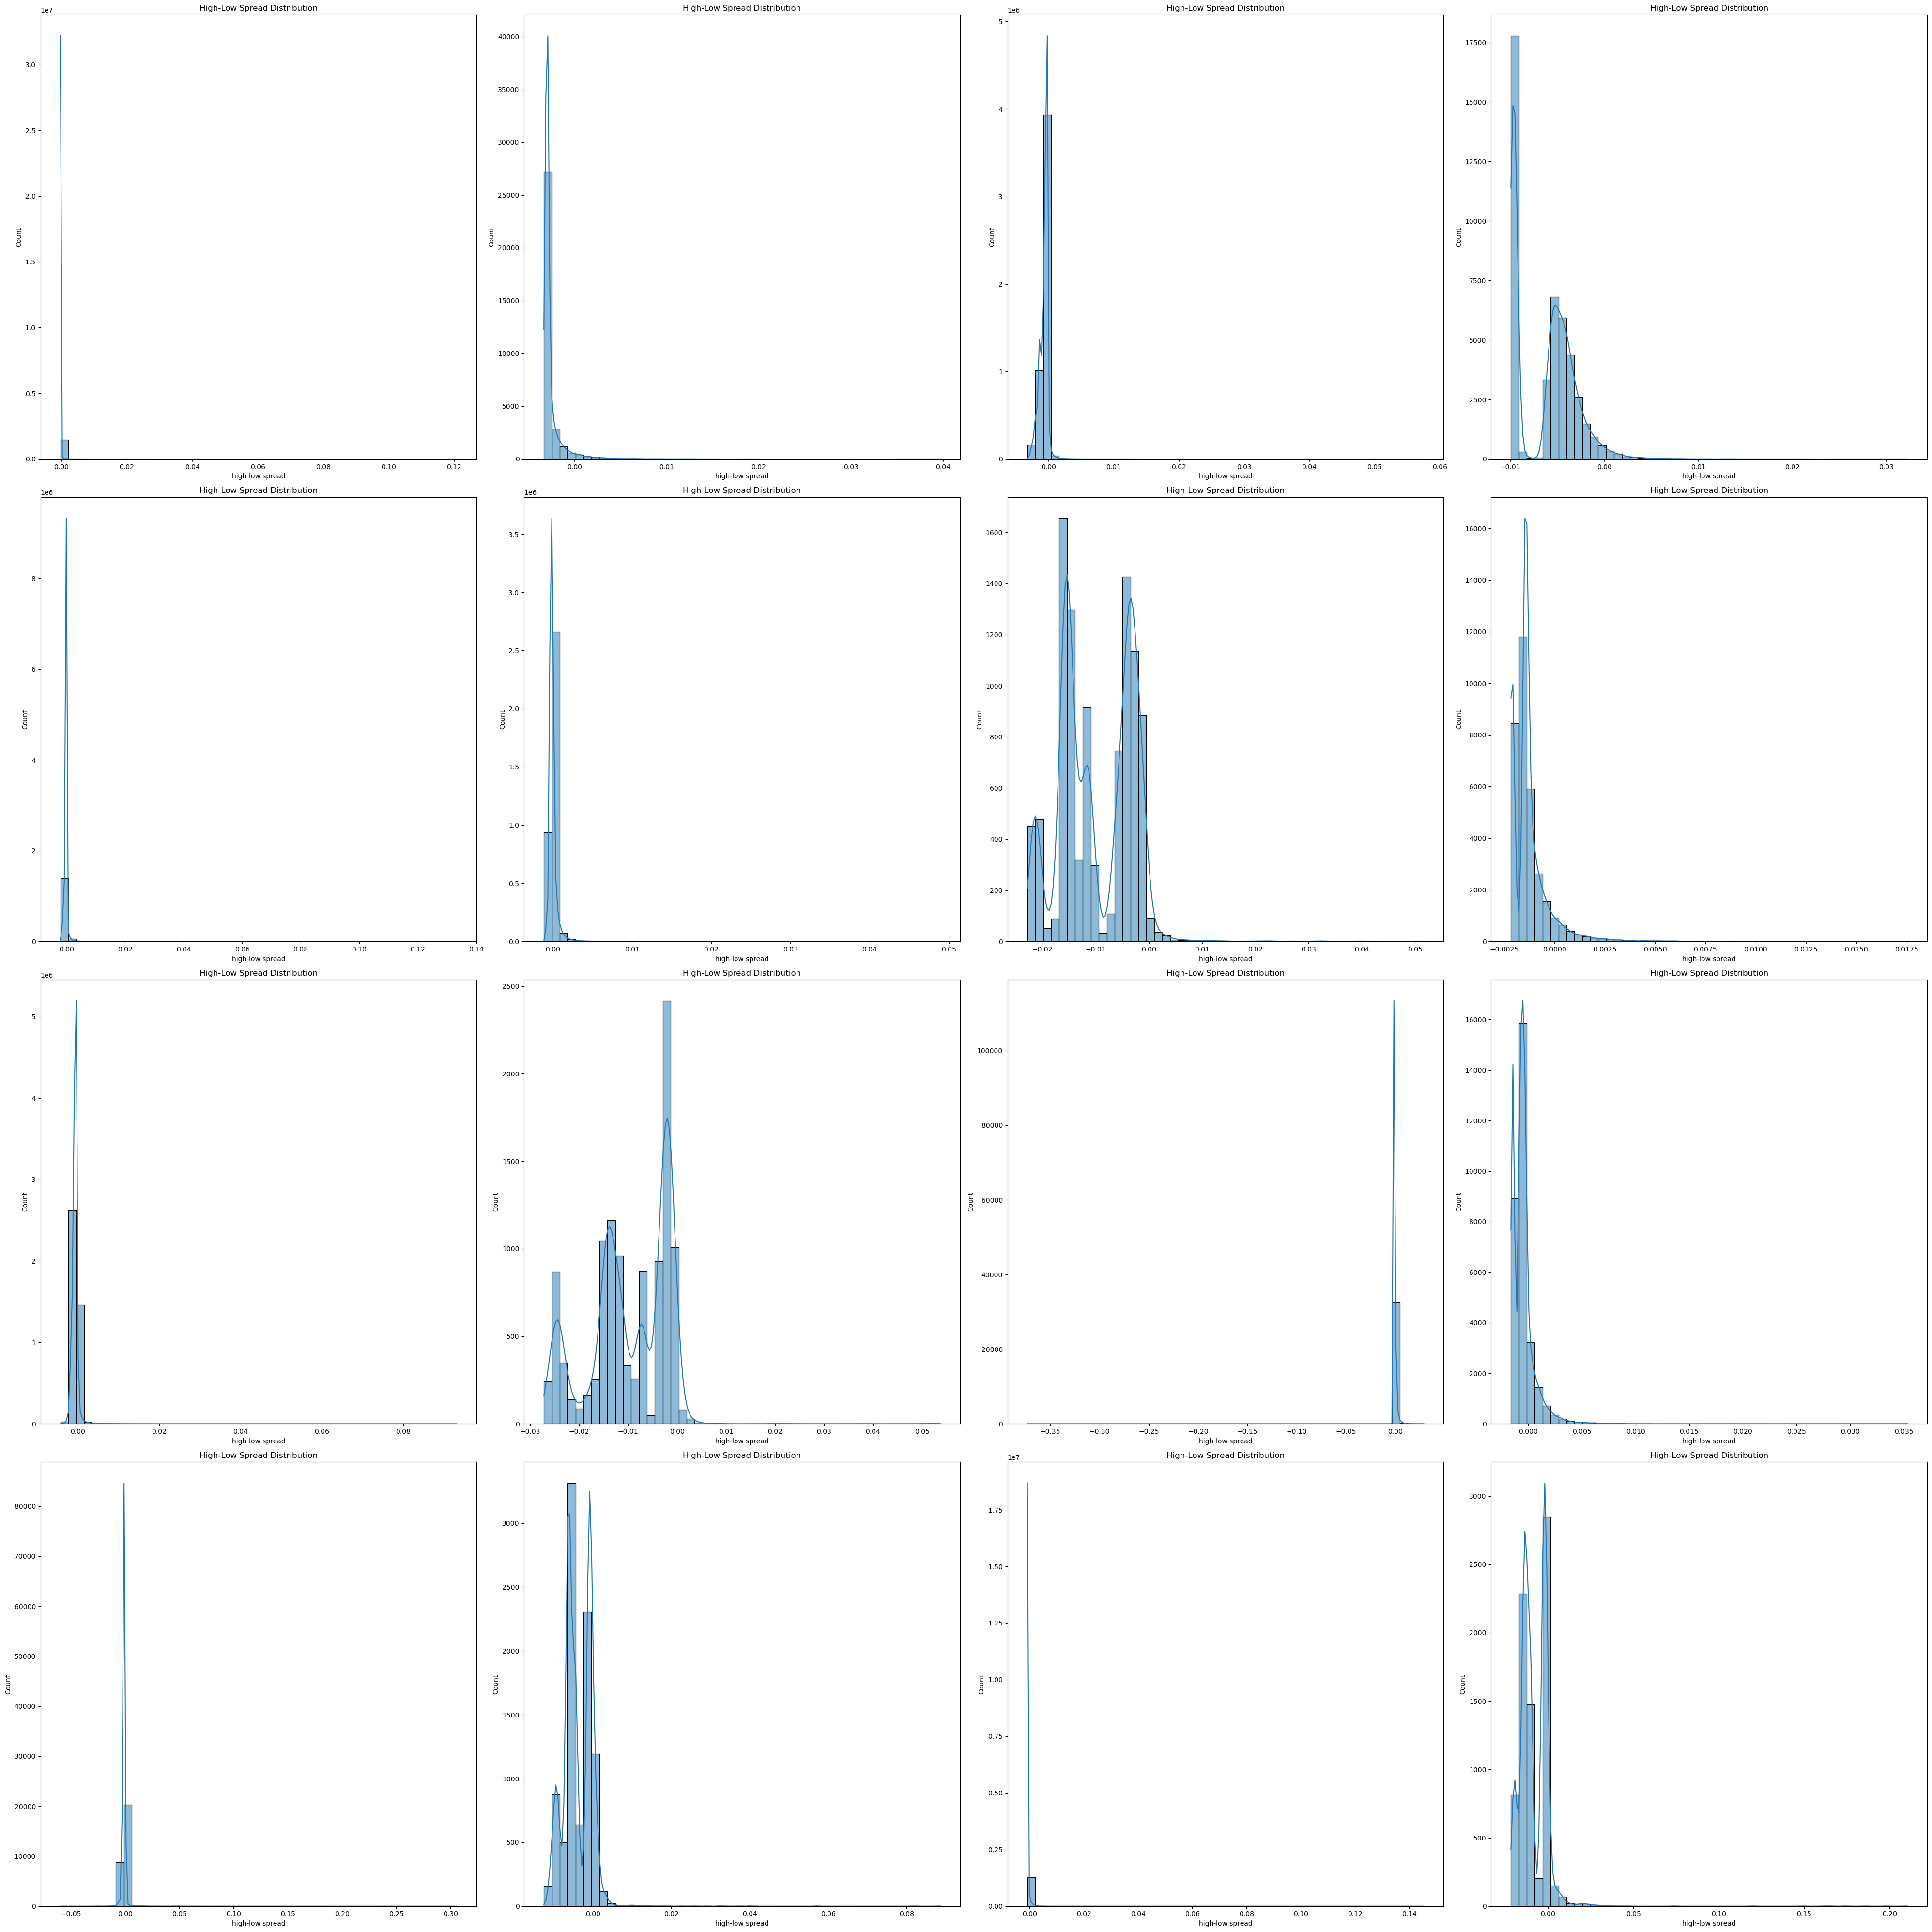

In [42]:
fig, axes = plt.subplots(4,4,figsize=(40,40))
axes = axes.flatten()
i = 0
for idx, df in all_time_normalized_plot.groupby(all_time_normalized_plot.index):

    sns.histplot(df['high-low spread'], bins=50, kde=True,ax=axes[i])
    axes[i].set_title('High-Low Spread Distribution')
    # axes[i].set_title(idx)
    i += 1

plt.tight_layout()
plt.show()

#### Exploring Trading Volume of Different Crypto Currency Pairs

In [43]:
# get unique currency pairs
cur = all_time_normalized["normalized_currency"].unique()
dfs = [x for _, x in all_time_normalized.groupby("normalized_currency")]

In [44]:
# obtain average volume, % missing data, number of nan gaps, mean gap length, and datetime ranges
avg_vols = [d["volume"].mean() for d in dfs]
missing = [d["open"].isna().sum()/d["open"].size*100 for d in dfs]
starts = [d["datetime"].iloc[0] for d in dfs]
ends = [d["datetime"].iloc[-1] for d in dfs]
nan_gaps = []
avg_gap_len = []
for d in dfs:
    switches = np.count_nonzero(d["open"].isna().diff()[1:])
    num_gaps = int(switches/2)
    avg_gap = d["open"].isna().sum() / num_gaps
    nan_gaps.append(num_gaps)
    avg_gap_len.append(avg_gap)

In [46]:
# print currency, datatime range, and % missing data
for i in range(len(cur)):
    print(f'{cur[i]} : {starts[i]} to {ends[i]} , {missing[i]} % missing')

algusd : 2019-06-21 09:32:00 to 2023-10-08 09:25:00 , 35.48686877265244 % missing
avaxusd : 2021-08-10 19:18:00 to 2023-06-11 12:45:00 , 96.5790412356596 % missing
btcusd : 2013-04-01 00:07:00 to 2023-10-08 09:28:00 , 6.86600607766939 % missing
dogeusd : 2021-08-10 19:18:00 to 2023-06-11 12:55:00 , 95.31676098952944 % missing
dotusd : 2020-08-21 19:22:00 to 2023-10-08 09:25:00 , 11.906347929040116 % missing
ethusd : 2016-03-09 16:04:00 to 2023-10-08 09:27:00 , 7.455748283656437 % missing
galausd : 2023-04-29 09:51:00 to 2023-06-11 13:00:00 , 83.77394944453388 % missing
linkusd : 2021-08-10 19:21:00 to 2023-06-11 12:45:00 , 96.54564213167704 % missing
ltcusd : 2013-05-19 15:23:00 to 2023-10-08 09:20:00 , 24.296146548104172 % missing
maticusd : 2023-04-29 09:54:00 to 2023-06-11 13:04:00 , 81.85184588881197 % missing
nearusd : 2021-08-10 19:22:00 to 2023-06-11 12:40:00 , 96.5940445811329 % missing
oceanusd : 2021-08-10 19:23:00 to 2023-06-11 12:51:00 , 96.78414448641604 % missing
seiusd :

In [47]:
# make df with all data and sort by average volume; reset index
df_vol_missing = pd.DataFrame({"currency":cur,"avg_vol":avg_vols,"per_missing":missing,"start":starts,"end":ends,"nan_gaps":nan_gaps,"avg_gap_len":avg_gap_len})
df_vol_missing = df_vol_missing.sort_values(by=['avg_vol'])
df_vol_missing = df_vol_missing.reset_index(drop=True)

In [48]:
# view dataframe
df_vol_missing

currency   avg_vol  per_missing               start                 end  \
0     ethusd  0.003234     7.455748 2016-03-09 16:04:00 2023-10-08 09:27:00   
1     ltcusd  0.003292    24.296147 2013-05-19 15:23:00 2023-10-08 09:20:00   
2     solusd  0.005356     6.221845 2021-02-25 09:40:00 2023-10-08 09:26:00   
3     btcusd  0.005467     6.866006 2013-04-01 00:07:00 2023-10-08 09:28:00   
4     dotusd  0.005574    11.906348 2020-08-21 19:22:00 2023-10-08 09:25:00   
5    dogeusd  0.007142    95.316761 2021-08-10 19:18:00 2023-06-11 12:55:00   
6     algusd  0.008131    35.486869 2019-06-21 09:32:00 2023-10-08 09:25:00   
7   thetausd  0.010202    87.230445 2023-04-29 09:59:00 2023-06-11 12:51:00   
8    avaxusd  0.010484    96.579041 2021-08-10 19:18:00 2023-06-11 12:45:00   
9    galausd  0.010693    83.773949 2023-04-29 09:51:00 2023-06-11 13:00:00   
10    seiusd  0.012943    61.861839 2023-08-15 16:41:00 2023-10-08 07:34:00   
11   linkusd  0.013448    96.545642 2021-08-10 19:21:00 2023-06-11 12:45:00   
12   nearusd  0.014459    96.594045 2021-08-10 19:22:00 2023-06-11 12:40:00   
13  maticusd  0.015337    81.851846 2023-04-29 09:54:00 2023-06-11 13:04:00   
14  oceanusd  0.025010    96.784144 2021-08-10 19:23:00 2023-06-11 12:51:00   
15   shibusd  0.028623    85.260497 2023-04-29 09:48:00 2023-06-11 12:59:00   

    nan_gaps  avg_gap_len  
0      20870    14.243316  
1      74559    17.801982  
2      20359     4.202662  
3      25442    14.931963  
4      32274     6.069839  
5        579  1587.654577  
6      49528    16.198615  
7       1139    47.553995  
8       2231   417.488122  
9       1115    46.665471  
10      2297    20.794950  
11      2005   464.384539  
12      2187   425.949703  
13       997    50.991976  
14      2627   355.308337  
15      1084    48.853321

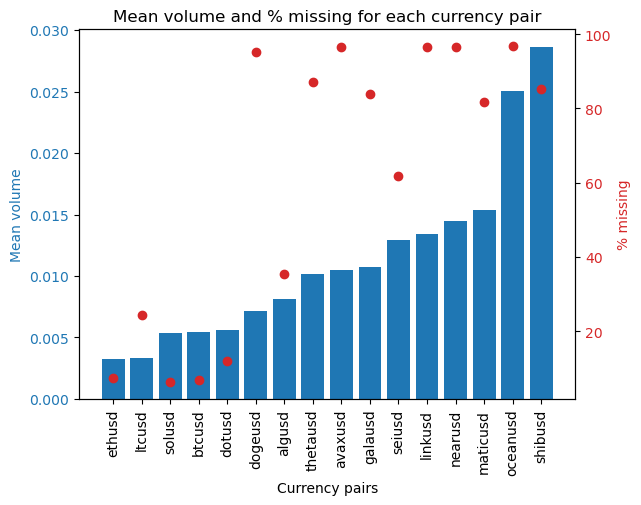

In [49]:
# plot average volume and % missing data
fig, ax1 = plt.subplots()

ax1.bar(df_vol_missing["currency"],df_vol_missing["avg_vol"])
ax1.set_xlabel('Currency pairs')
ax1.set_ylabel('Mean volume', color = "tab:blue")
ax1.tick_params(axis ='y', labelcolor = "tab:blue")
ax1.tick_params(axis='x', labelrotation=90)

ax2 = ax1.twinx()
ax2.scatter(df_vol_missing["currency"],df_vol_missing["per_missing"], color="tab:red")
ax2.set_ylabel('% missing', color = "tab:red")
ax2.tick_params(axis ='y', labelcolor = "tab:red")

plt.title("Mean volume and % missing for each currency pair")
plt.xticks(rotation=90)
plt.show()

In this graph, percent missing is calculated by dividing the number of time points with missing "open" values (meaning that those time points were initially missing and/or could not be imputed) by the total number of time points in the recorded history of the particular currency pair. The plot provides a cursory overview of a relationship between trading volume and missingness. We can see that for currency pairs with lower average trading volumes, there seems to be less missing data; however, we cannot distinguish how many gaps of missing time points there are for each currency pair, as well as how long these gaps tend to be.

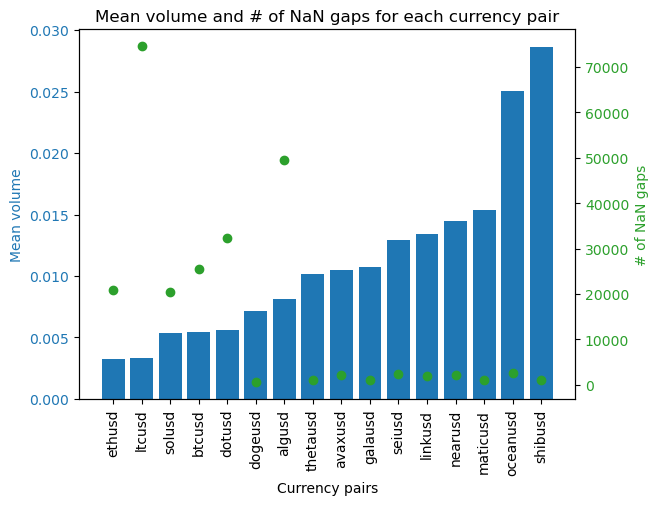

In [50]:
# plot average volume and number of nan gaps
fig, ax1 = plt.subplots()

ax1.bar(df_vol_missing["currency"],df_vol_missing["avg_vol"])
ax1.set_xlabel('Currency pairs')
ax1.set_ylabel('Mean volume', color = "tab:blue")
ax1.tick_params(axis ='y', labelcolor = "tab:blue")
ax1.tick_params(axis='x', labelrotation=90)

ax2 = ax1.twinx()
ax2.scatter(df_vol_missing["currency"],df_vol_missing["nan_gaps"], color="tab:green")
ax2.set_ylabel('# of NaN gaps', color = "tab:green")
ax2.tick_params(axis ='y', labelcolor = "tab:green")

plt.title("Mean volume and # of NaN gaps for each currency pair")
plt.xticks(rotation=90)
plt.show()

Now, we can tell that higher average trading volumes tends to correlate with fewer gaps in missing timepoints. The currency pairs with the highest trading volumes all have very few gaps in their data.

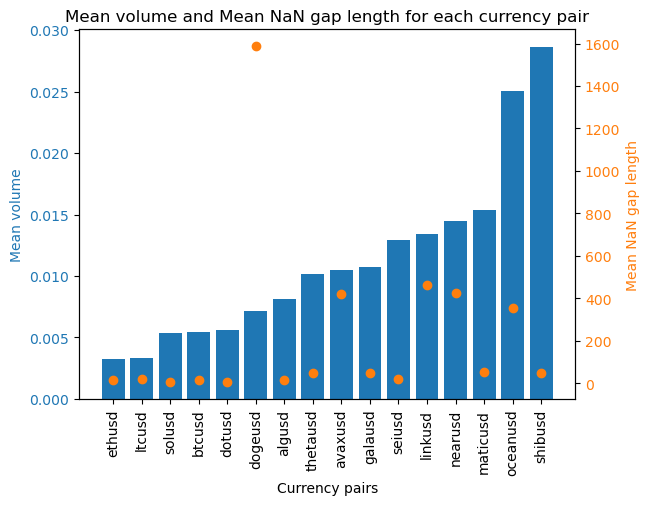

In [51]:
# plot average volume and average nan gap length
fig, ax1 = plt.subplots()

ax1.bar(df_vol_missing["currency"],df_vol_missing["avg_vol"])
ax1.set_xlabel('Currency pairs')
ax1.set_ylabel('Mean volume', color = "tab:blue")
ax1.tick_params(axis ='y', labelcolor = "tab:blue")
ax1.tick_params(axis='x', labelrotation=90)

ax2 = ax1.twinx()
ax2.scatter(df_vol_missing["currency"],df_vol_missing["avg_gap_len"], color="tab:orange")
ax2.set_ylabel('Mean NaN gap length', color = "tab:orange")
ax2.tick_params(axis ='y', labelcolor = "tab:orange")

plt.title("Mean volume and Mean NaN gap length for each currency pair")
plt.xticks(rotation=90)
plt.show()

Furthermore, we compare average trading volume to average gap length. There doesn't seem to be much of a relationship between these two values; most of the currency pairs have very short average gap lengths, likely indicating that most of the data that was originally missing was on a short time scale and were more successfully imputed. The "dogeusd" pair is an outlier: there seems to be a large chunk of missing data in its trading history.

In [52]:
# sort by number of nan gaps
df_gaps = df_vol_missing.sort_values(by=['nan_gaps'])
df_gaps = df_gaps.reset_index(drop=True)

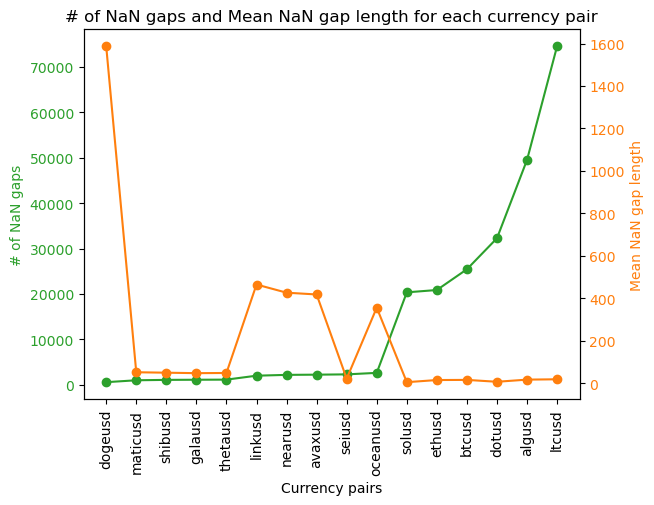

In [53]:
# plot number of nan gaps and average gap length
fig, ax1 = plt.subplots()

ax1.plot(df_gaps["currency"],df_gaps["nan_gaps"], color="tab:green", marker='o')
ax1.set_xlabel('Currency pairs')
ax1.set_ylabel('# of NaN gaps', color = "tab:green")
ax1.tick_params(axis ='y', labelcolor = "tab:green")
ax1.tick_params(axis='x', labelrotation=90)

ax2 = ax1.twinx()
ax2.plot(df_gaps["currency"],df_gaps["avg_gap_len"], color="tab:orange", marker='o')
ax2.set_ylabel('Mean NaN gap length', color = "tab:orange")
ax2.tick_params(axis ='y', labelcolor = "tab:orange")

plt.title("# of NaN gaps and Mean NaN gap length for each currency pair")
plt.xticks(rotation=90)
plt.show()

Comparing the number of gaps with the average gap length gives us more information about the type of missingness present for each currency pair and the quality of the data.

As mentioned above, the "dogeusd" pair is one extreme, where there are a few gaps in its trading history, but those gaps are very long. "ltcusd" is the other extreme, where it has many gaps in its trading history, but those gaps are very short. The ideal data situation is where both the number of gaps and the average gap length are low, e.g., for "maticusd", "shibusd", "galausd", "thetausd", and "seiusd". Looking back at the plots where average trading volume is included, we can see that these are some of the pairs with the highest trading volumes.

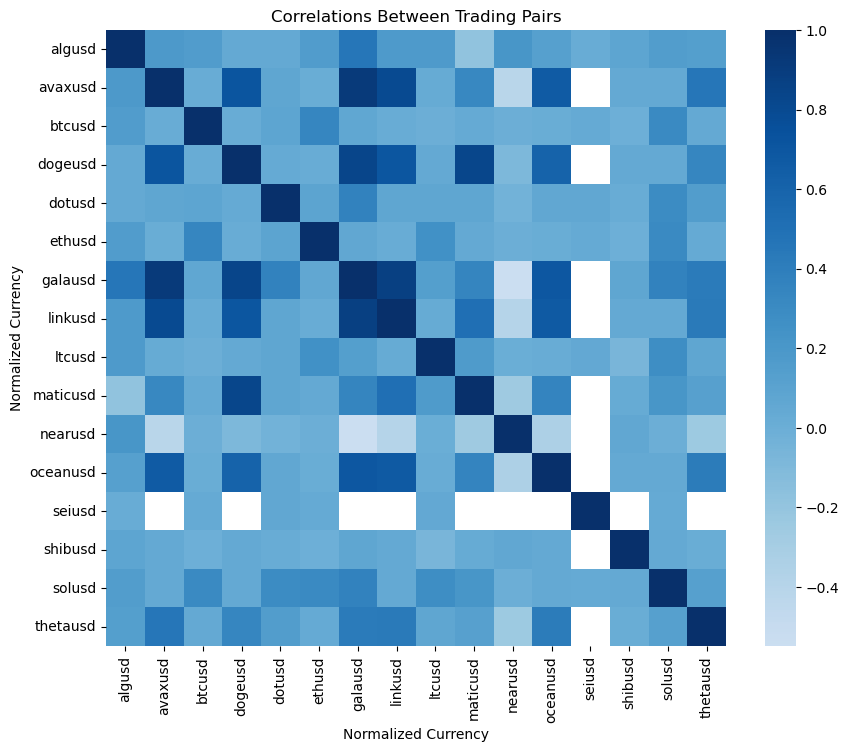

In [55]:
import pandas as pd

df = pd.read_csv('alltime_combined.csv')

df['datetime'] = pd.to_datetime(df['datetime'])

# Using 'close' price
df['return'] = df.groupby('pair_id')['close'].pct_change()

pivot_df = df.pivot_table(index='datetime', columns='normalized_currency', values='return')

correlation_matrix = pivot_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=False, cmap='Blues', center=0)
plt.title('Correlations Between Trading Pairs')
plt.xlabel('Normalized Currency')
plt.ylabel('Normalized Currency')
plt.show()

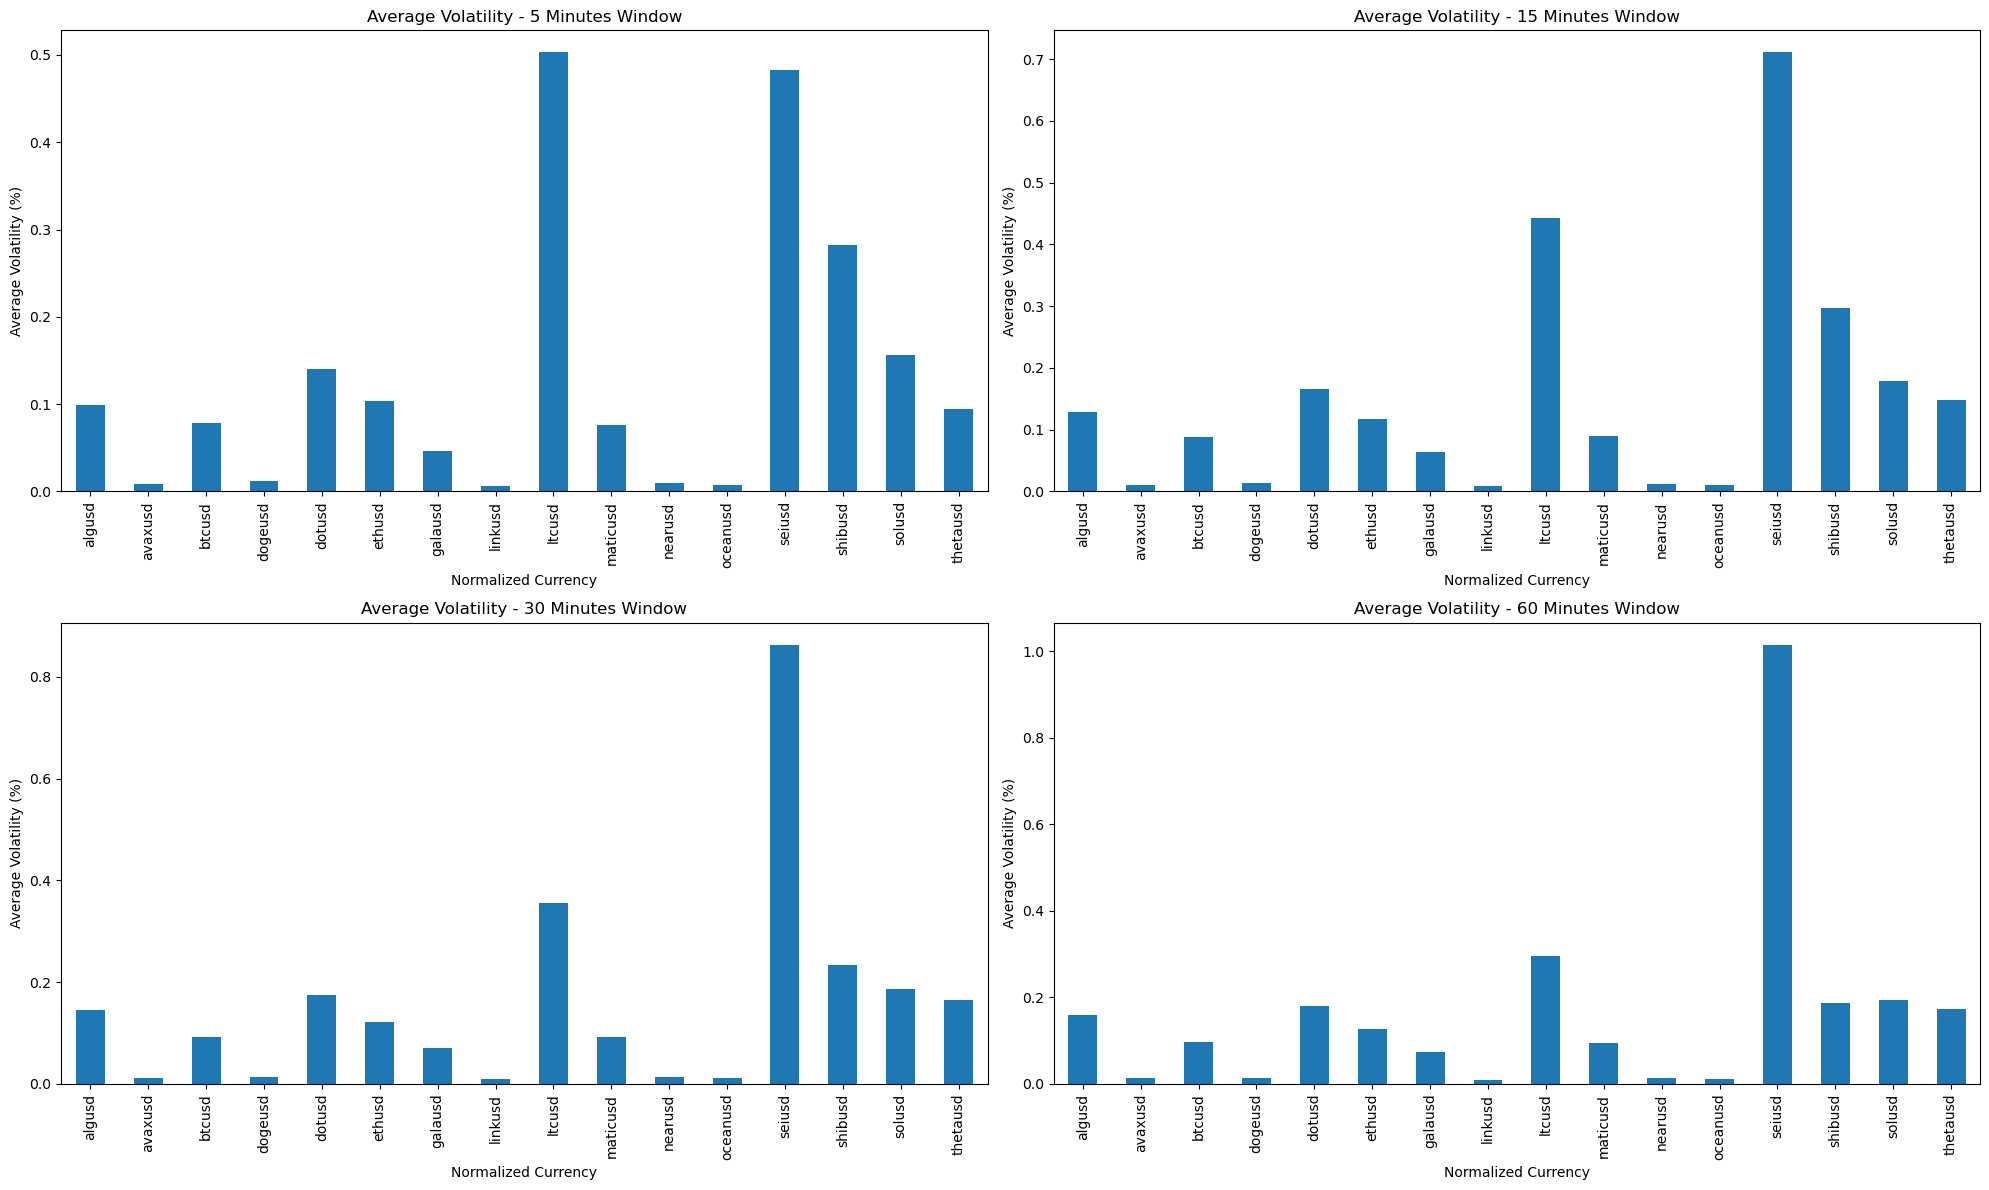

In [56]:
# in minutes
window_sizes = [5, 15, 30, 60]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 12))
axes = axes.flatten()

for i, window in enumerate(window_sizes):
    # Calculate rolling volatility for the current window size across all pairs
    df['rolling_volatility'] = df.groupby('normalized_currency')['return'].rolling(window=window).std().reset_index(level=0, drop=True)

    # average volatility percentage for each pair for this window size
    avg_volatility = df.groupby('normalized_currency')['rolling_volatility'].mean() * 100

    ax = axes[i]
    avg_volatility.plot(kind='bar', ax=ax)
    ax.set_title(f'Average Volatility - {window} Minutes Window')
    ax.set_xlabel('Normalized Currency')
    ax.set_ylabel('Average Volatility (%)')

plt.tight_layout()
plt.show()

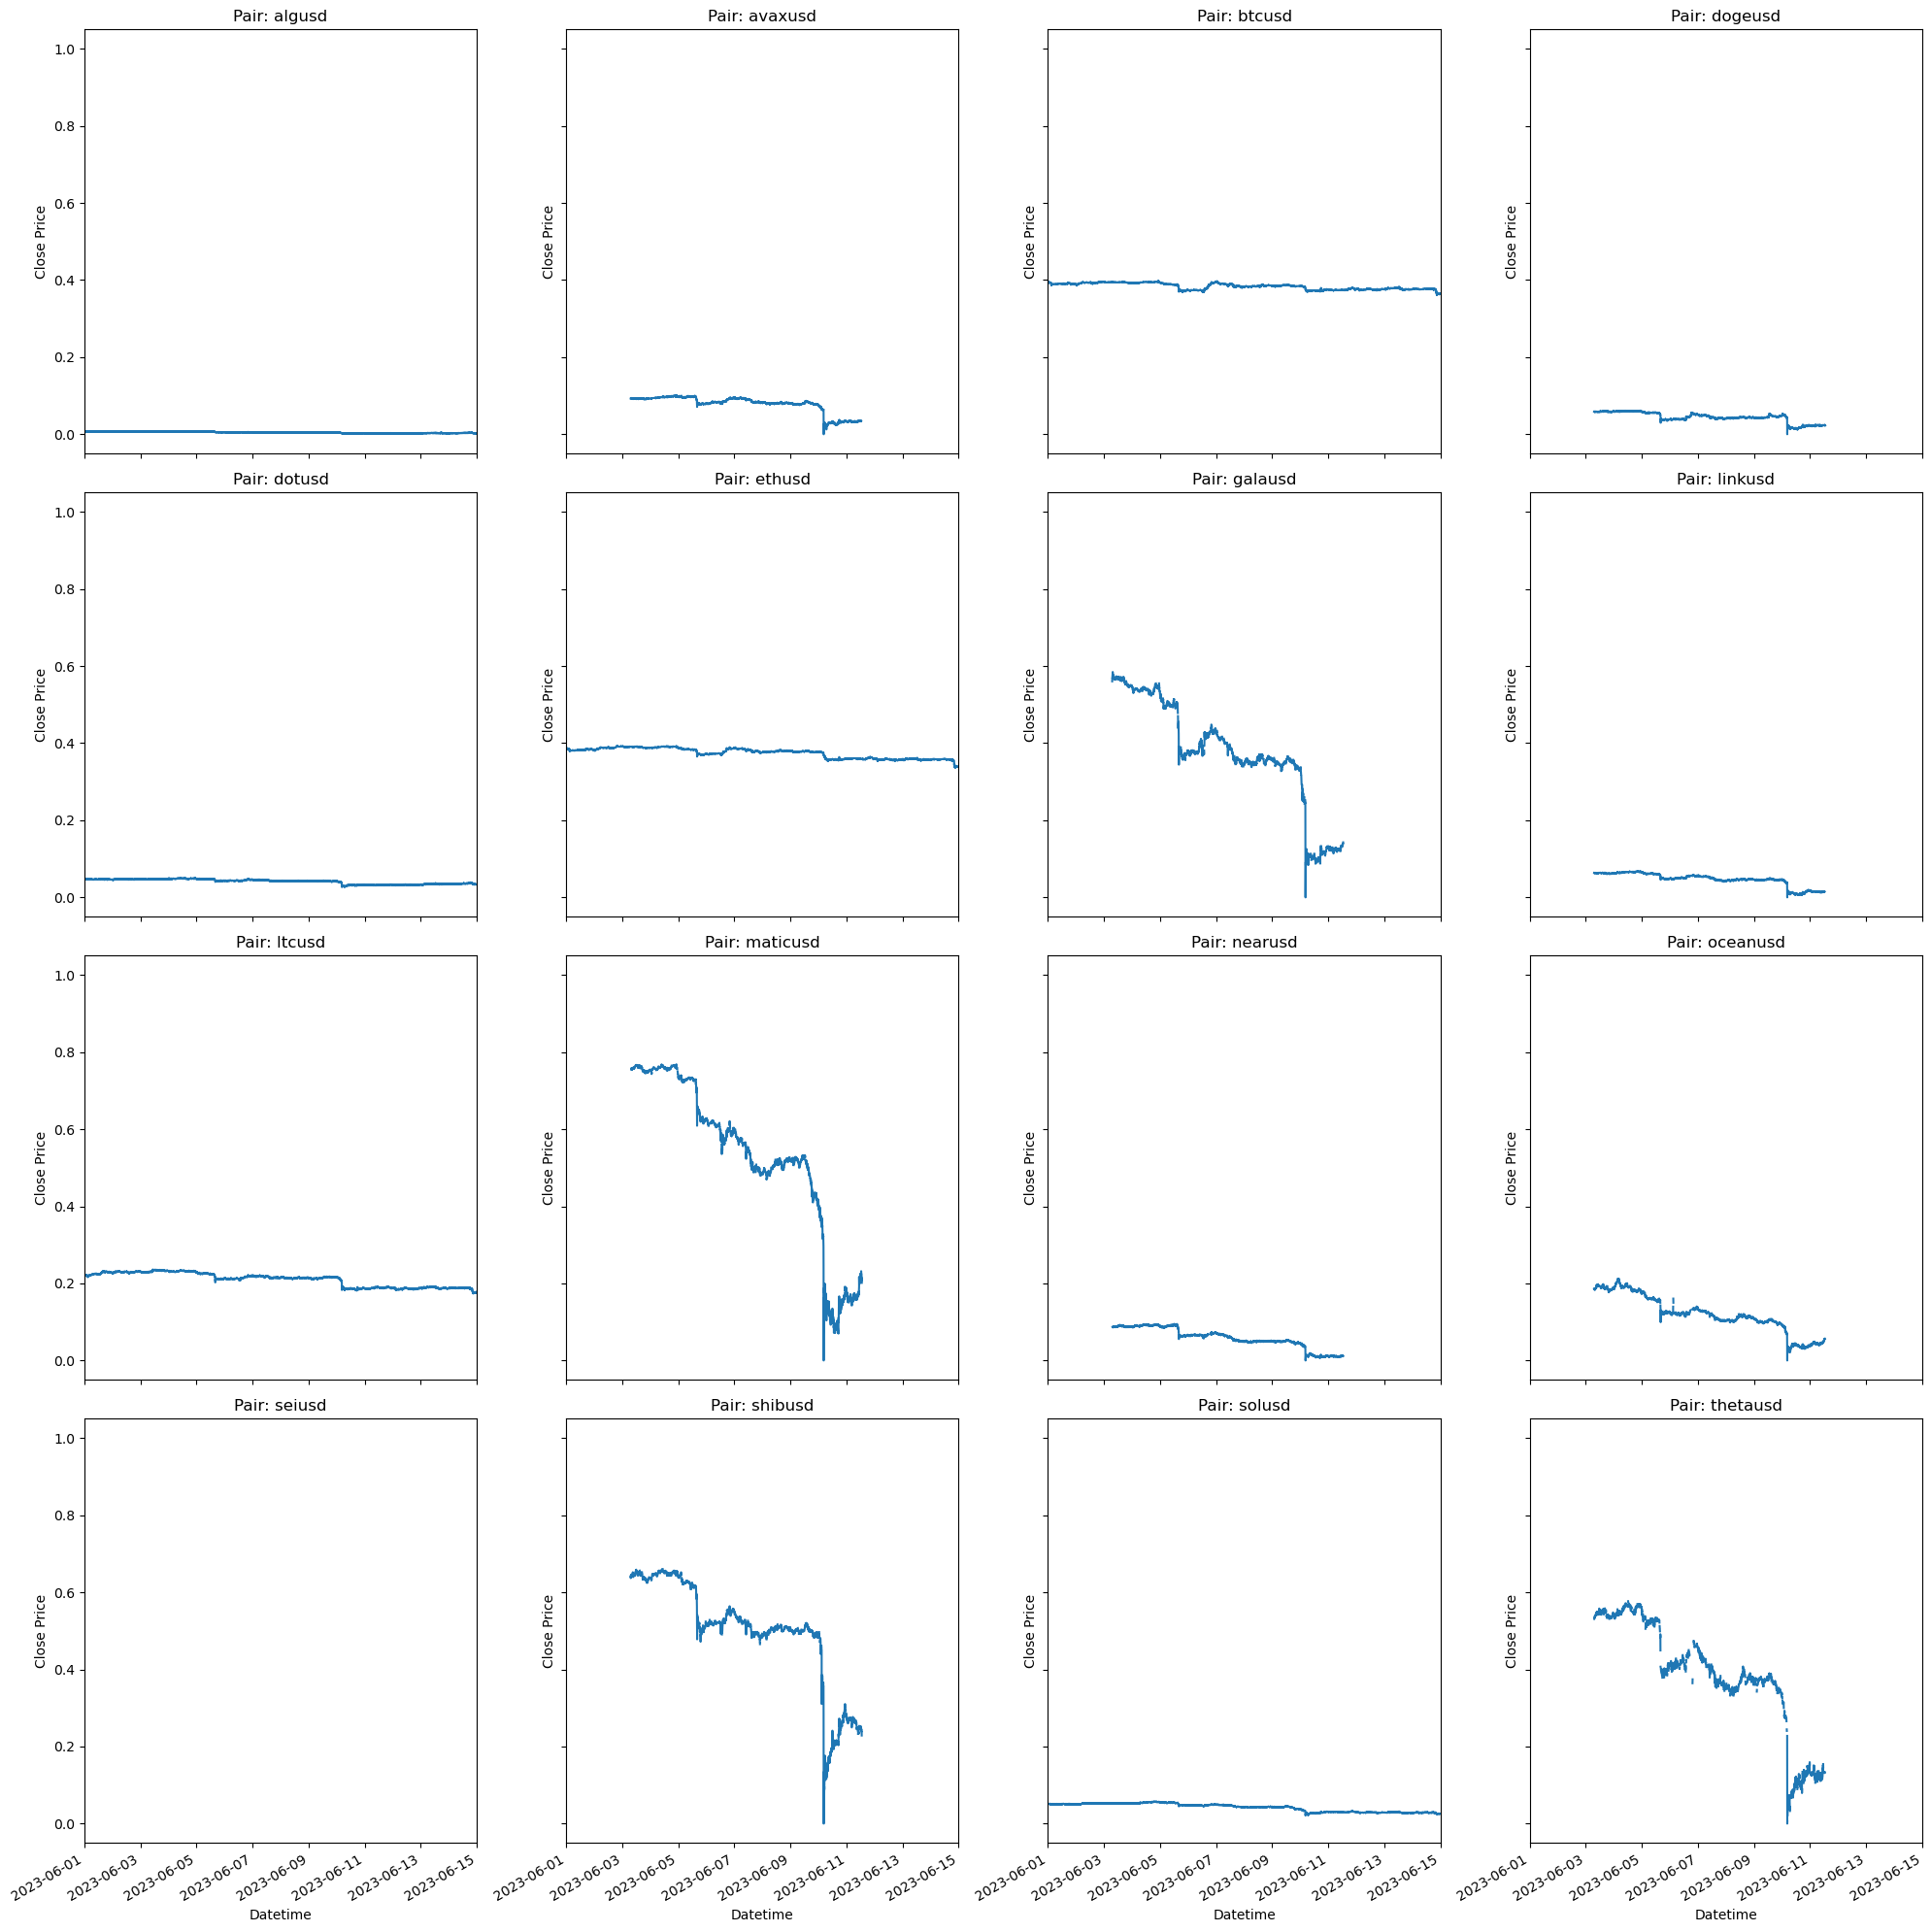

In [57]:
start_date = pd.to_datetime("2023-06-01")
end_date = pd.to_datetime("2023-06-15")
global_start_date = df['datetime'].min()
global_end_date = df['datetime'].max()

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 20), sharex=True, sharey=True)
axes = axes.flatten()

for pair_id in range(0, 16):
    # Filter the DataFrame for the current pair
    df_pair = df[df['pair_id'] == pair_id]
    pair_title = df_pair['normalized_currency'].iloc[0]

    # Plot the close prices for this pair
    ax = axes[pair_id]
    ax.plot(df_pair['datetime'], df_pair['close'], marker='', linestyle='-', label=f'Pair {pair_id}')
    ax.set_title(f'Pair: {pair_title}')

    ax.set_xlim(start_date, end_date)

    ax.xaxis_date()
    fig.autofmt_xdate()

    ax.set_xlabel('Datetime')
    ax.set_ylabel('Close Price')

plt.tight_layout()
plt.show()

/var/folders/qw/9d5gnk7d6zzcz5nv2h3prjl00000gn/T/ipykernel_4877/422276560.py:26: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(lags, ccf_values, use_line_collection=True)


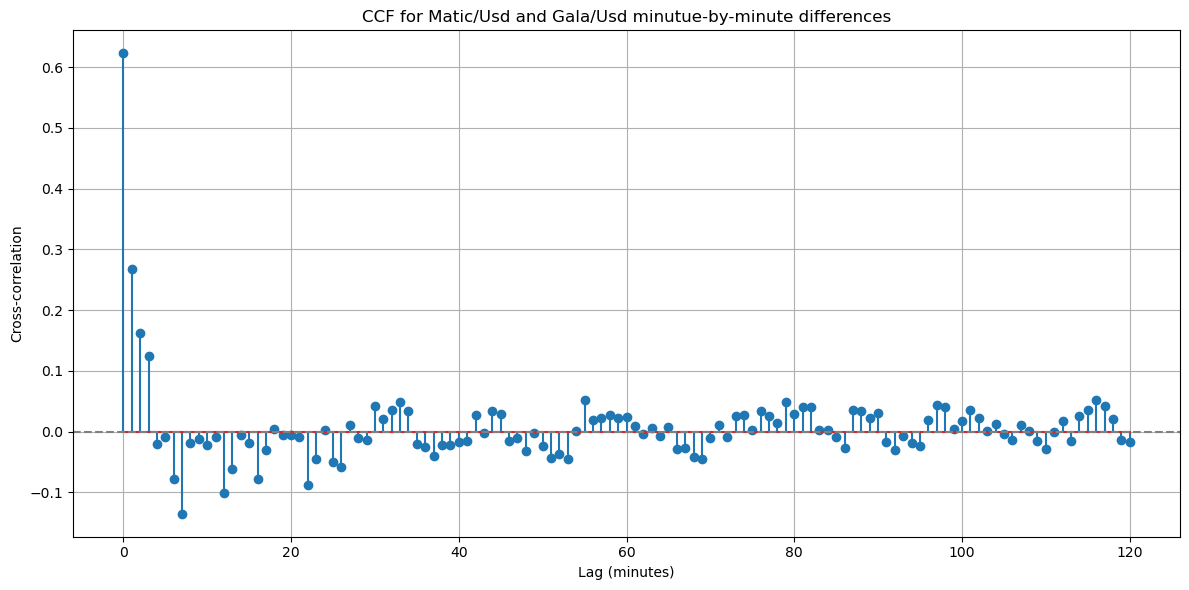

In [58]:
from statsmodels.tsa.stattools import ccf

start_date = pd.to_datetime("2023-06-04")
end_date = pd.to_datetime("2023-06-11")

df_filtered = df[(df['datetime'] >= start_date) & (df['datetime'] <= end_date)]

df_pair1 = df_filtered[df_filtered['normalized_currency'] == 'maticusd'].set_index('datetime')['close'].dropna()
df_pair2 = df_filtered[df_filtered['normalized_currency'] == 'galausd'].set_index('datetime')['close'].dropna()

df_pair1_aligned, df_pair2_aligned = df_pair1.align(df_pair2, join='inner')

df_pair1_diff = df_pair1_aligned.diff().dropna()
df_pair2_diff = df_pair2_aligned.diff().dropna()

if df_pair1_diff.empty or df_pair2_diff.empty:
    print("One of the series is empty after differencing; check your data.")
elif df_pair1_diff.std() == 0 or df_pair2_diff.std() == 0:
    print("One of the series is constant after differencing; cannot compute CCF.")
else:
    max_lags = 120
    ccf_values = ccf(df_pair1_diff, df_pair2_diff)[:max_lags + 1]

    plt.figure(figsize=(12, 6))
    lags = range(0, max_lags + 1)
    plt.stem(lags, ccf_values, use_line_collection=True)
    plt.title('CCF for Matic/Usd and Gala/Usd minutue-by-minute differences')
    plt.xlabel('Lag (minutes)')
    plt.ylabel('Cross-correlation')
    plt.axhline(y=0, linestyle='--', color='gray')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [59]:
from statsmodels.tsa.stattools import adfuller

def check_stationarity(timeseries):

    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')  # Automatically selects the lag that yields the smallest AIC

    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value

    print(dfoutput)

check_stationarity(df_pair1)

Results of Dickey-Fuller Test:
Test Statistic                   -0.448232
p-value                           0.901729
#Lags Used                       26.000000
Number of Observations Used    5857.000000
Critical Value (1%)              -3.431467
Critical Value (5%)              -2.862034
Critical Value (10%)             -2.567033
dtype: float64


In [60]:
df_pair1_diff = df_pair1.diff().dropna()

result_diff_1 = adfuller(df_pair1_diff)
print(f'ADF Statistic (diff): {result_diff_1[0]}')
print(f'p-value (diff): {result_diff_1[1]}')

ADF Statistic (diff): -14.69175701733669
p-value (diff): 3.0417208824418898e-27


In [61]:
df_pair2_diff = df_pair2.diff().dropna()

result_diff_2 = adfuller(df_pair2_diff)
print(f'ADF Statistic (diff): {result_diff_2[0]}')
print(f'p-value (diff): {result_diff_2[1]}')

ADF Statistic (diff): -12.064023280115439
p-value (diff): 2.432156853800912e-22


In [63]:
df.columns

Index(['datetime', 'time', 'open', 'close', 'high', 'low', 'volume', 'cur',
       'normalized_currency', 'marker', 'pair_id', 'return',
       'rolling_volatility'],
      dtype='object')

/var/folders/qw/9d5gnk7d6zzcz5nv2h3prjl00000gn/T/ipykernel_4877/2802547691.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_single_pair['rolling_volatility'] = df_single_pair['return'].rolling(window=5).std() * 100


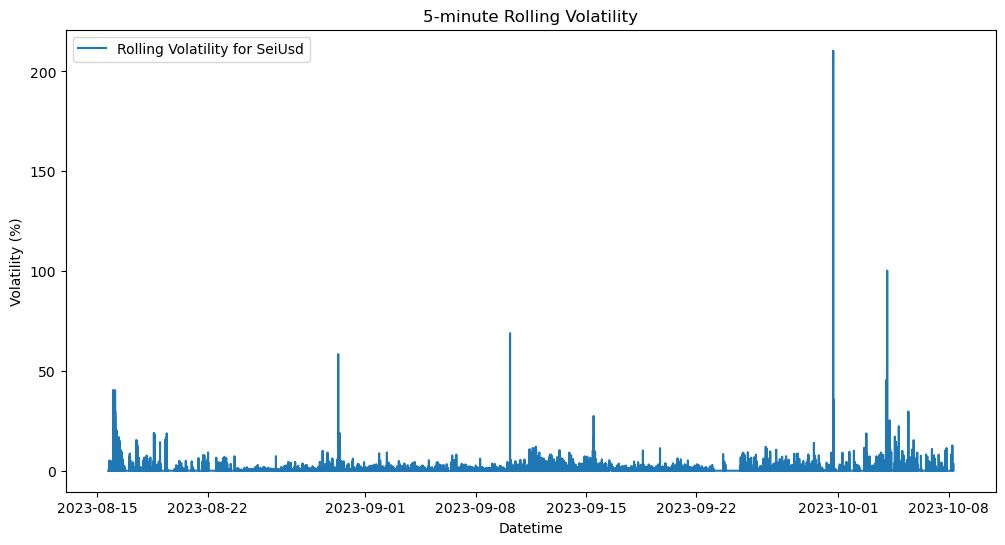

In [64]:
df_single_pair = df[df['pair_id'] == 12.0]

# Calculate rolling volatility over a 10-minute window for seiusd
df_single_pair['rolling_volatility'] = df_single_pair['return'].rolling(window=5).std() * 100

# start_date = pd.to_datetime("2023-09-30 15")
# end_date = pd.to_datetime("2023-09-30 18")

plt.figure(figsize=(12, 6))
plt.plot(df_single_pair['datetime'], df_single_pair['rolling_volatility'], label='Rolling Volatility for SeiUsd')
plt.title('5-minute Rolling Volatility')
plt.xlabel('Datetime')
plt.ylabel('Volatility (%)')
plt.legend()
# plt.xlim(start_date, end_date)
plt.show()

In [65]:
df = df.sort_values(by=['pair_id', 'datetime'])

# Calculate price changes
df['price_change'] = df.groupby('pair_id')['close'].diff()

# Separate gains and losses
df['gain'] = df['price_change'].apply(lambda x: x if x > 0 else 0)
df['loss'] = df['price_change'].apply(lambda x: -x if x < 0 else 0)

# Define the window for calculating RSI
window_length = 14

# Calculate the Exponential Moving Average (EMA) of gains and losses
df['avg_gain'] = df.groupby('pair_id')['gain'].transform(lambda x: x.ewm(span=window_length).mean())
df['avg_loss'] = df.groupby('pair_id')['loss'].transform(lambda x: x.ewm(span=window_length).mean())

# Calculate the RS
df['rs'] = df['avg_gain'] / df['avg_loss']

# Calculate the RSI
df['rsi'] = 100 - (100 / (1 + df['rs']))

df_valid_rsi = df.dropna(subset=['rsi'])

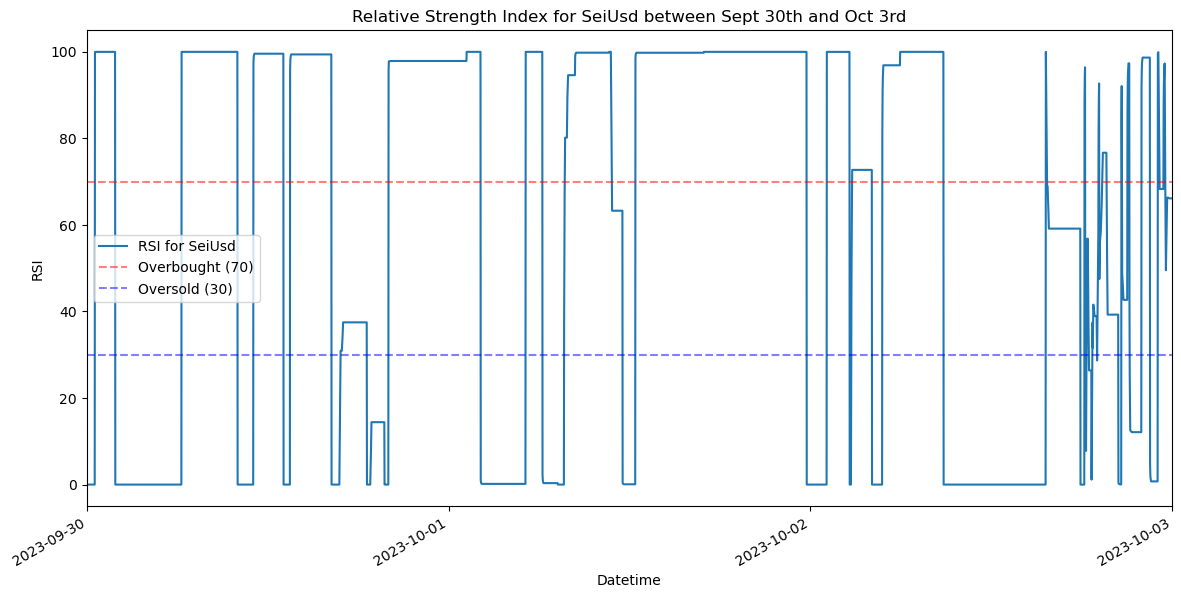

In [66]:
import matplotlib.dates as mdates
pair_id_to_plot = 12.0
df_pair = df[df['pair_id'] == pair_id_to_plot]

start_date = pd.to_datetime("2023-09-30")
end_date = pd.to_datetime("2023-10-3")

plt.figure(figsize=(14, 7))

# Plot RSI
plt.plot(df_pair['datetime'], df_pair['rsi'], label=f'RSI for SeiUsd')

# Highlight overbought and oversold areas
plt.axhline(70, linestyle='--', color='red', alpha=0.5, label='Overbought (70)')
plt.axhline(30, linestyle='--', color='blue', alpha=0.5, label='Oversold (30)')

plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()

plt.title(f'Relative Strength Index for SeiUsd between Sept 30th and Oct 3rd')
plt.xlabel('Datetime')
plt.ylabel('RSI')
plt.legend()
plt.xlim(start_date, end_date)

plt.show()

### Baseline Model <a id="baseline"></a>


[**Return to Contents**](#contents)
<hr style="height:2.4pt">

For our baseline model, we plan to implement a vanilla RNN. We will train several models, with the goal of open price prediction at different time intervals. We will attempt to predict open prices at 1 hour, 1 day, and 1 week timespans into the future. For the 1 hour prediction, we plan to use a window of the past 120 minutes to train the model. Likewise, for the 1 day and 1 week predictions we use the past 2 days or 2 weeks of data for training and prediction. Note that to prevent leaking data or any leak ahead bias, we must be careful dividing our time series data between test and train sets. We plan to train our model with earlier data, that is data prior to 06/2023, and then use test data only following this time. Our loss function will be mean squared error (MSE) as we are predicting a single regression value, and we will use the Adam optimizer (with default hyperparameters that can be later tuned). The RNN will consist of a single hidden layer and be solely forward directional. Additionally, we will use a tanh activation function.

We expect to potentially run into a vanishing gradient problem common with vanilla RNNs as well as limited accuracy in our predictions, which will hopefully be addressed by our later modeling attempts. Nonetheless, we hope that this approach provides a meaningful baseline to compare our later improved models.

Our later models will explore the incorporation of more advanced networks, such as LSTM. We will not perform any feature engineering, but this will be an area of exploration for our future models. We can implement feature engineering to create technical indicators that are commonly used in trading (such as RSI, MACD, moving averages, etc.)

